In [34]:
from spectral_cube import SpectralCube
import astropy.units as u
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import regions

In [6]:
result_select=pd.read_csv('targets_select.csv',sep=',')

(52, 48, 54)
(93, 45, 55)
(60, 63, 55)
(29, 43, 46)
(107, 132, 98)
(22, 44, 46)
(141, 65, 66)
(23, 43, 43)
(21, 44, 44)
(55, 54, 54)
(100, 75, 60)
(18, 43, 43)
(83, 60, 57)
(8, 43, 44)
(38, 44, 47)
(47, 53, 53)
(32, 44, 46)
(37, 48, 52)
(55, 50, 52)
(27, 44, 45)
(44, 49, 55)
(12, 43, 43)
(29, 50, 46)
(26, 45, 45)
(67, 56, 56)
(136, 75, 65)
(73, 72, 63)
(71, 64, 66)
(21, 44, 45)
(52, 41, 48)
(142, 62, 69)


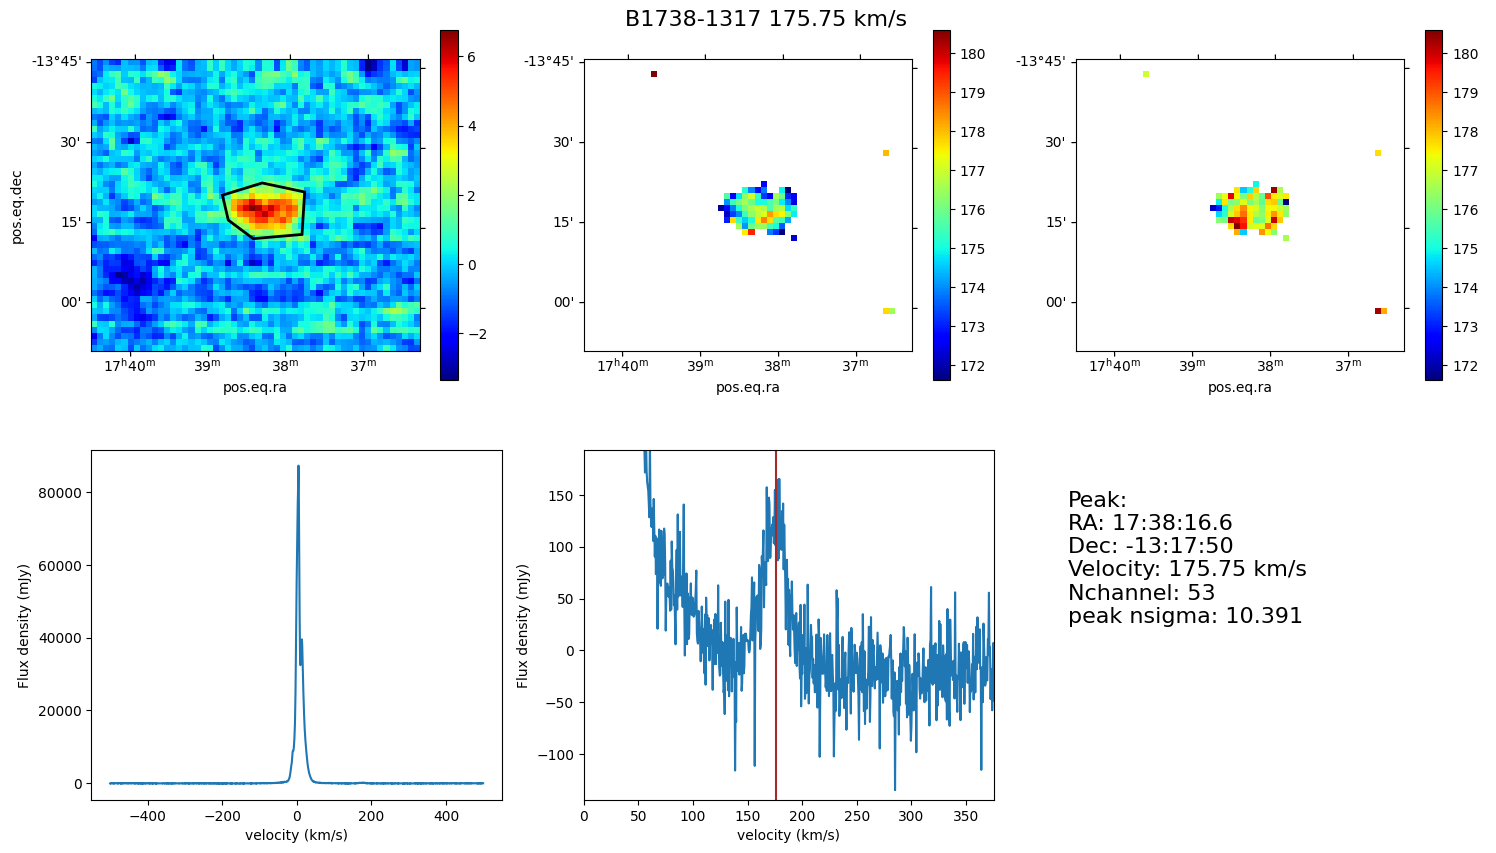

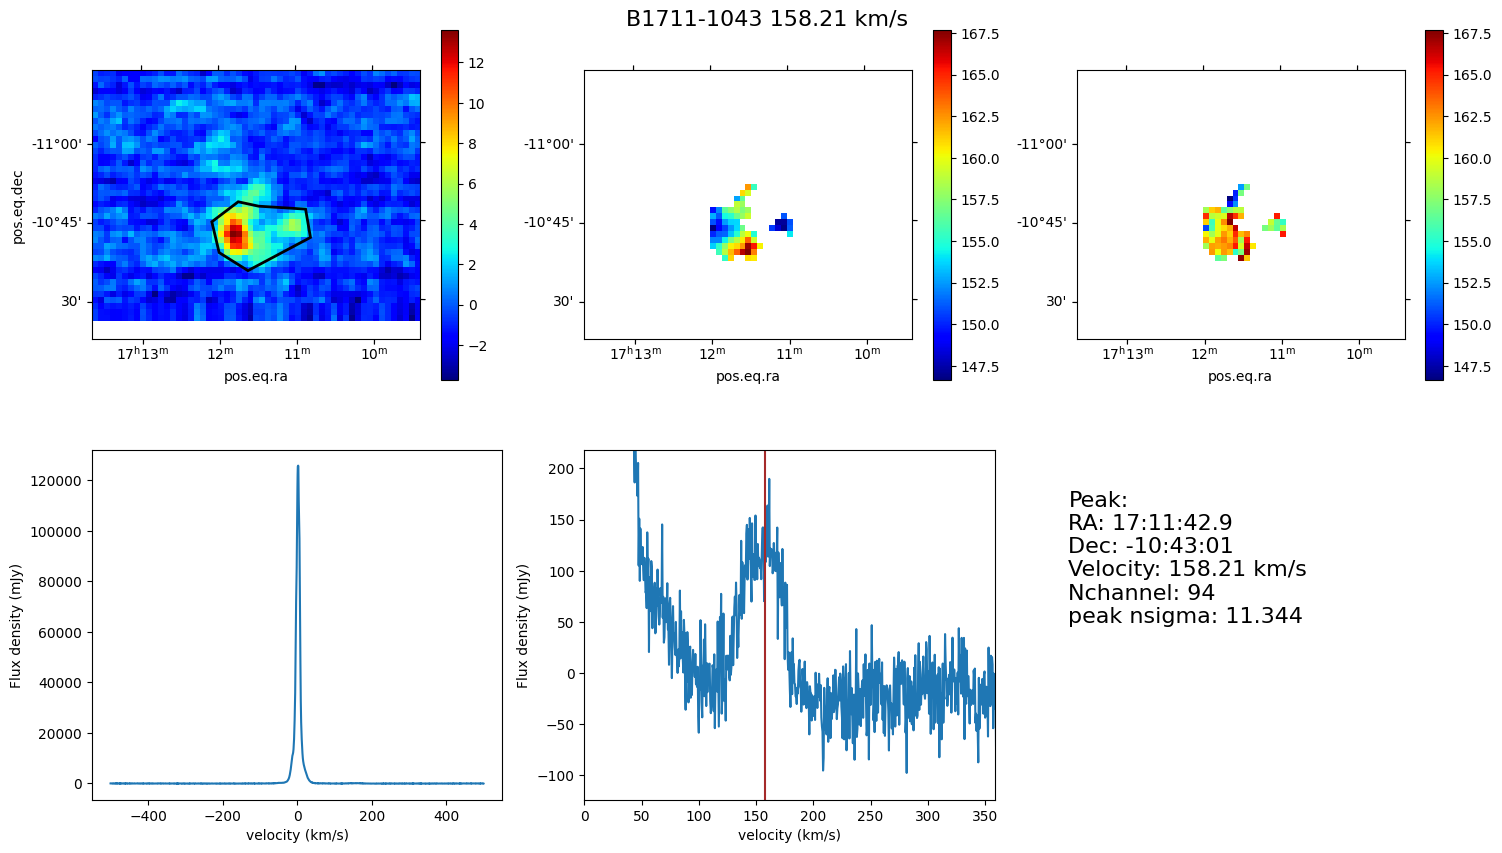

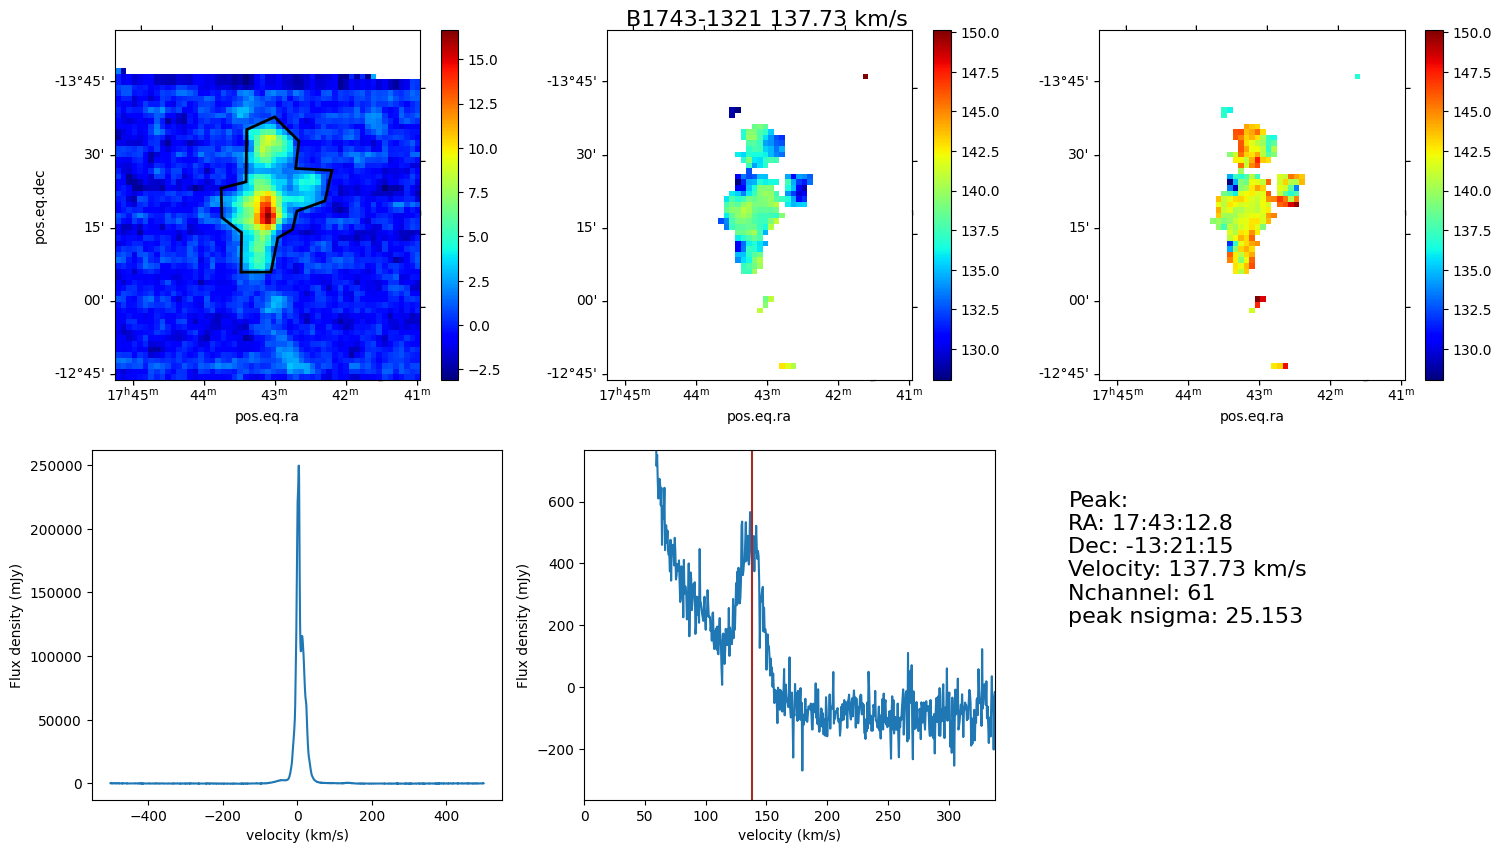

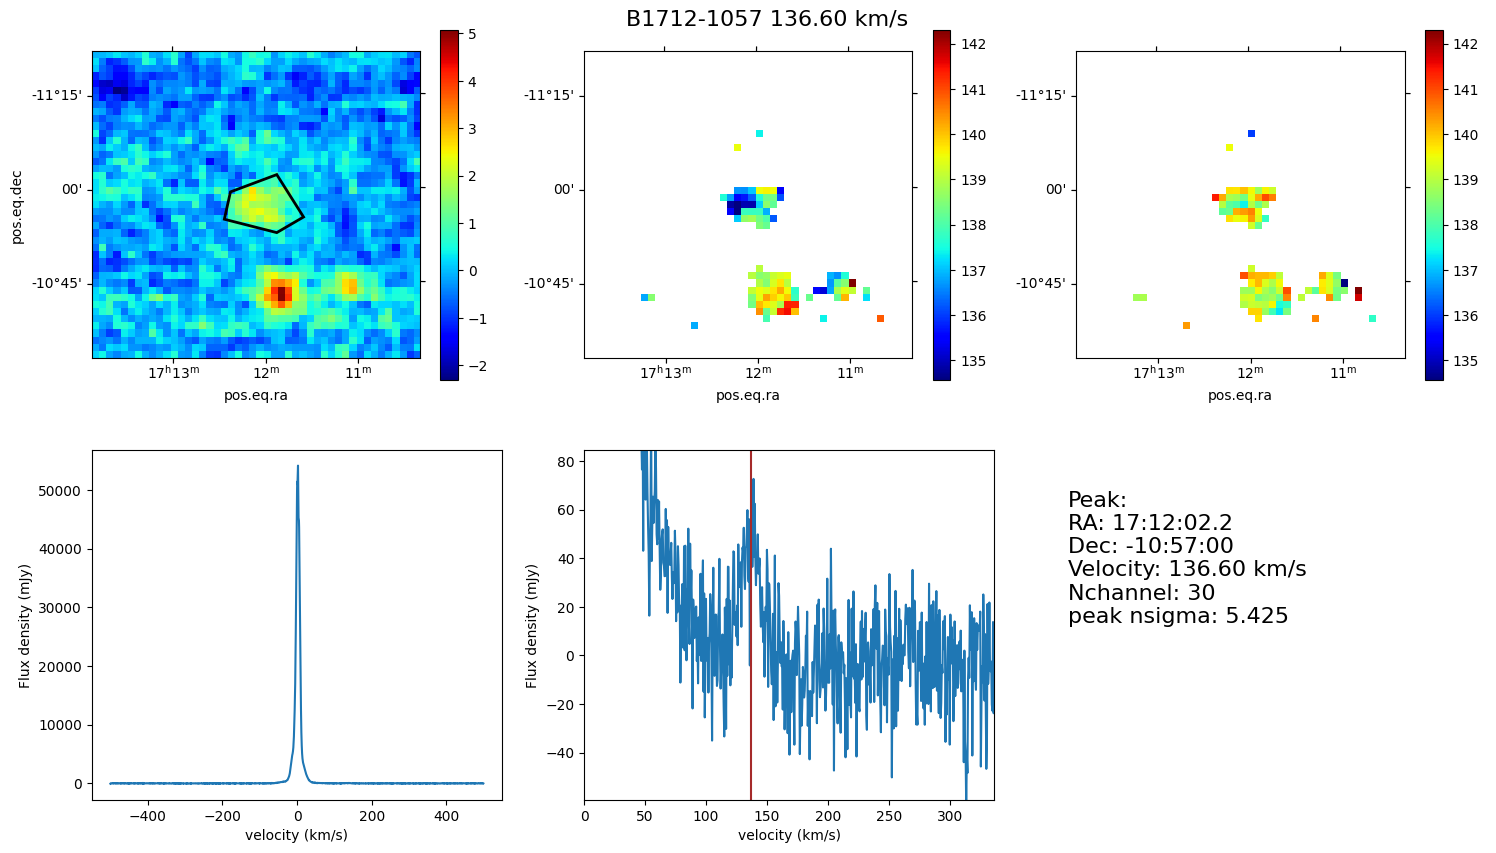

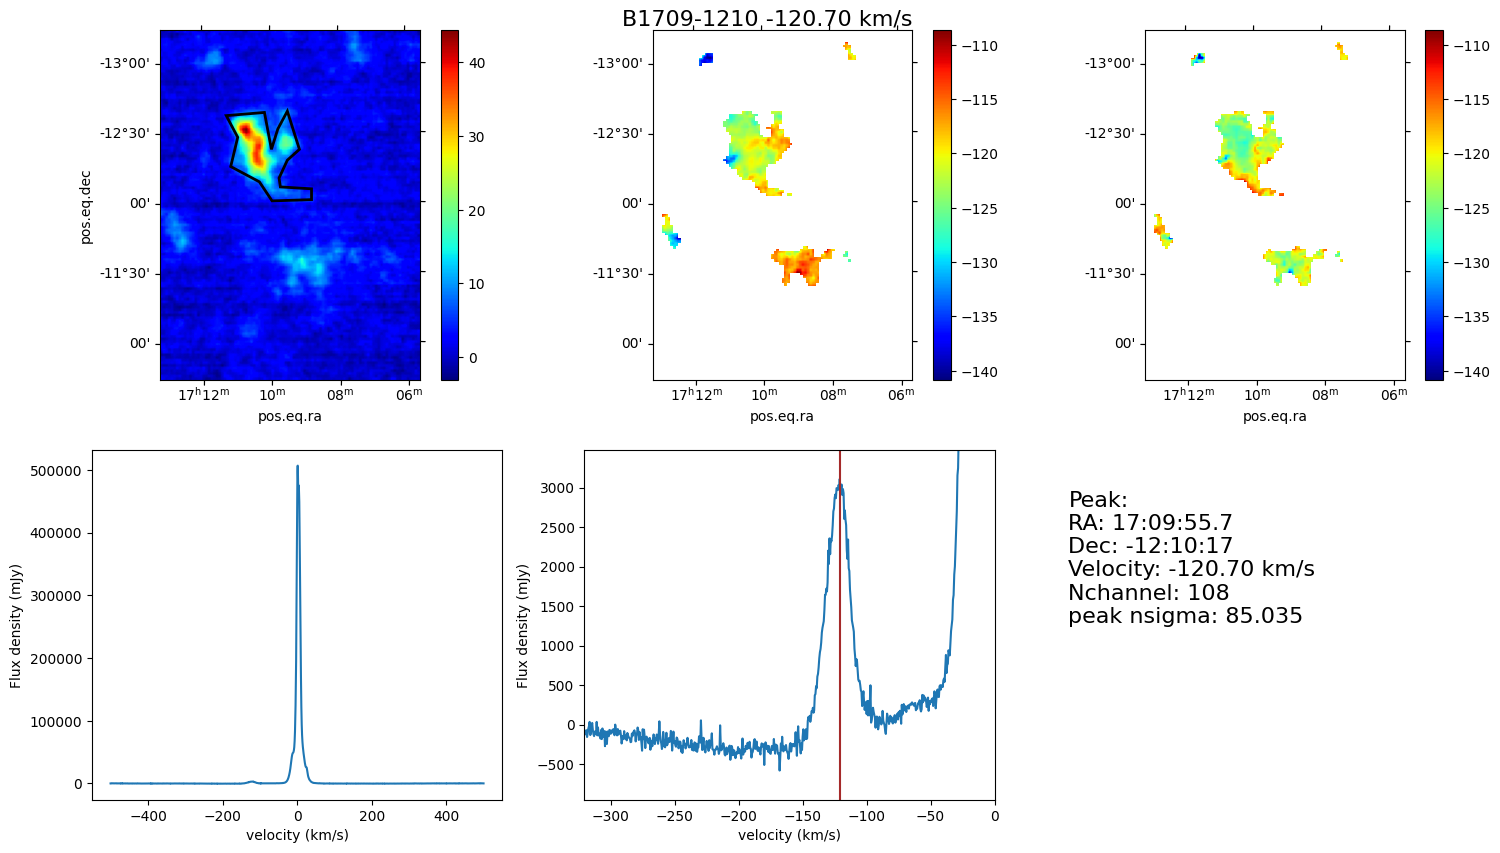

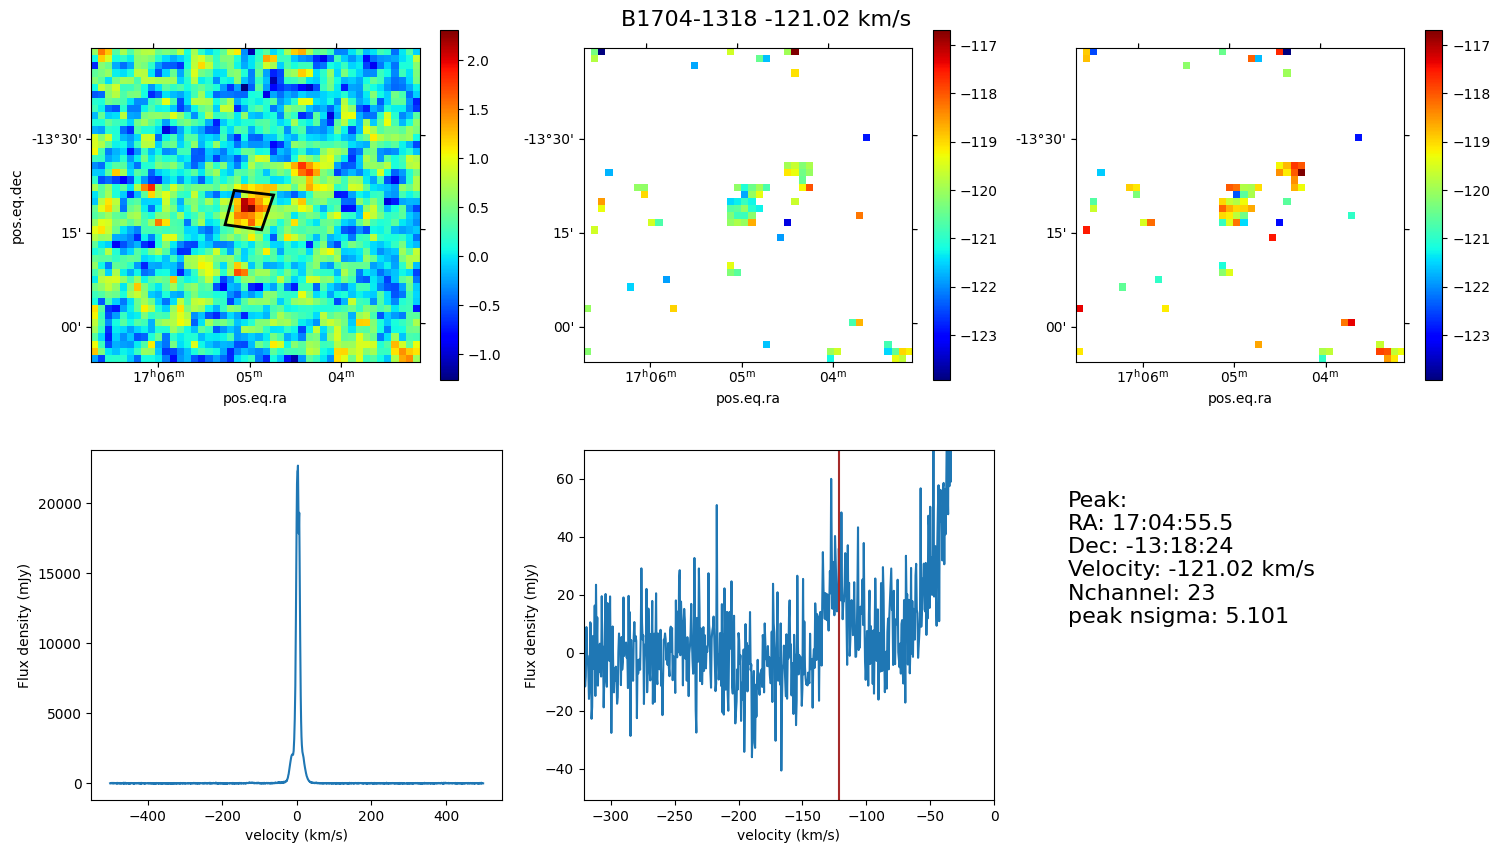

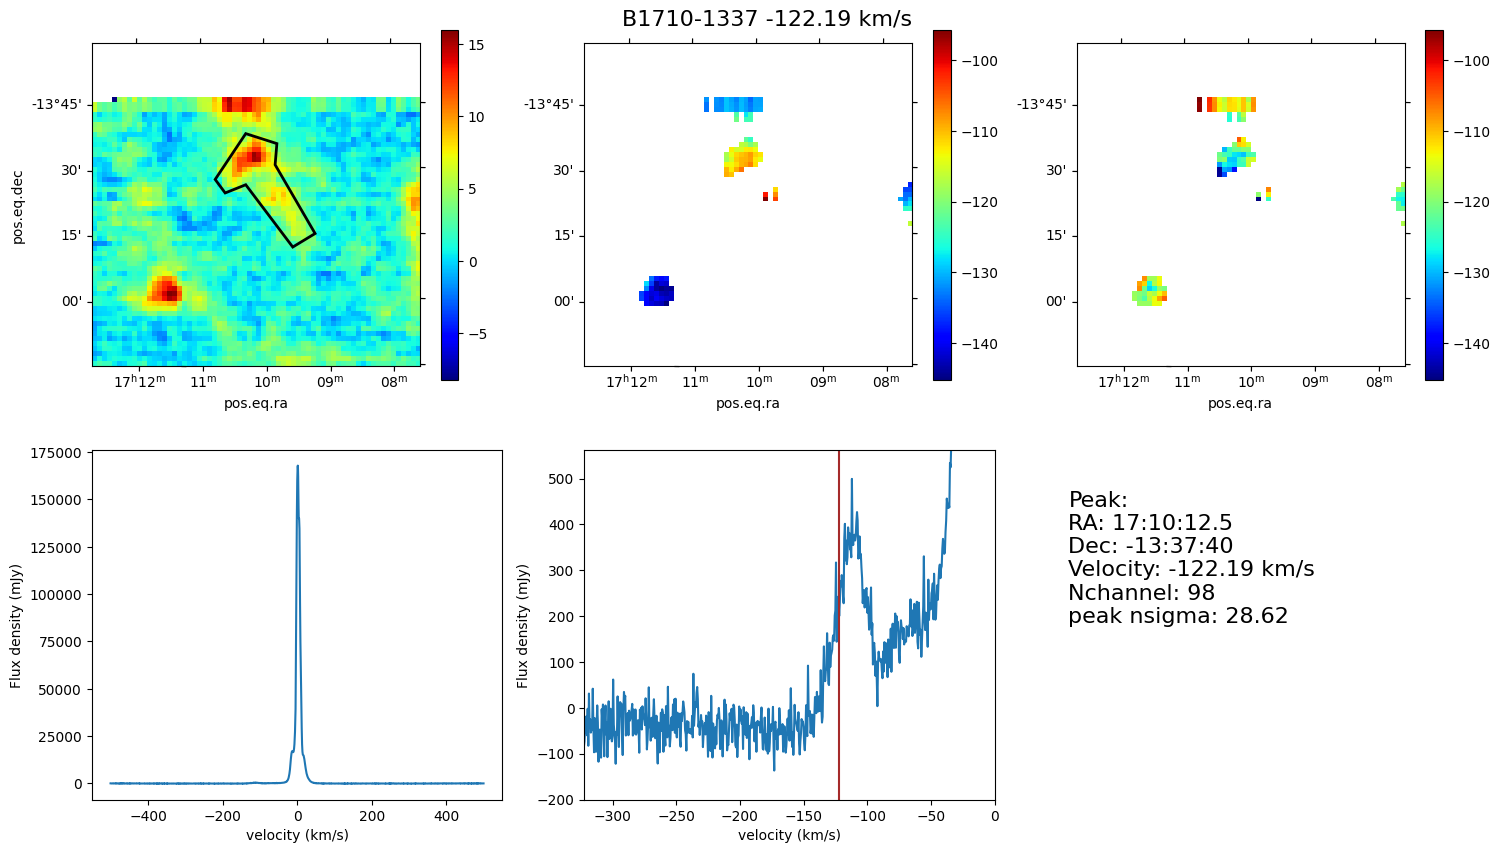

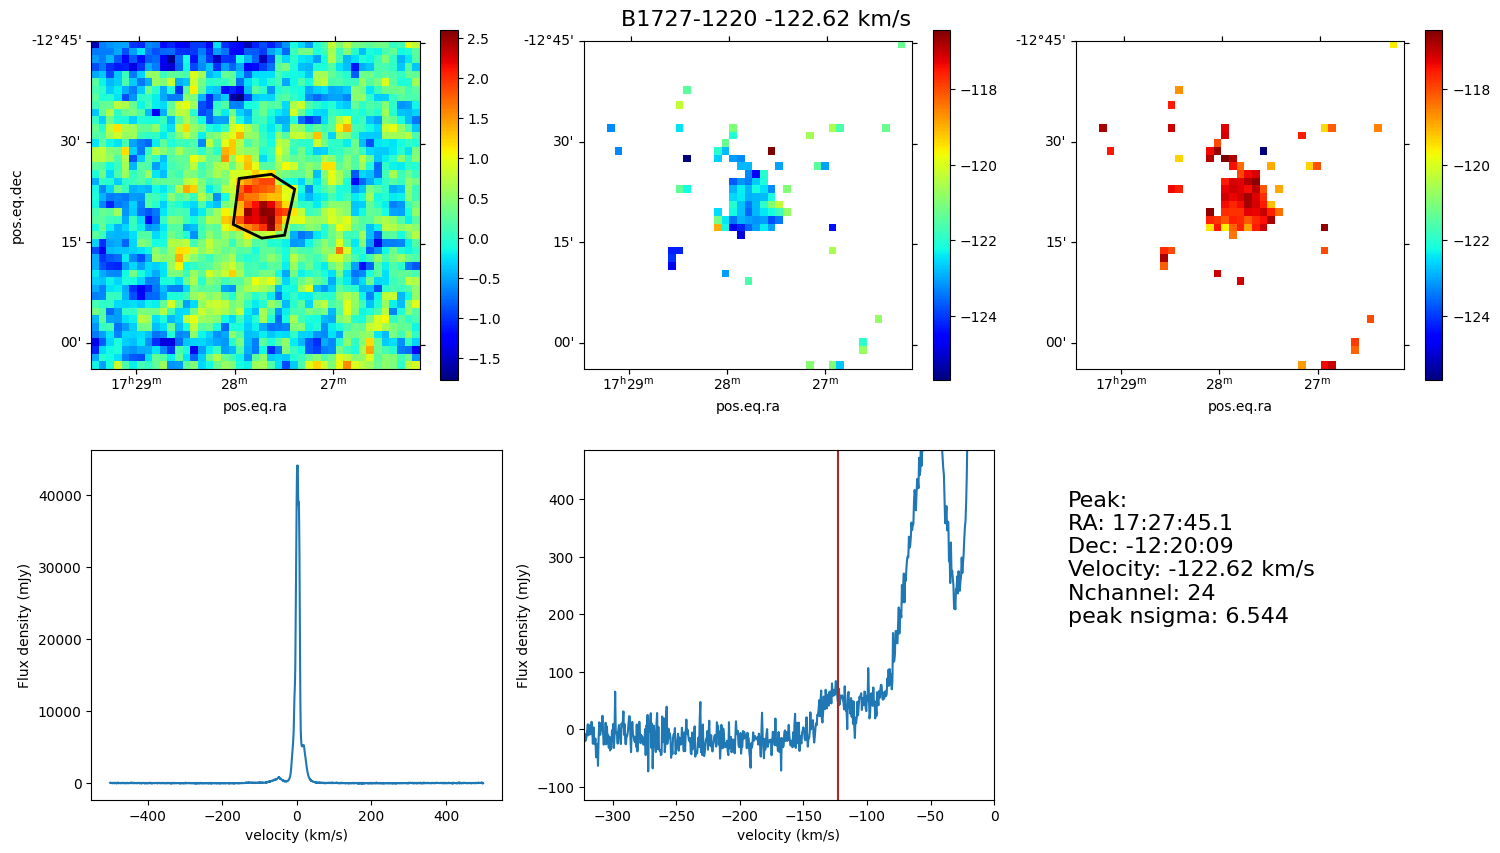

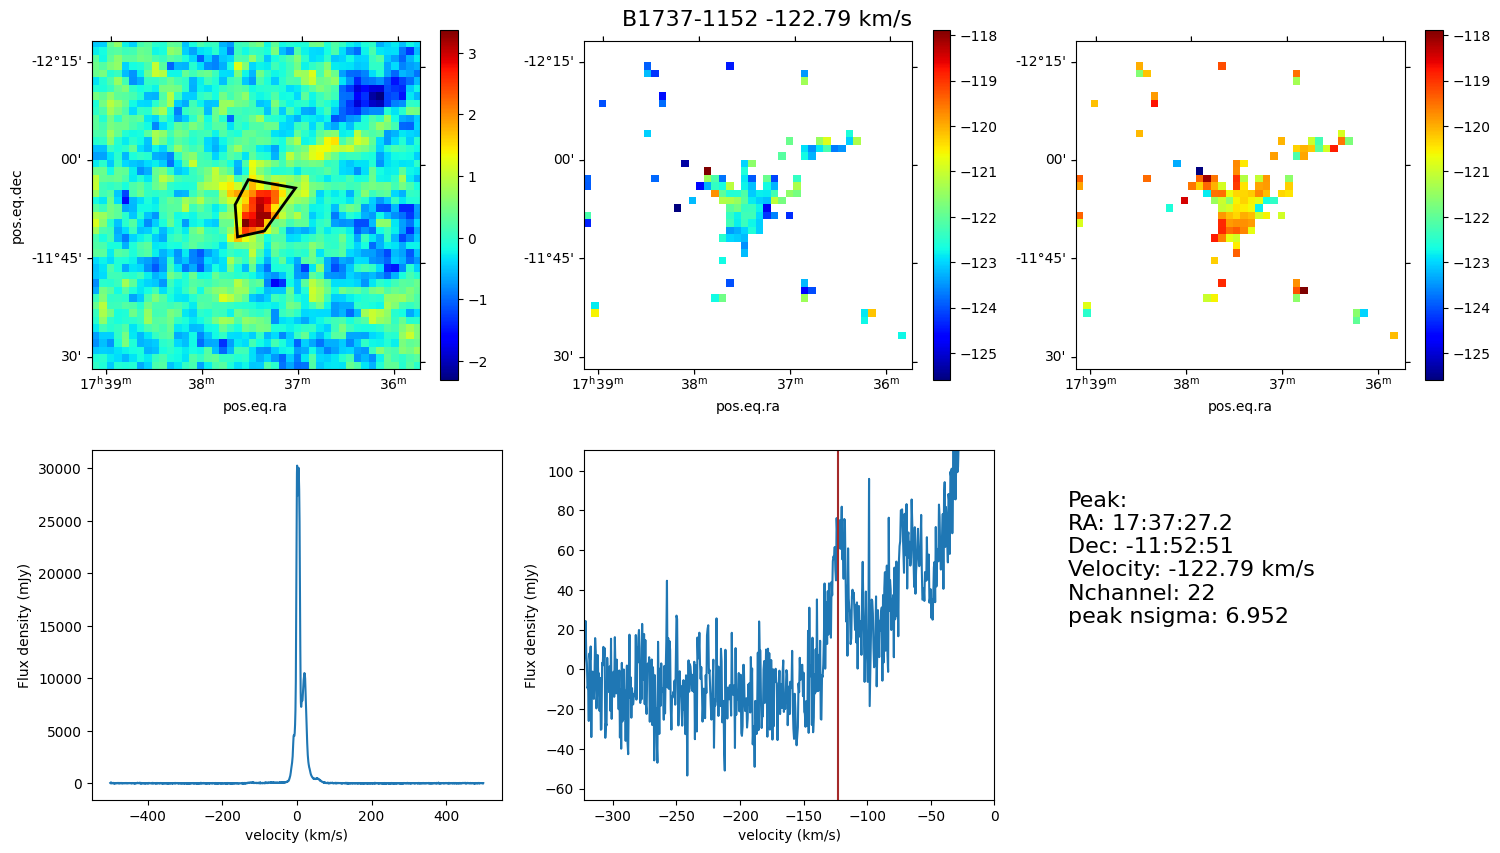

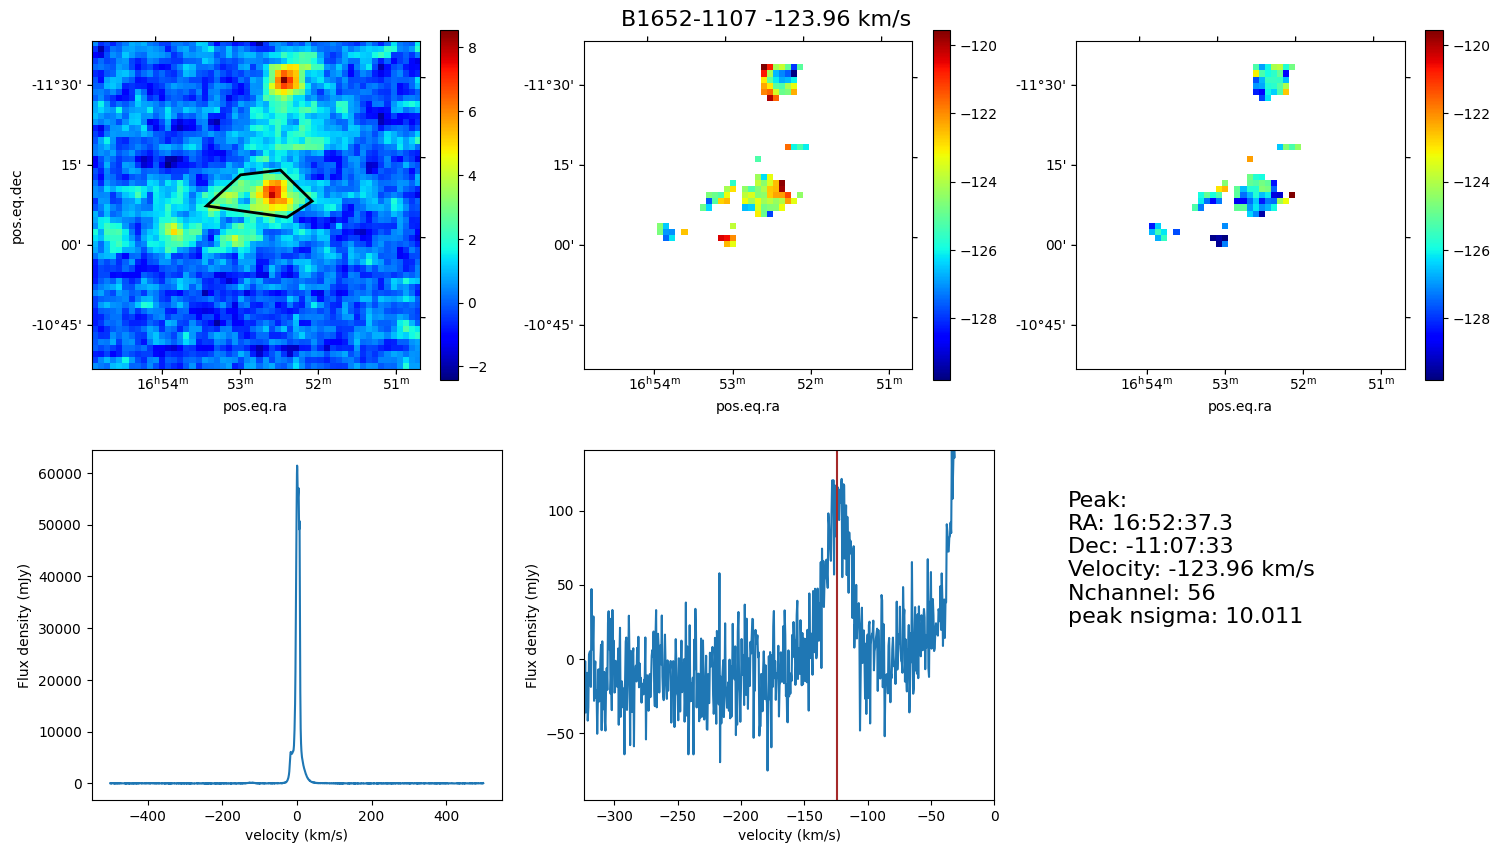

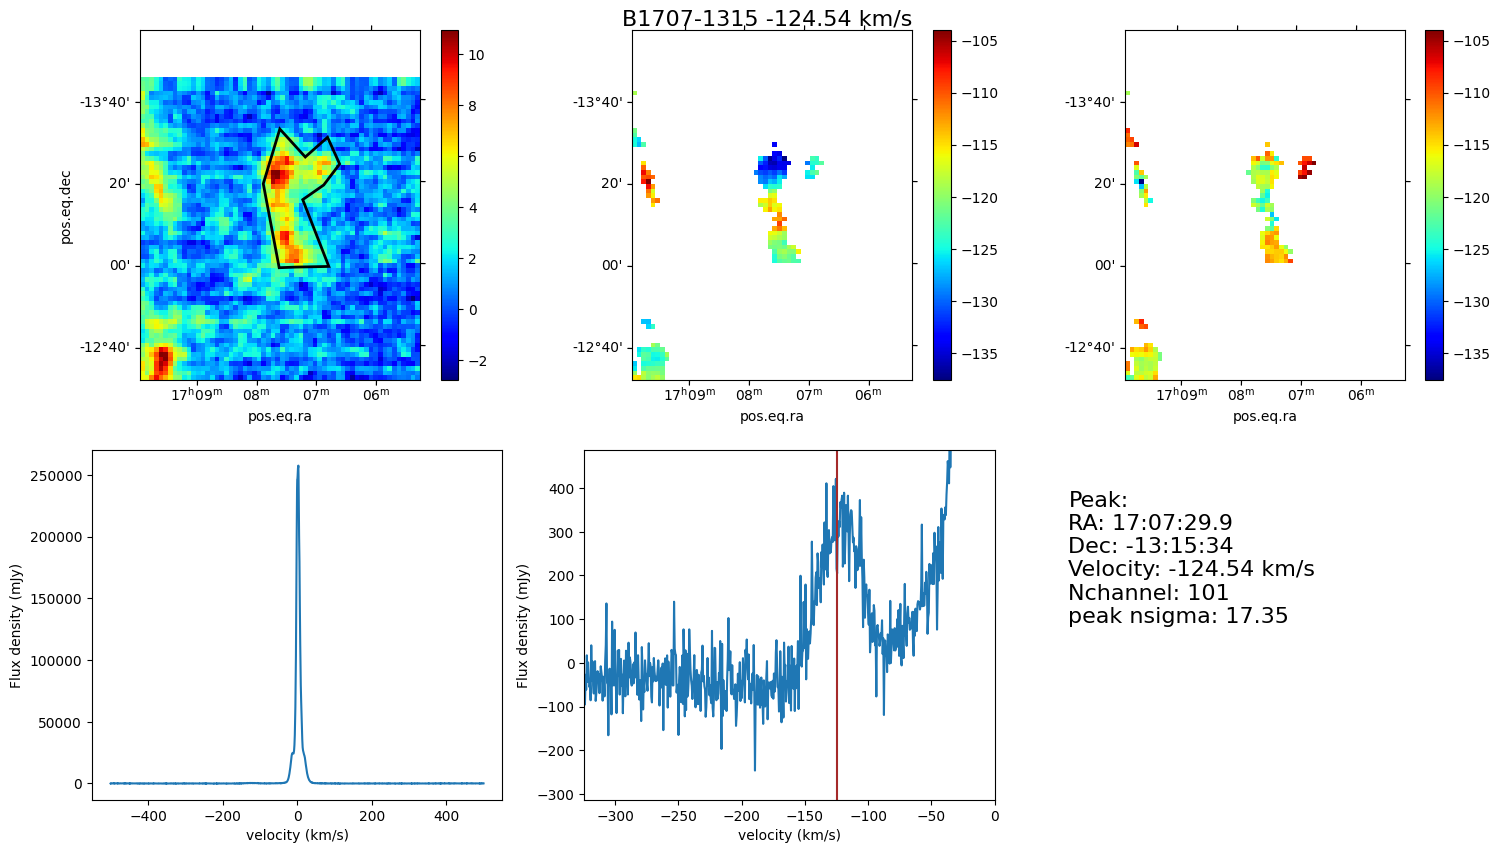

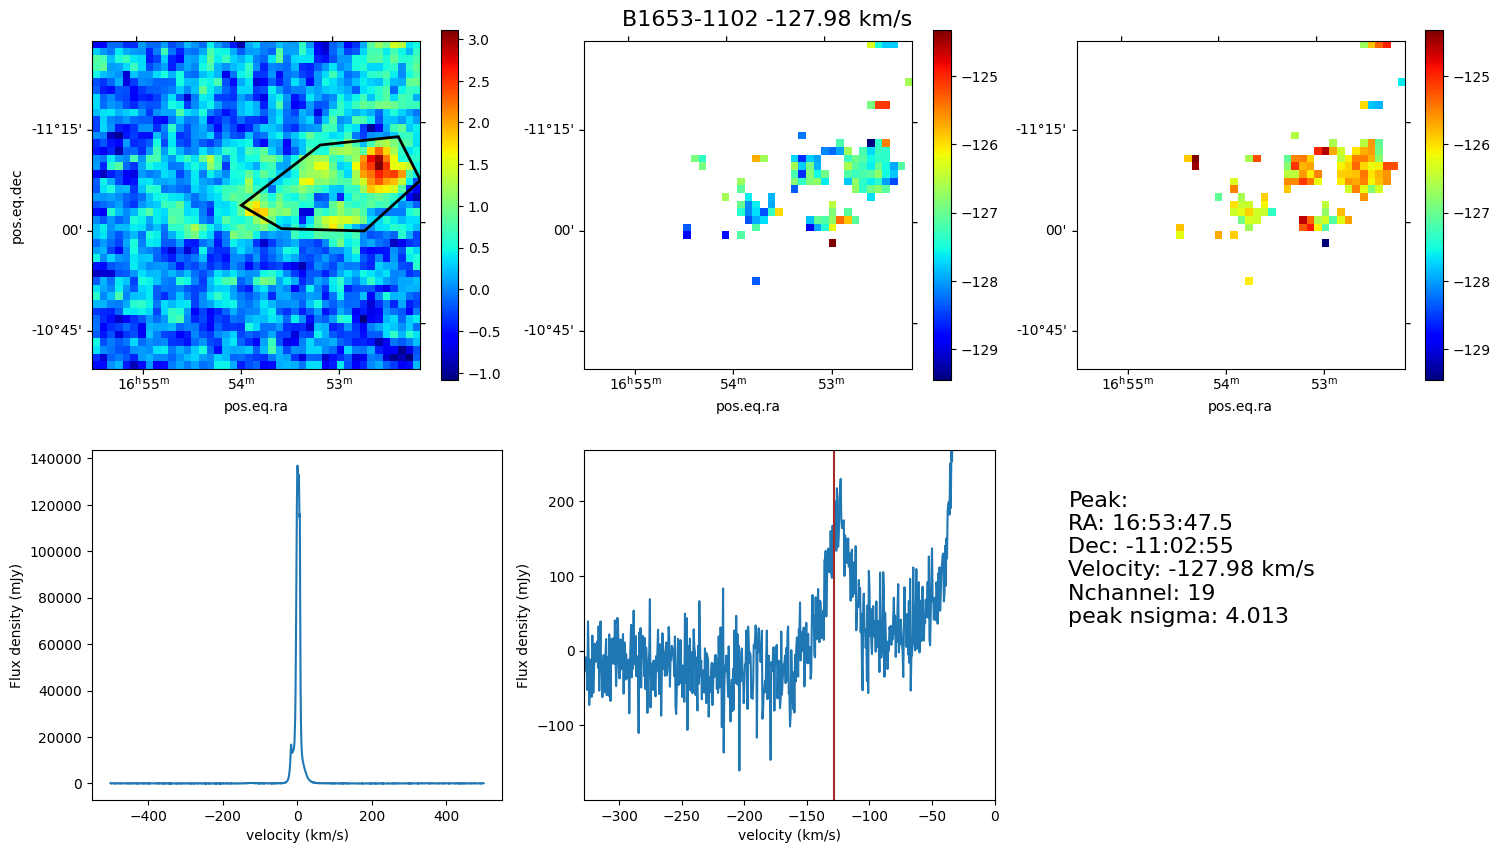

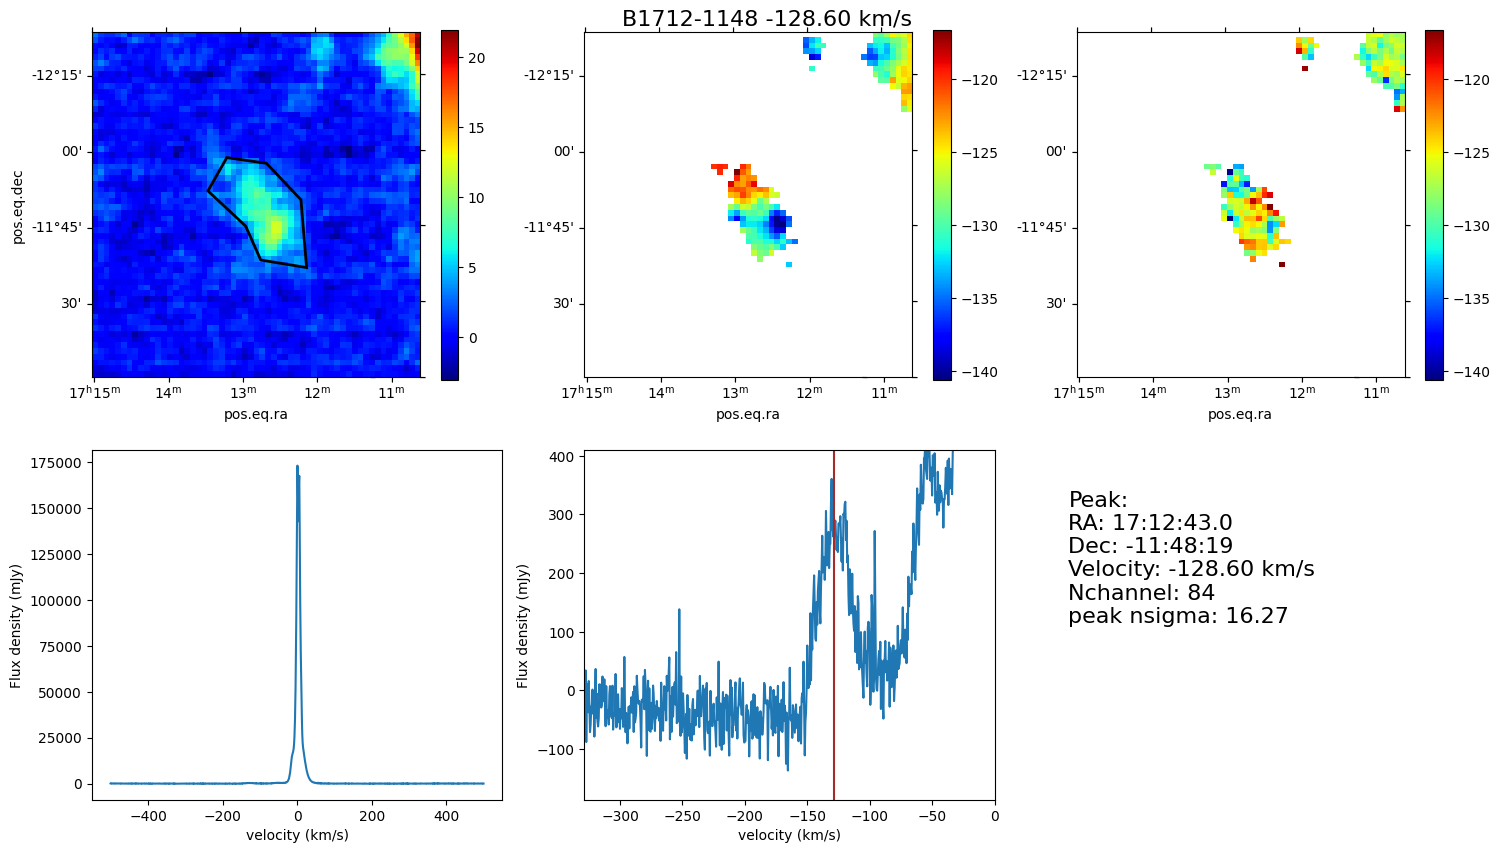

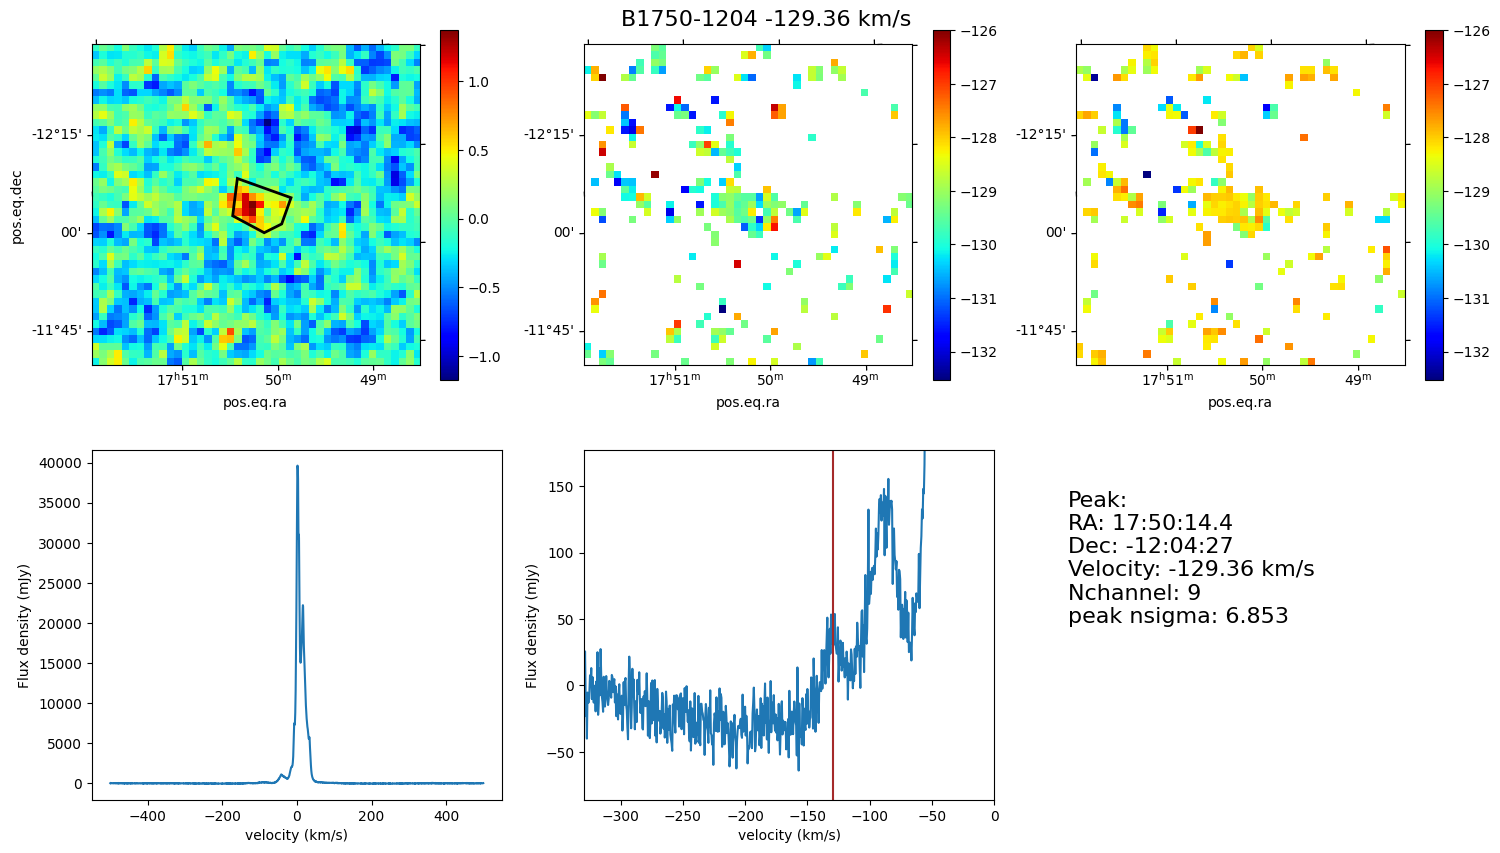

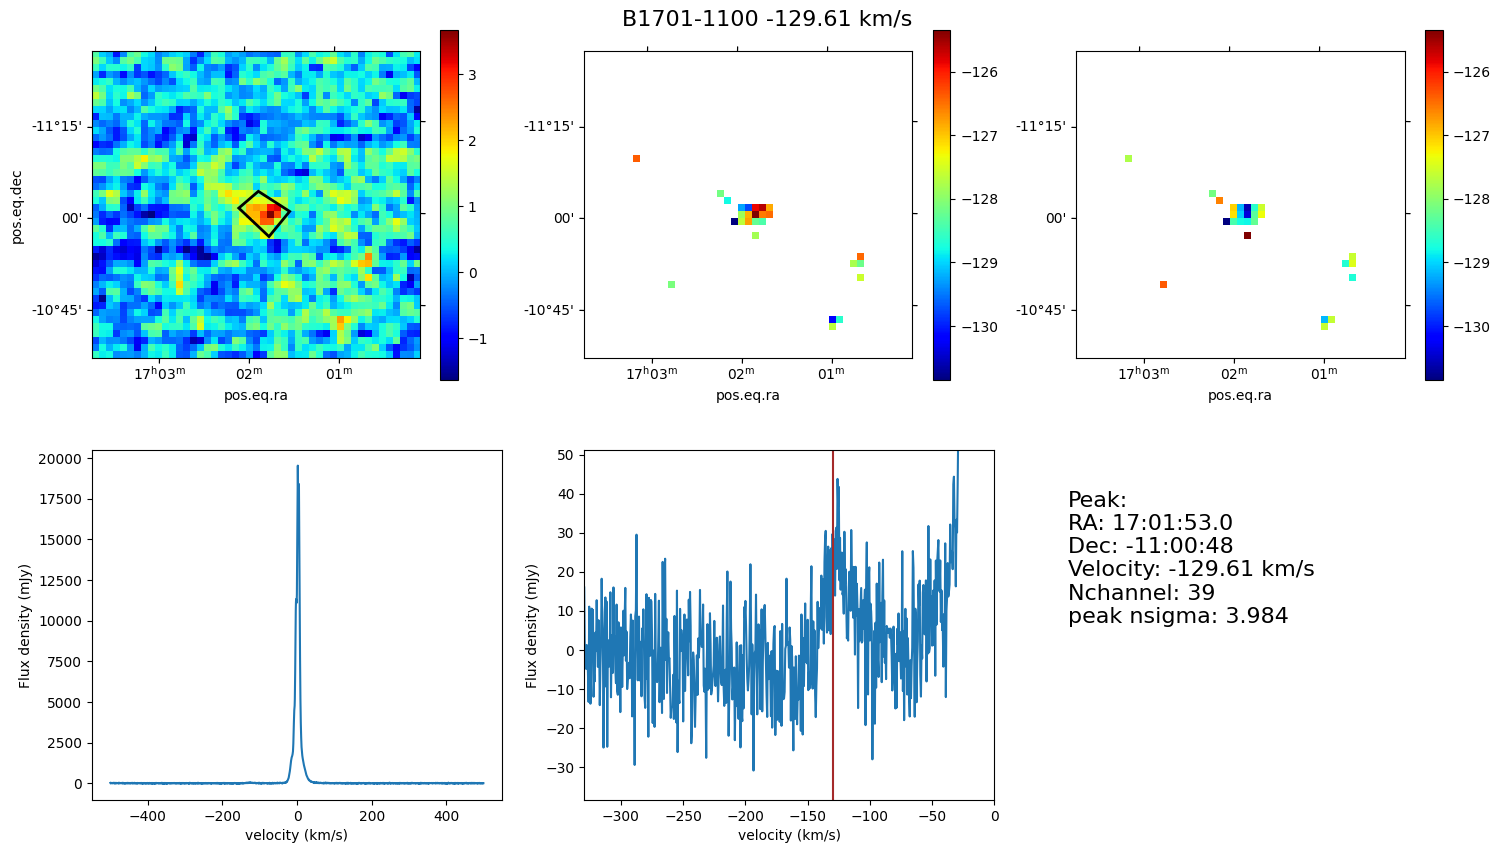

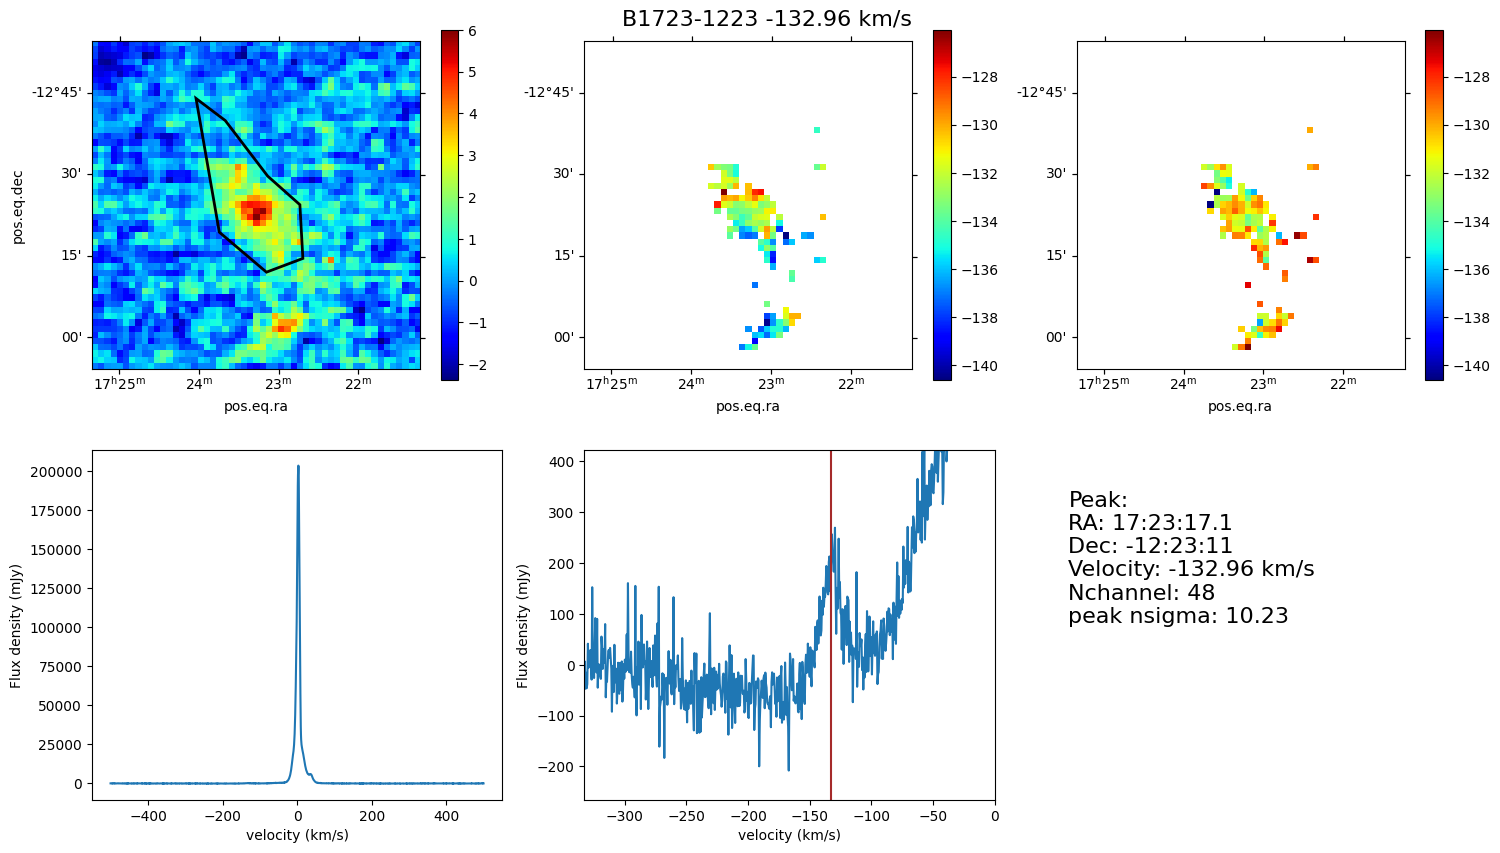

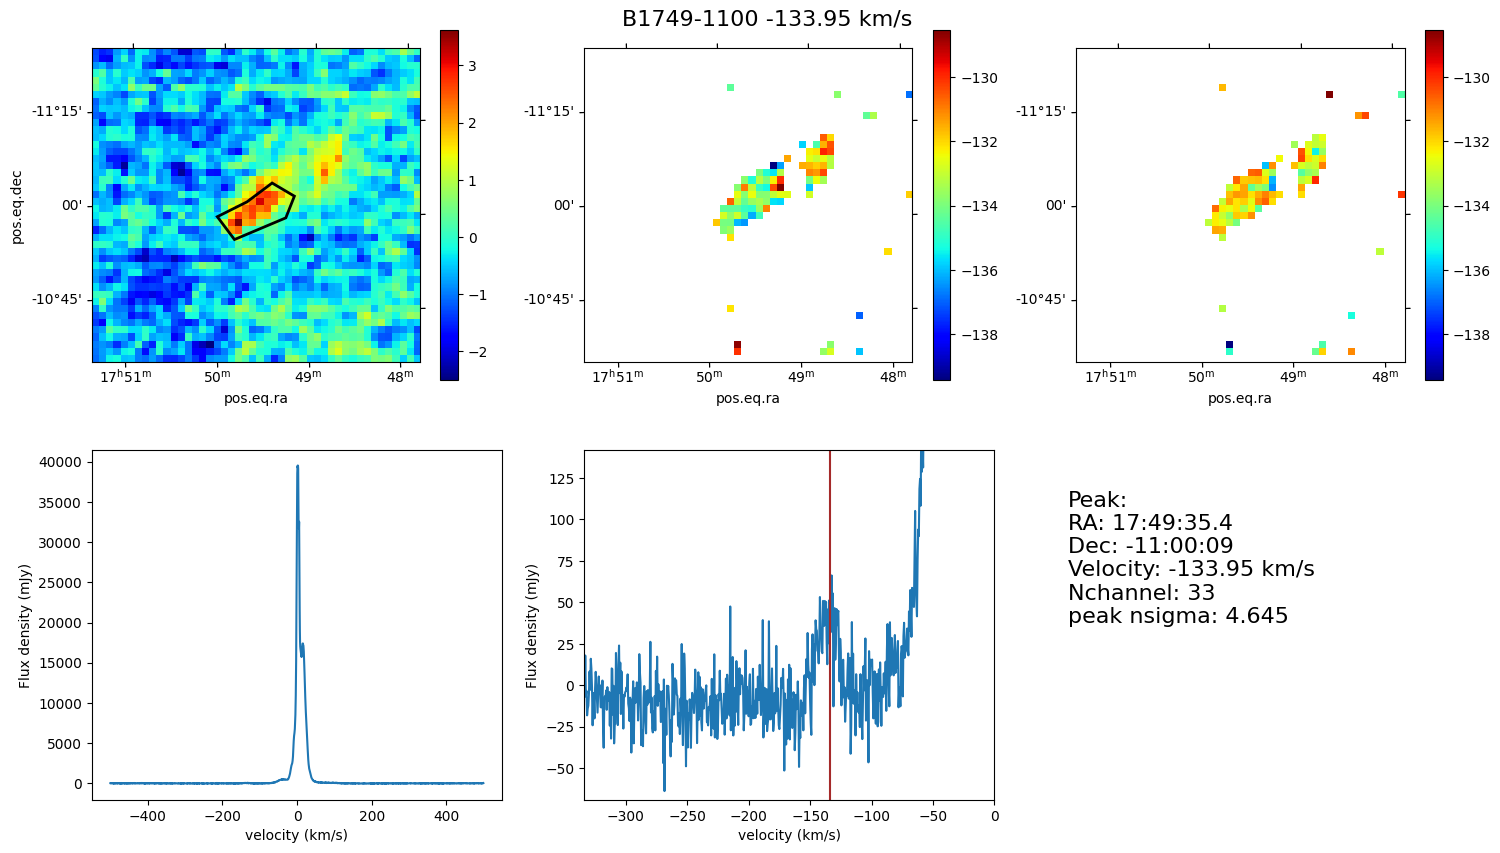

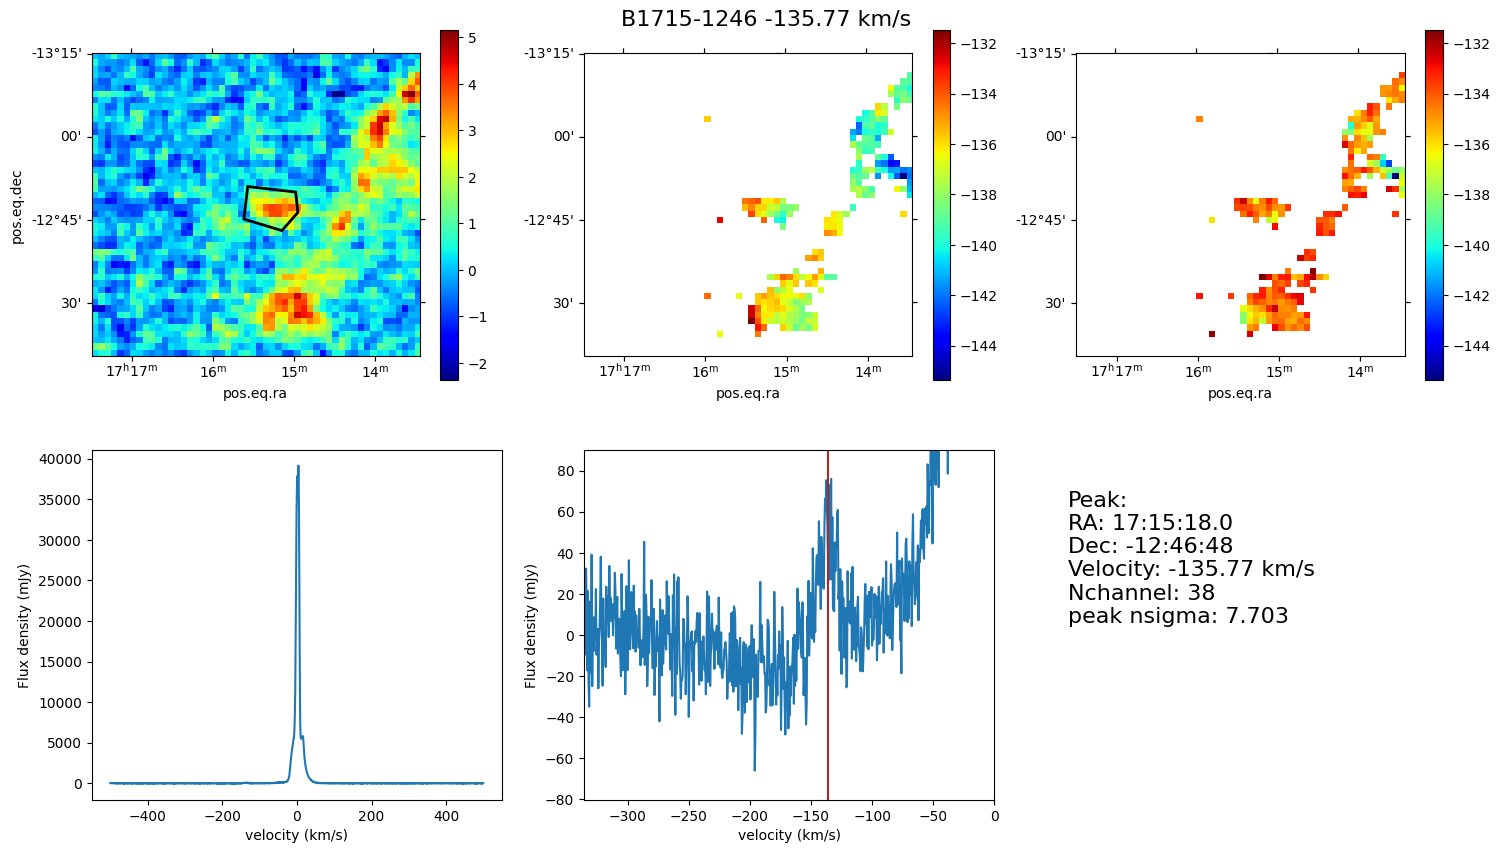

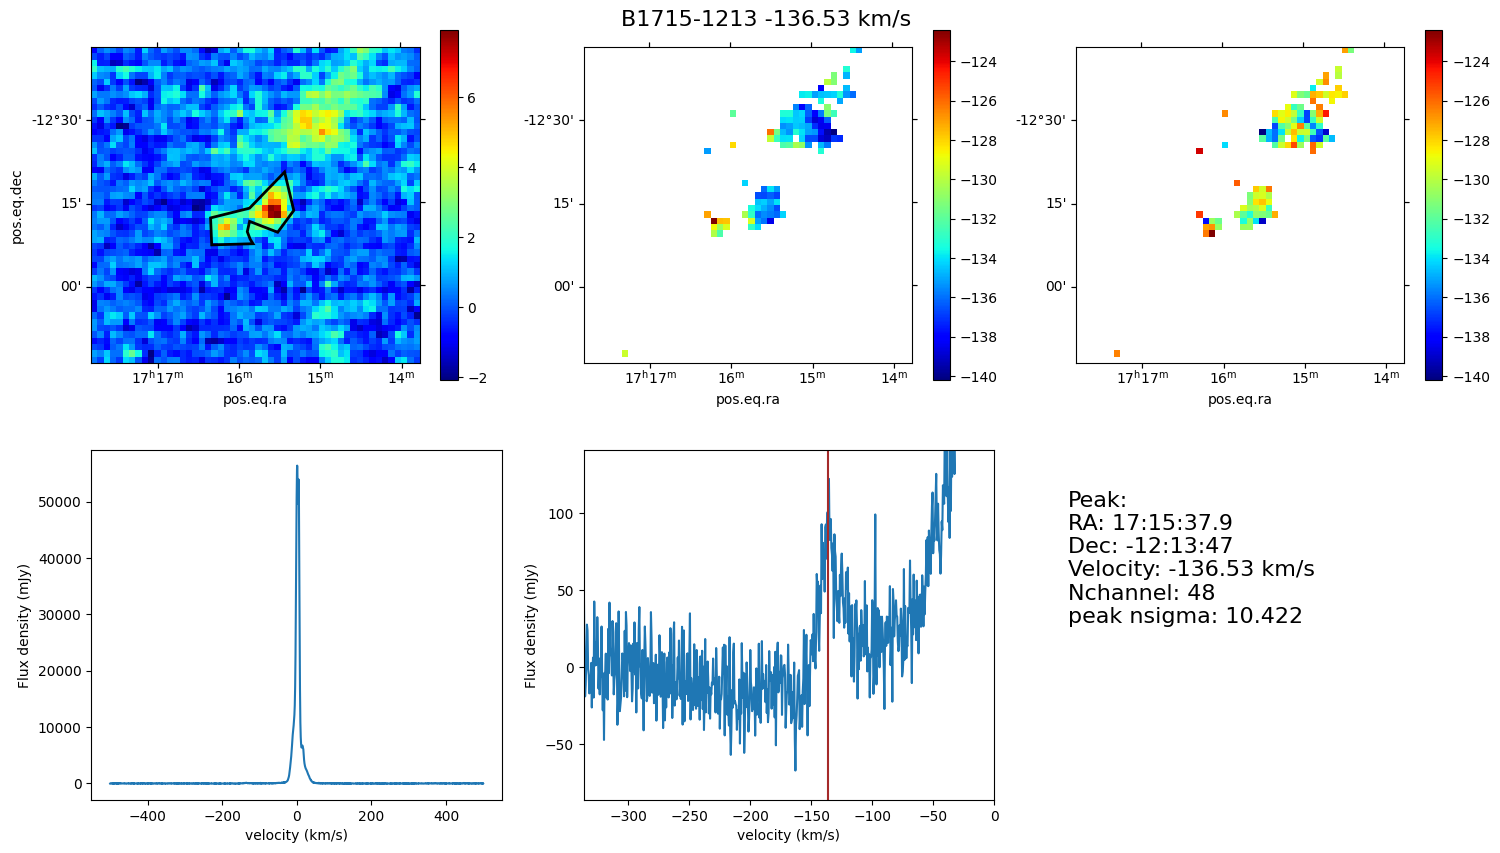

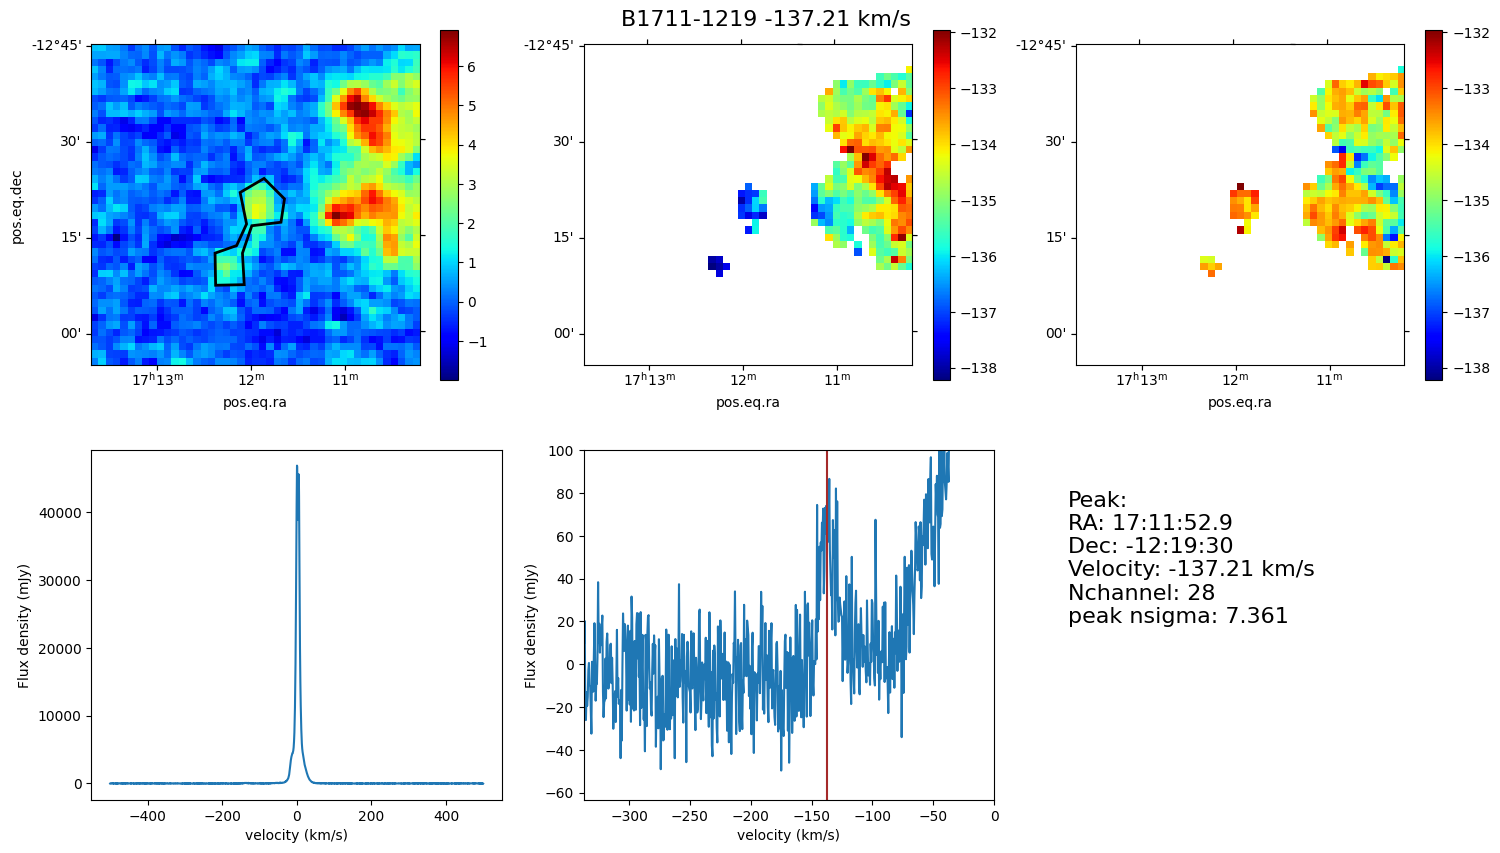

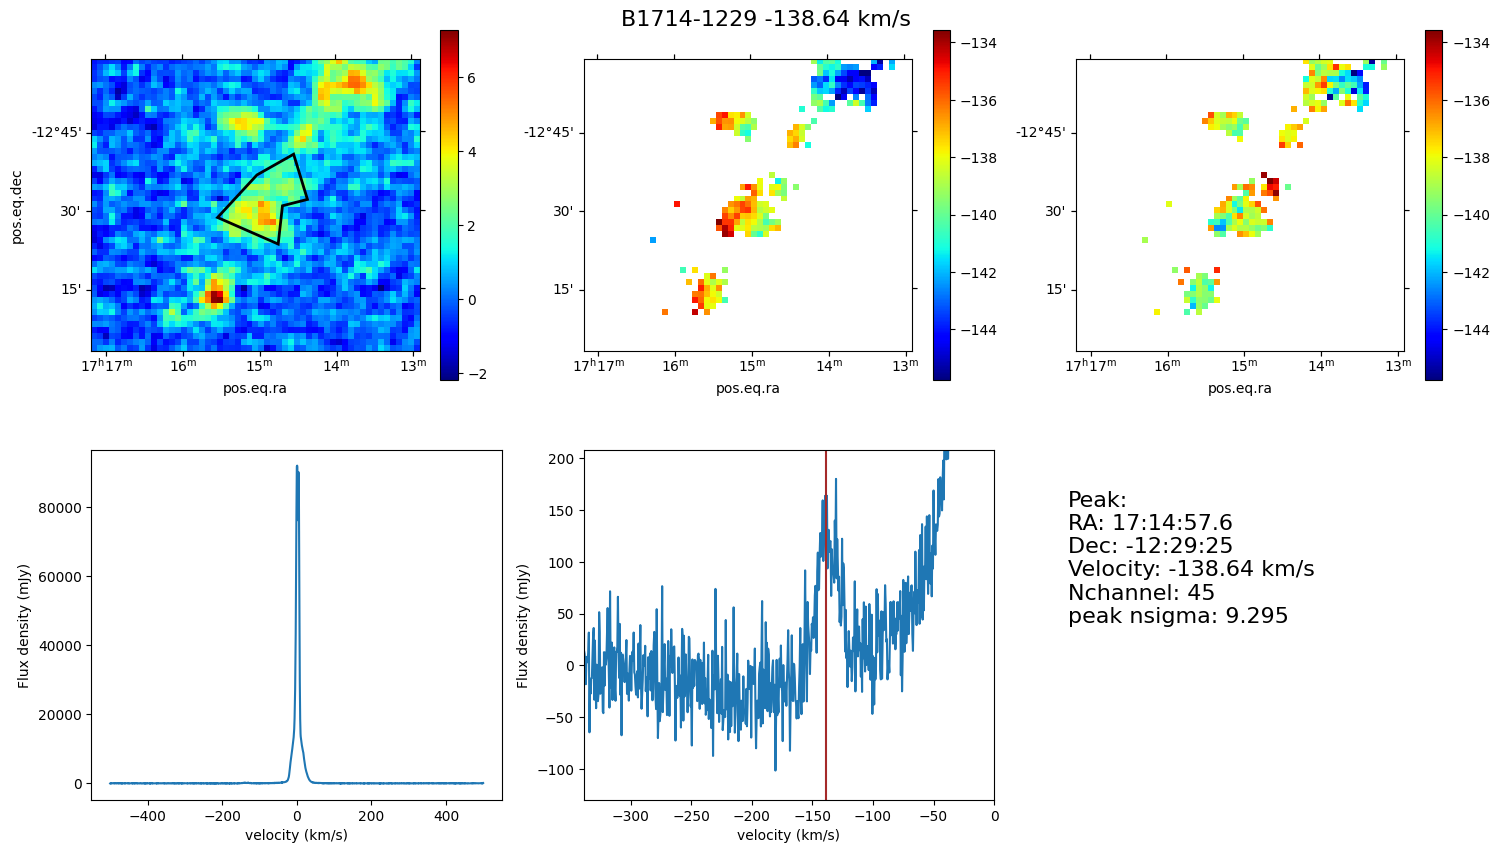

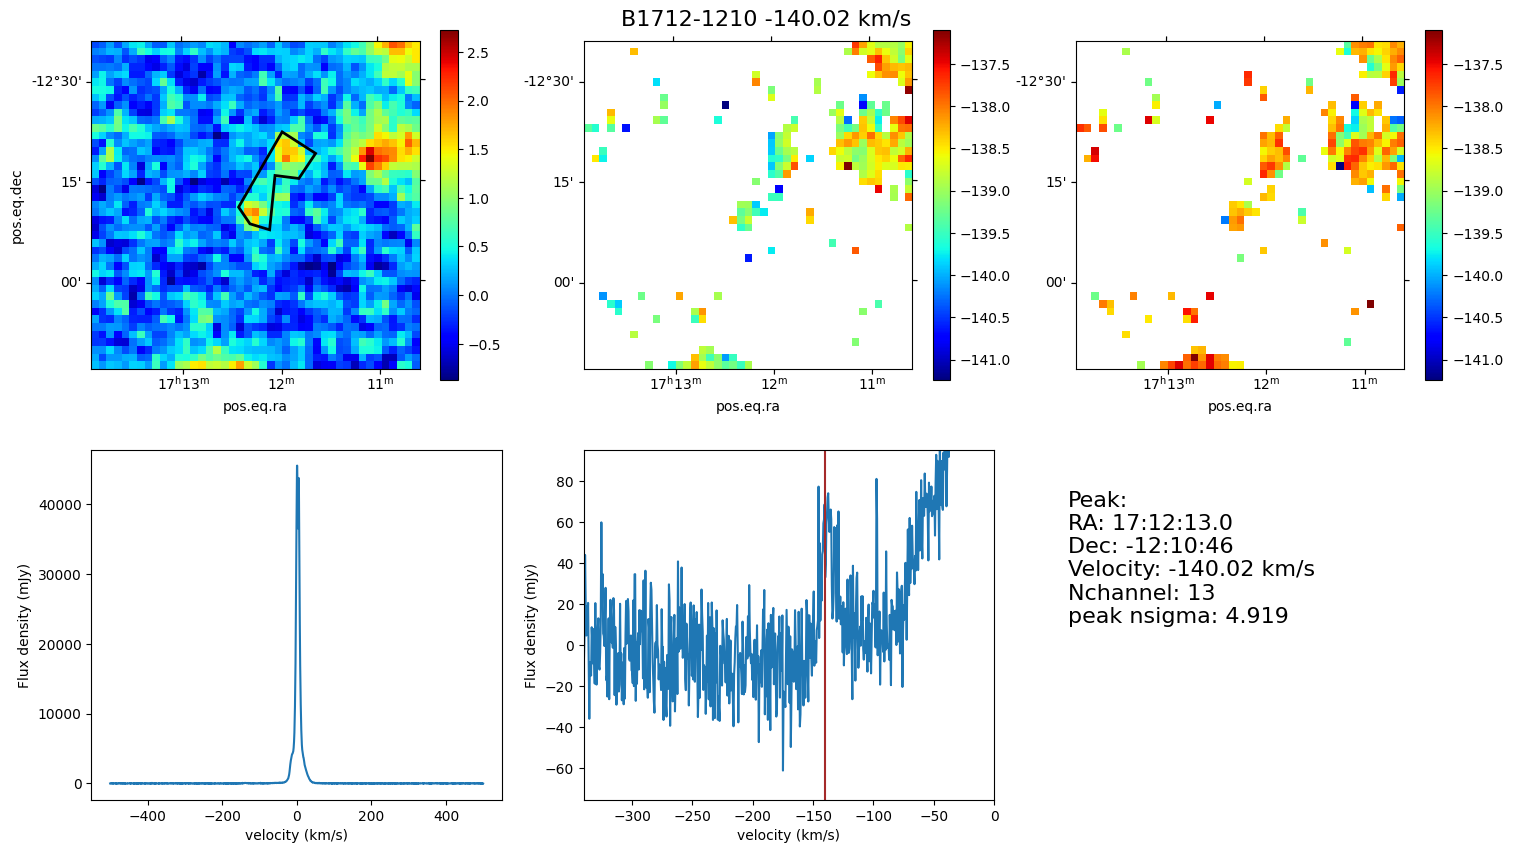

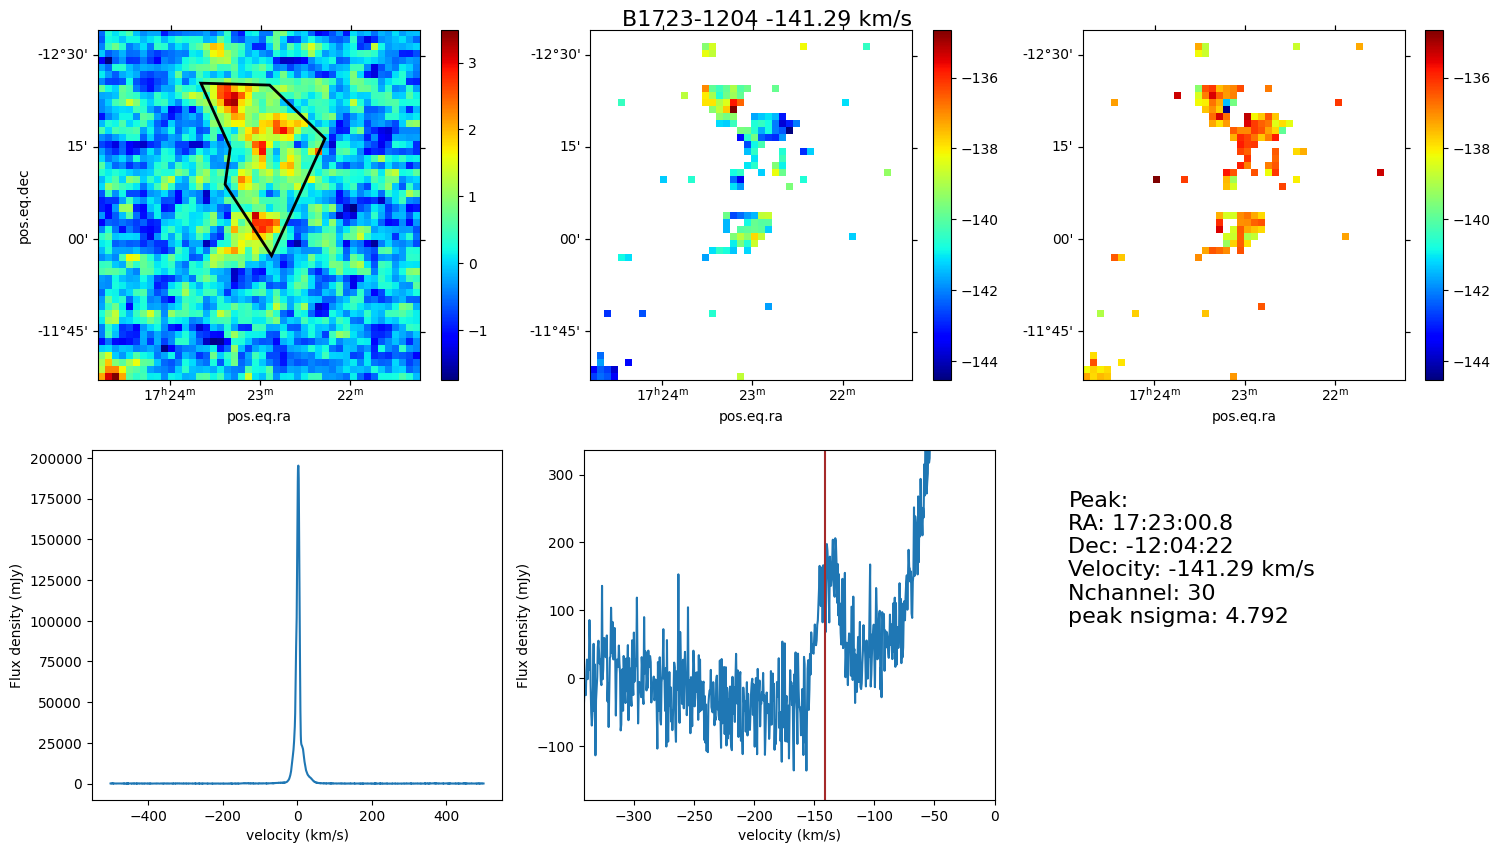

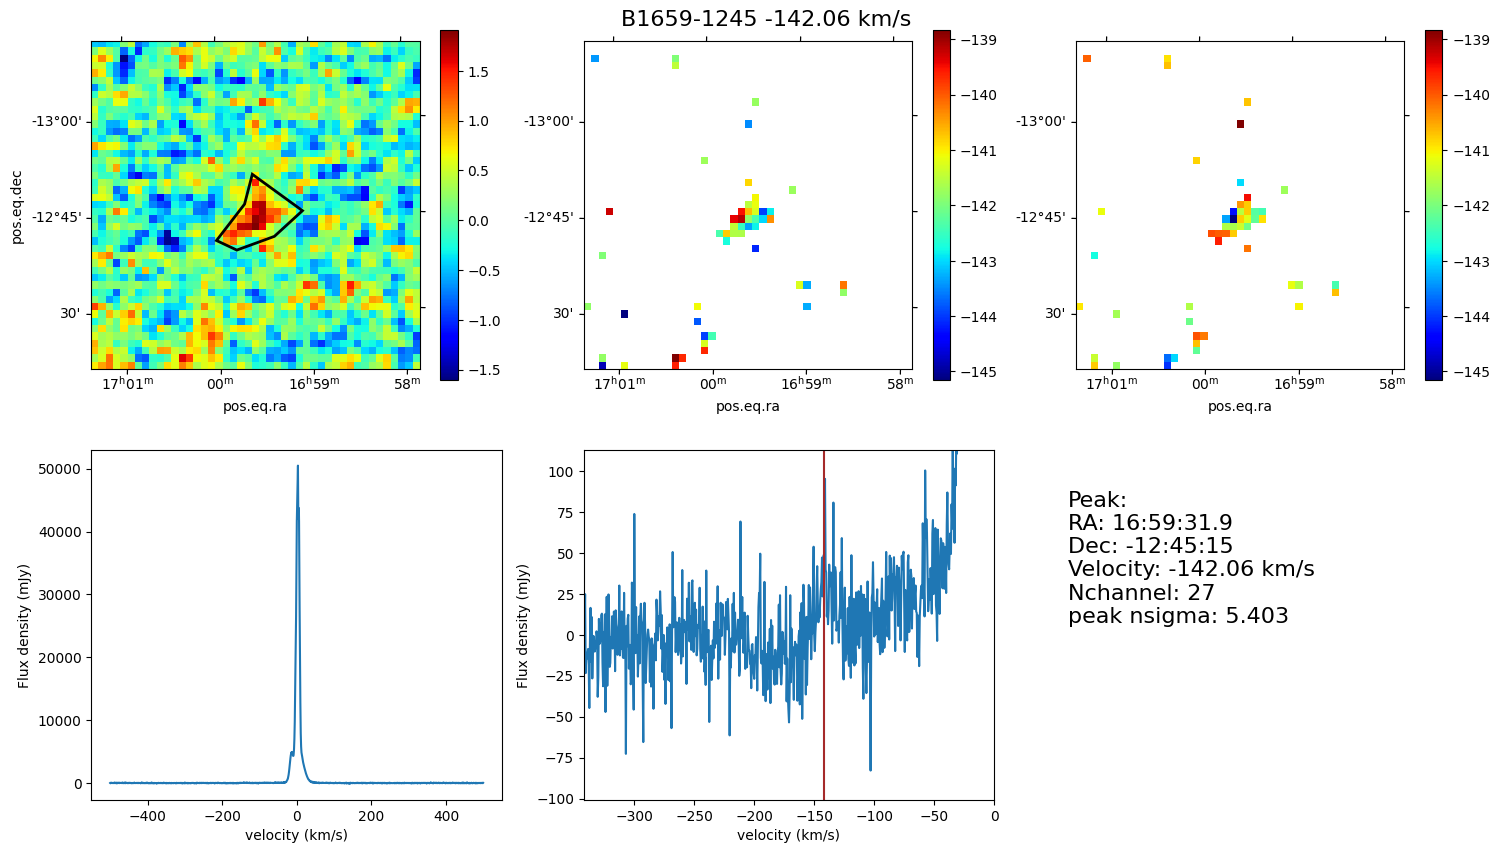

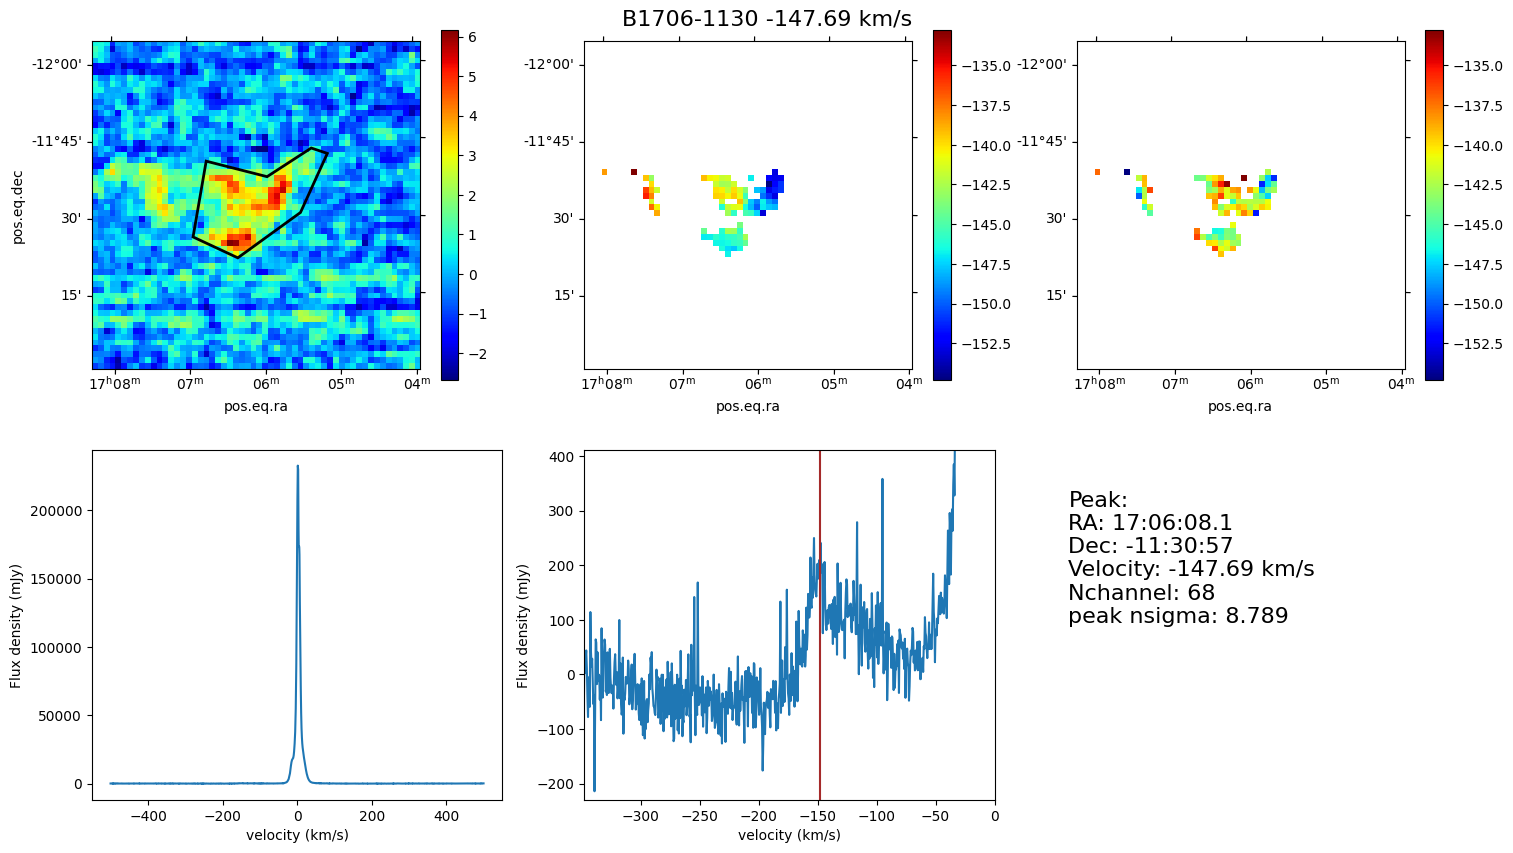

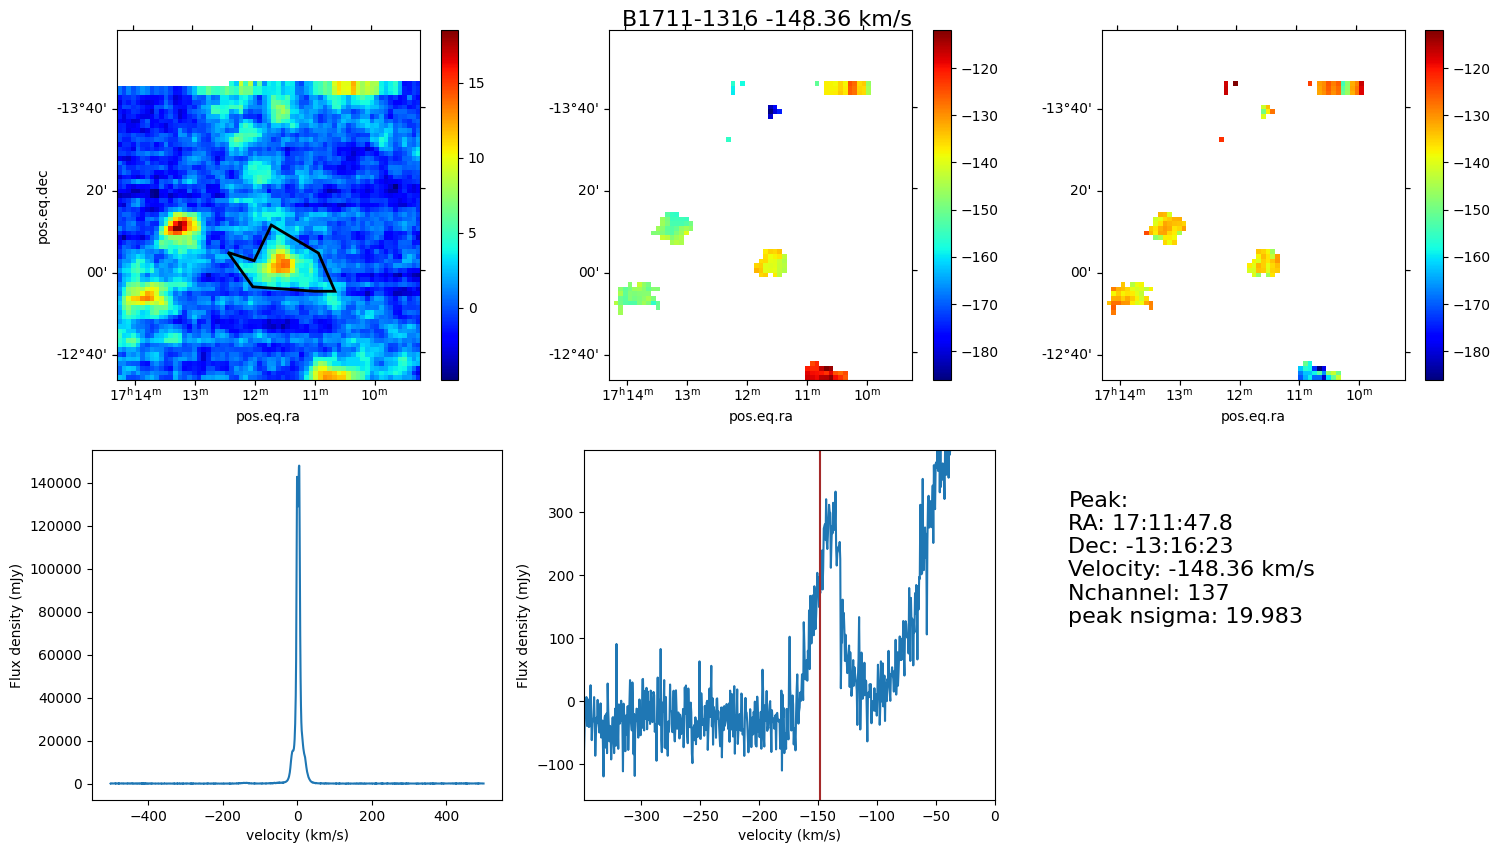

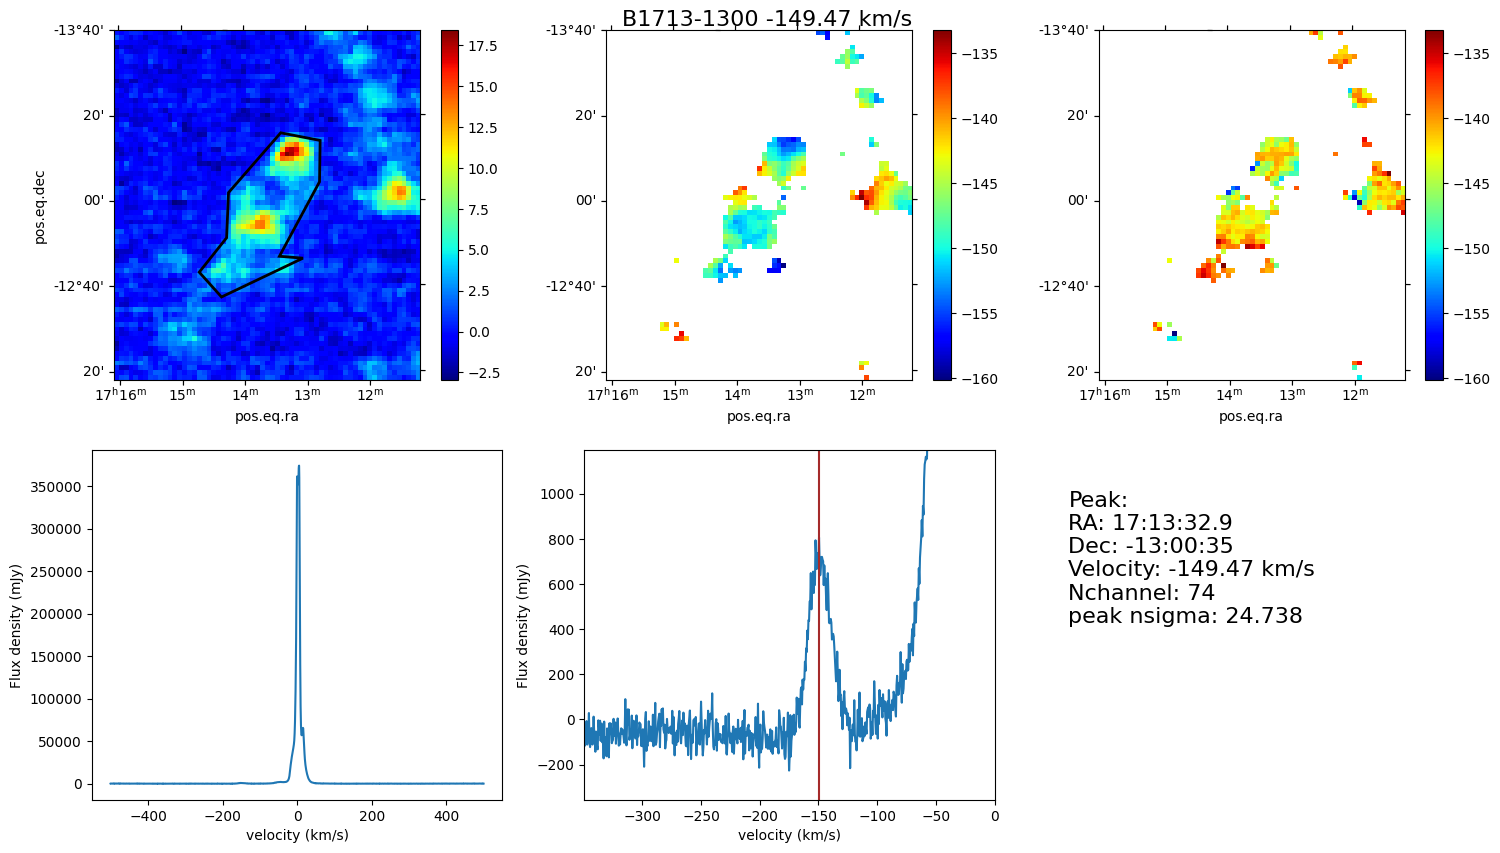

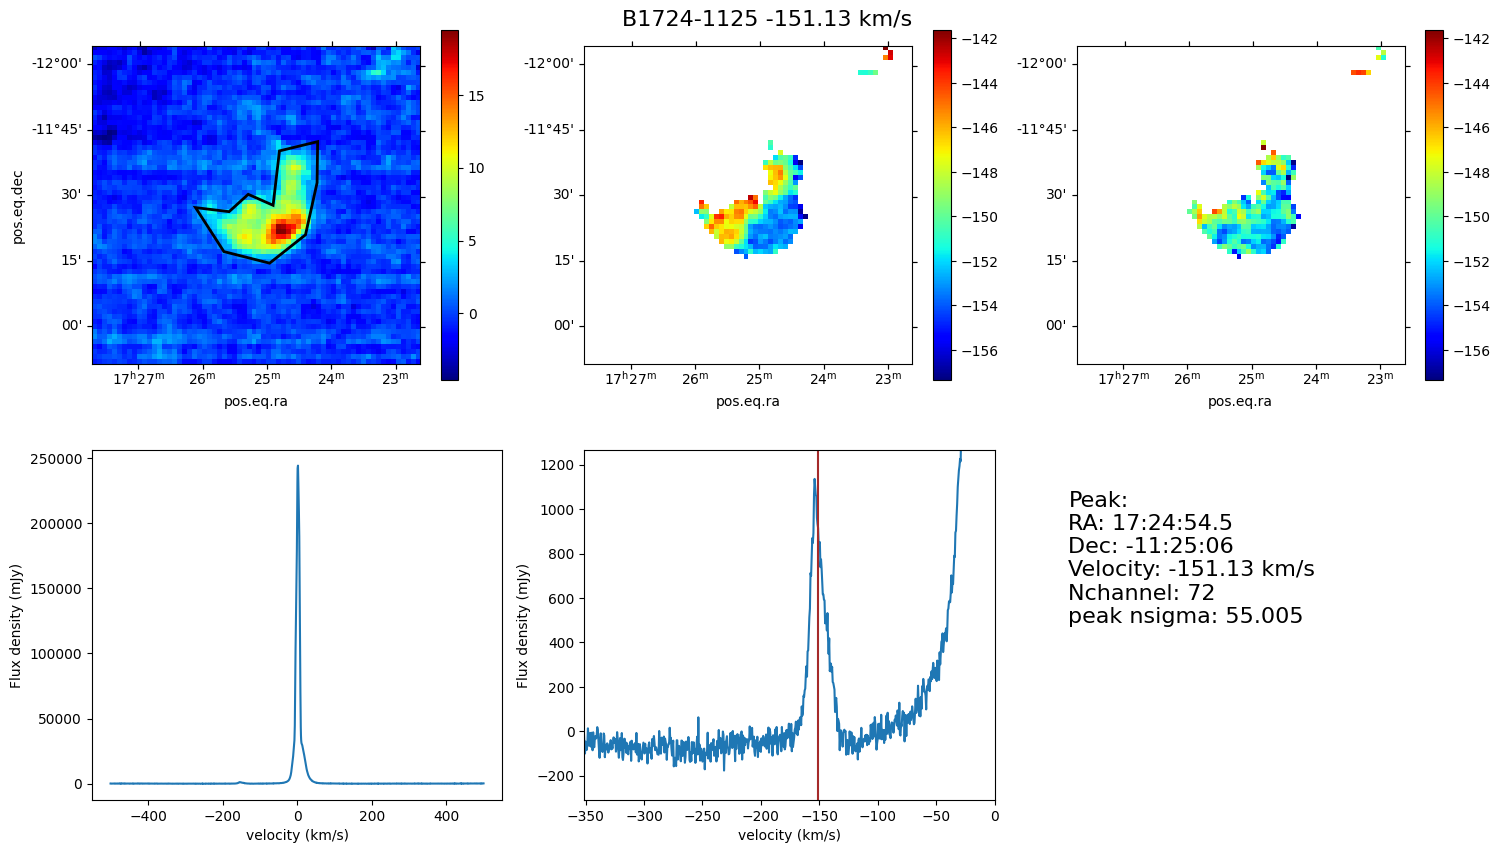

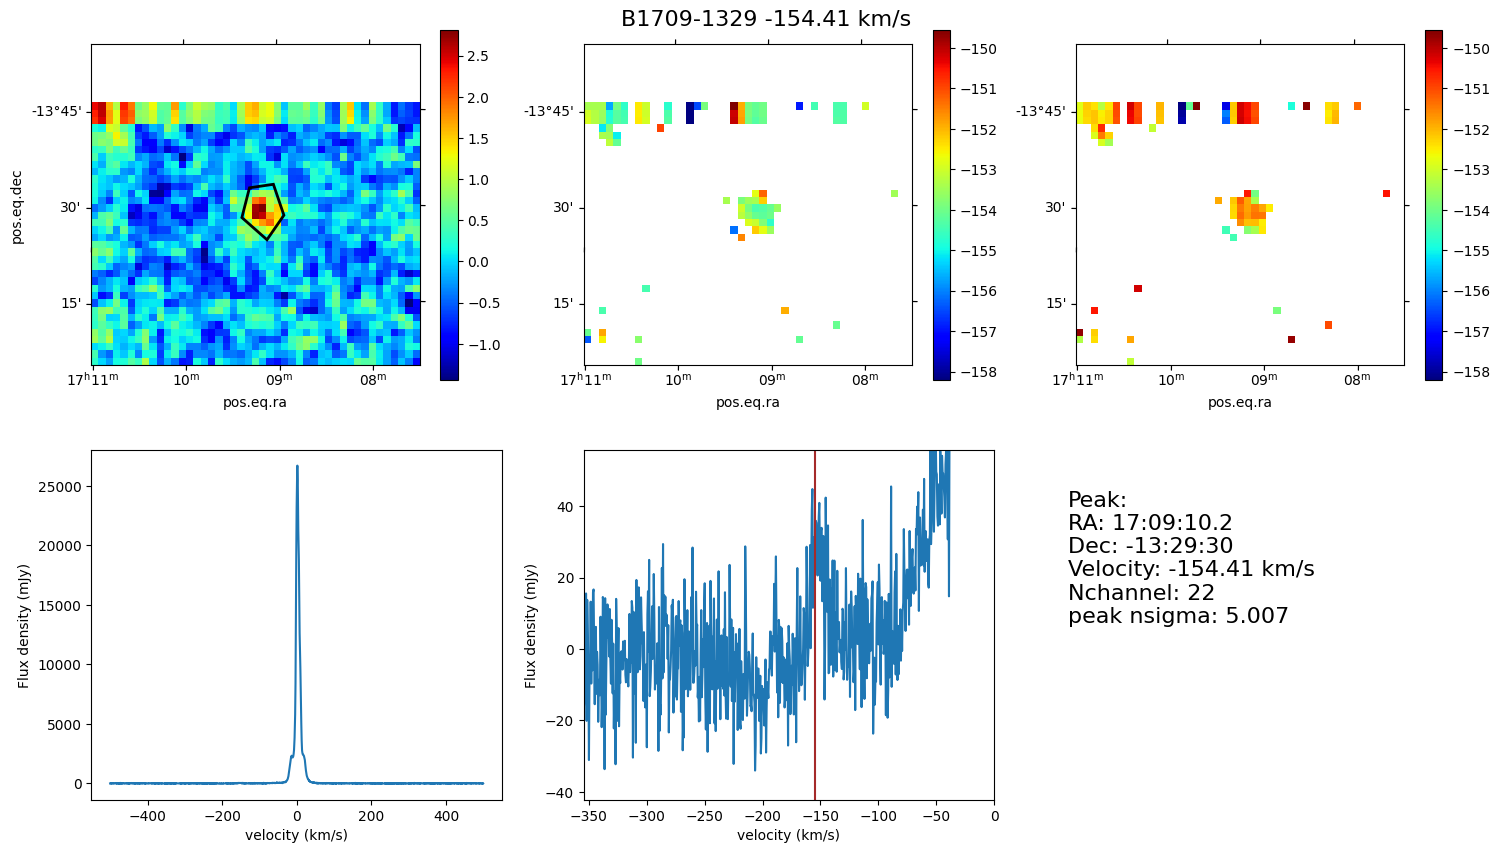

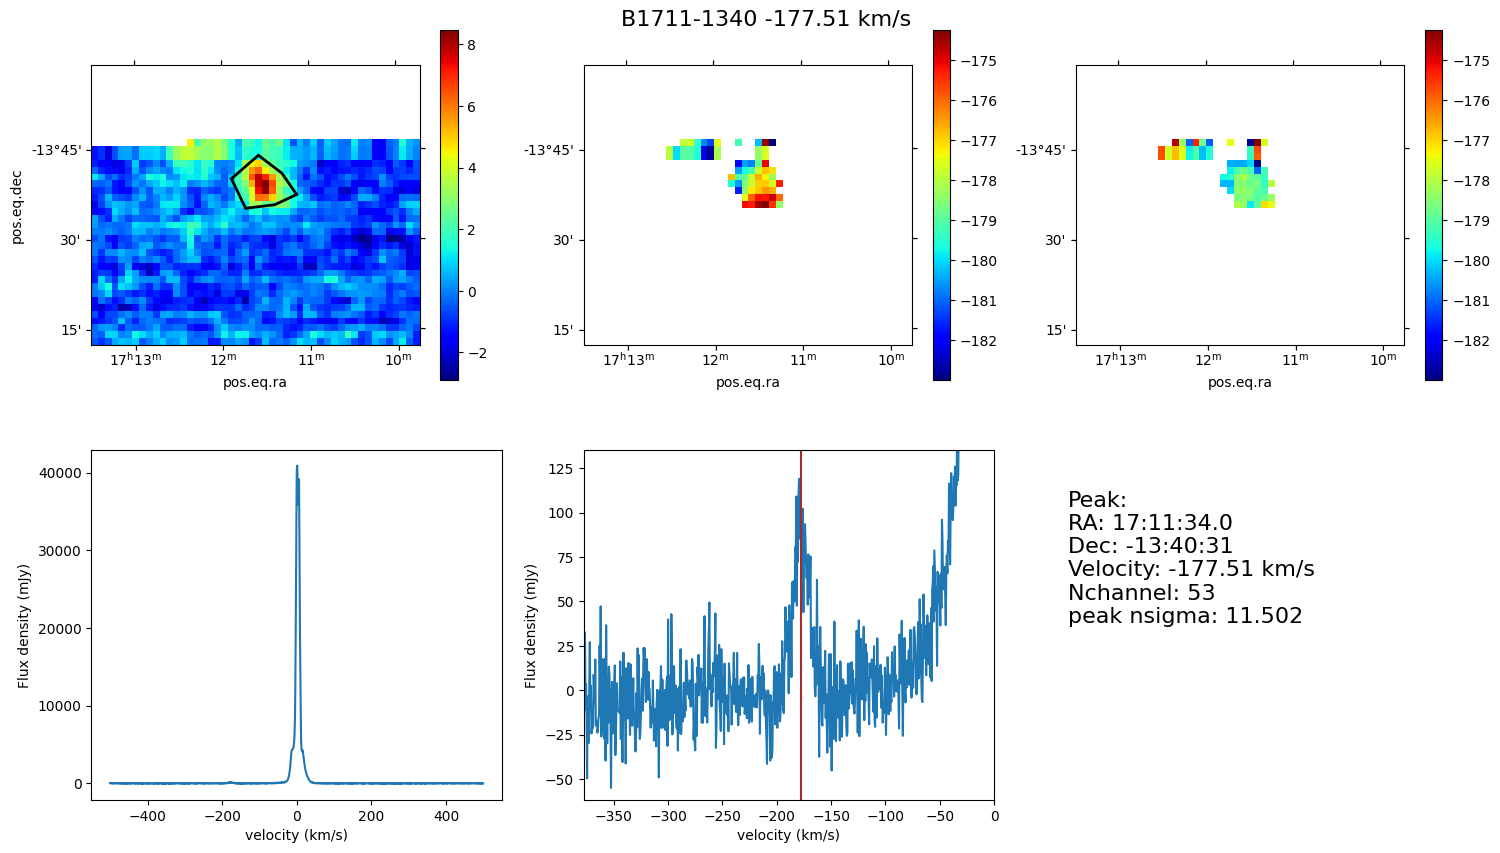

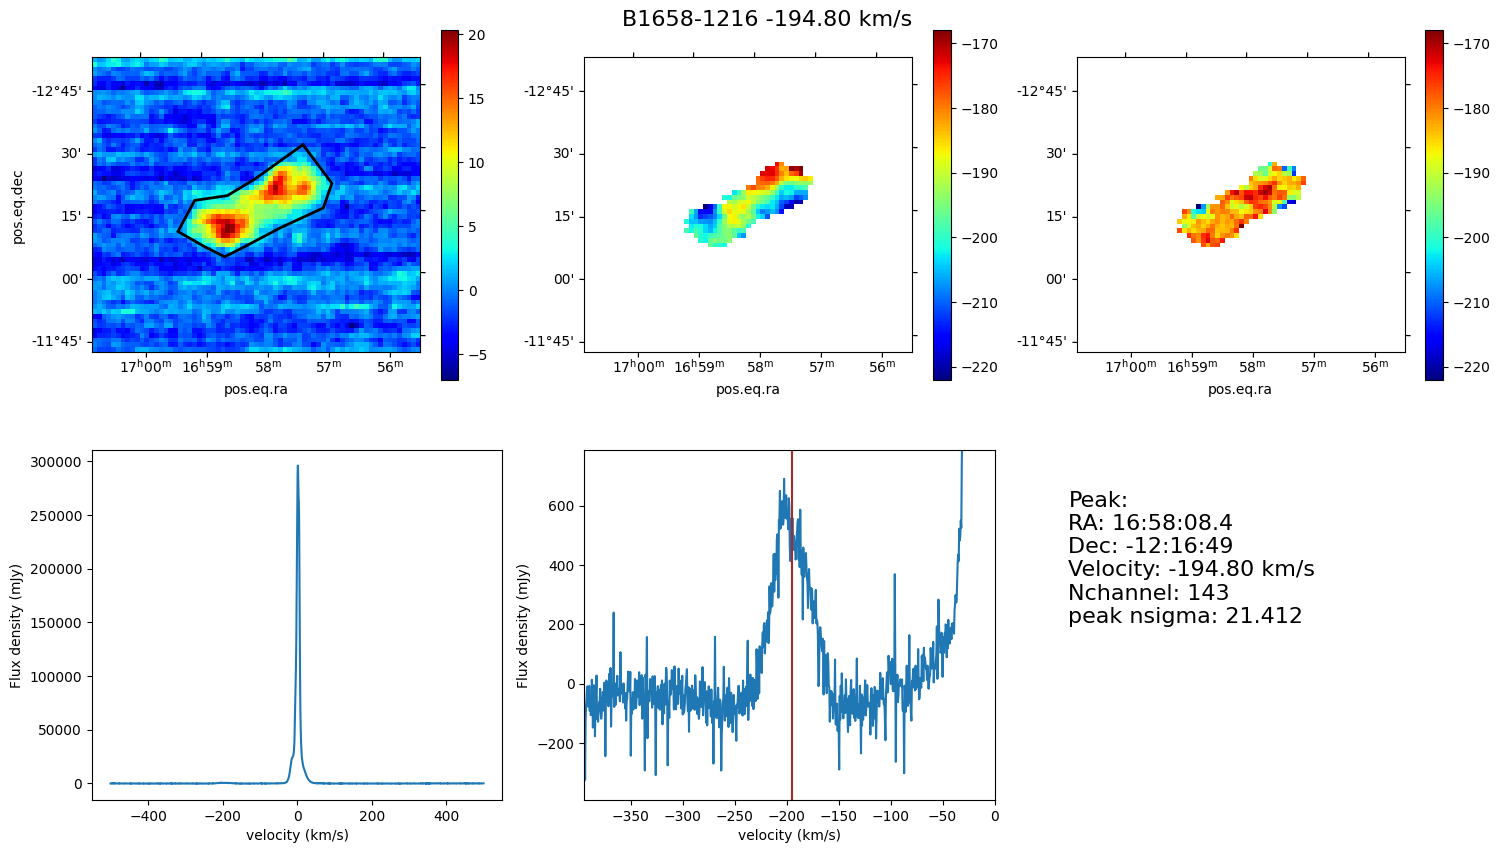

In [11]:
cube=SpectralCube.read('GCHVC_imcontsub_flaged.fits')
vels=(1420405751.768-np.array(cube.spectral_axis))/1420405751.768*299792.458
%matplotlib inline
from regions import PixCoord,PolygonPixelRegion
import warnings
warnings.simplefilter('ignore')
for idx in result_select.index:
    X1,X2=int(result_select['X1'][idx]),int(result_select['X2'][idx])
    Y1,Y2=int(result_select['Y1'][idx]),int(result_select['Y2'][idx])
    Z1,Z2=int(result_select['Z1'][idx]),int(result_select['Z2'][idx])
    Xm,XM=max(0,X1-20),min(cube.shape[2],X2+20)
    Ym,YM=max(0,Y1-20),min(cube.shape[1],Y2+20)
    #Xm,XM=max(0,X1),min(cube.shape[2],X2)
    #Ym,YM=max(0,Y1),min(cube.shape[1],Y2)
    cube_sub=cube[Z1:Z2,Ym:YM,Xm:XM]
    vel=(1420405751.768-float(result_select['FREQ'][idx]))/1420405751.768*299792.458
    print(cube_sub.shape)
    cube_sub=cube_sub.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=1420405751.768*u.Hz)
    mmt0=cube_sub.with_spectral_unit(u.km/u.s).moment(order=0)
    mmt1=cube_sub.with_spectral_unit(u.km/u.s).moment(order=1)
    mmt2=cube_sub.with_spectral_unit(u.km/u.s).moment(order=2)
    m0cu=mmt0.hdu.data
    hispix=m0cu-np.nanmean(m0cu)>0.04*(Z2-Z1)
    mmt1.hdu.data[~hispix]=np.nan
    mmt2.hdu.data[~hispix]=np.nan
    fig=plt.figure(figsize=[18,10])
    line1='Peak:\n'
    line2='RA: %s\n'%(result_select['RA'][idx])
    line3='Dec: %s\n'%(result_select['DEC'][idx])
    line4='Velocity: %.2f km/s\n'%vel
    line5='Nchannel: %s\n'%(result_select['Nchan'][idx])
    line6='peak nsigma: %s\n'%(result_select['S/Nmax'][idx])
    plt.text(0.7,0.2,line1+line2+line3+line4+line5+line6,fontsize=16)
    plt.axis('off')
    fig.suptitle(result_select['Name'][idx]+' %.2f km/s'%vel,x=0.5,y=0.9,fontsize=16)
    ax=fig.add_subplot(231,projection=mmt0.wcs)
    regs=regions.Regions.read('sub_fits/%s_region.crtf'%(result_select['Name'][idx]))
    im=ax.imshow(mmt0.hdu.data,cmap='jet')
    fig.colorbar(im)
    reg_plot = PolygonPixelRegion(vertices=regs[0].to_pixel(mmt0.wcs).vertices)
    patch = reg_plot.plot(ax=ax, facecolor='none', edgecolor='k', lw=2, label='Polygon')
    ax.invert_yaxis()
    ax=fig.add_subplot(232,projection=mmt1.wcs)
    im=ax.imshow(mmt1.hdu.data,cmap='jet')
    fig.colorbar(im)
    ax.invert_yaxis()
    ax.set_ylabel('_',alpha=0)
    ax=fig.add_subplot(233,projection=mmt2.wcs)
    fig.colorbar(im)
    im=ax.imshow(mmt2.hdu.data,cmap='jet')
    ax.invert_yaxis()
    ax.set_ylabel('_',alpha=0)
    factor=1.222e3/1420405751.768e-9**2/abs(cube.header['cdelt1']*cube.header['cdelt2'])/3600**2
    spec=cube.subcube_from_regions(regs).sum(axis=(1,2))/factor
    ax=fig.add_subplot(234)
    ax.plot(vels,spec)
    plt.xlabel('velocity (km/s)')
    plt.ylabel('Flux density (mJy)')
    ax=fig.add_subplot(235)
    if vel>0:
        slices=(vels>=max(vel-100,60))*(vels<=vel+100)
    else:
        slices=(vels>=vel-100)*(vels<=min(vel+100,-60))
    #ax.plot(vels[slices],spec[slices])
    ax.plot(vels,spec)
    m=min(spec[slices]).value
    M=max(spec[slices]).value
    ax.set_ylim(1.1*m-0.1*M,1.1*M-0.1*m)
    if vel>0:
        ax.set_xlim(0,vel+200)
    else:
        ax.set_xlim(vel-200,0)
    ax.axvline(vel,c='brown')
    plt.xlabel('velocity (km/s)')
    plt.ylabel('Flux density (mJy)')
    plt.savefig('figs/%s_moments_selected.pdf'%(result_select['Name'][idx]))
    mmt0[~hispix]=np.nan
    mmt0.hdu.writeto('sub_fits/%s_moment0.fits'%(result_select['Name'][idx]),overwrite=True)
    mmt1[~hispix]=np.nan
    mmt1.hdu.writeto('sub_fits/%s_moment1.fits'%(result_select['Name'][idx]),overwrite=True)
    cube_sub.hdu.writeto('sub_fits/%s_sub.fits'%(result_select['Name'][idx]),overwrite=True)

(52, 48, 54)
(93, 45, 55)
(60, 63, 55)
(29, 43, 46)
(107, 132, 98)
(22, 44, 46)
(141, 65, 66)
(23, 43, 43)
(21, 44, 44)
(55, 54, 54)
(100, 75, 60)
(18, 43, 43)
(83, 60, 57)
(8, 43, 44)
(38, 44, 47)
(47, 53, 53)
(32, 44, 46)
(37, 48, 52)
(55, 50, 52)
(27, 44, 45)
(44, 49, 55)
(12, 43, 43)
(29, 50, 46)
(26, 45, 45)
(67, 56, 56)
(136, 75, 65)
(73, 72, 63)
(71, 64, 66)
(21, 44, 45)
(52, 41, 48)
(142, 62, 69)


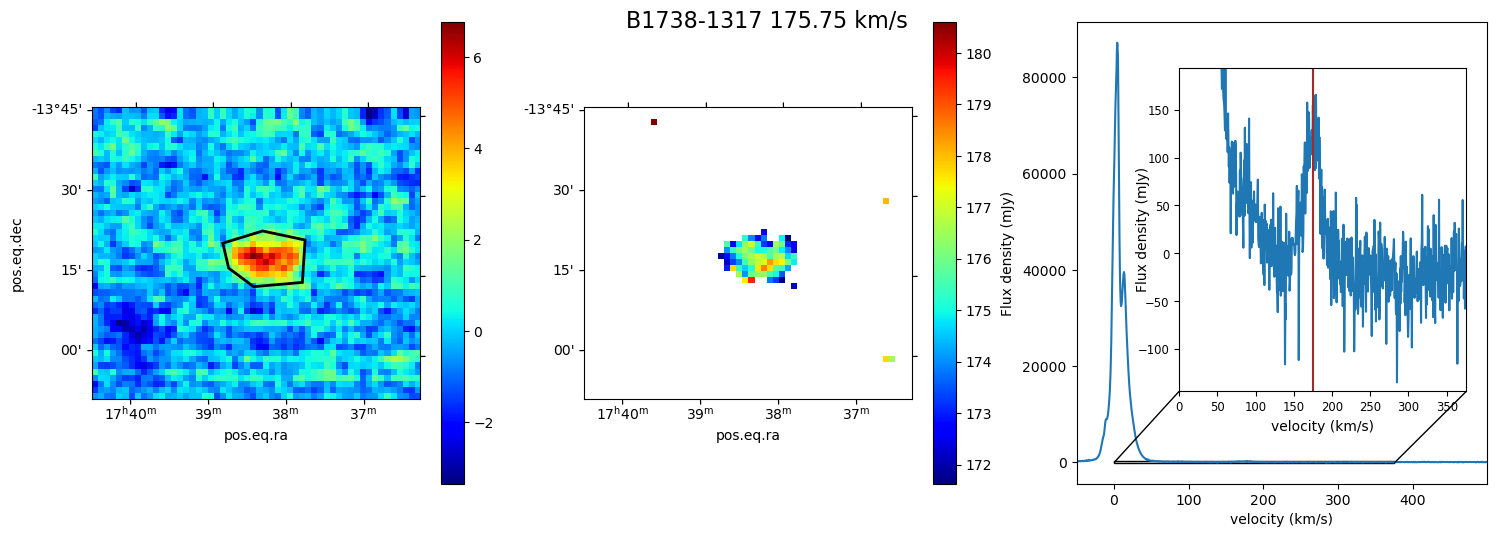

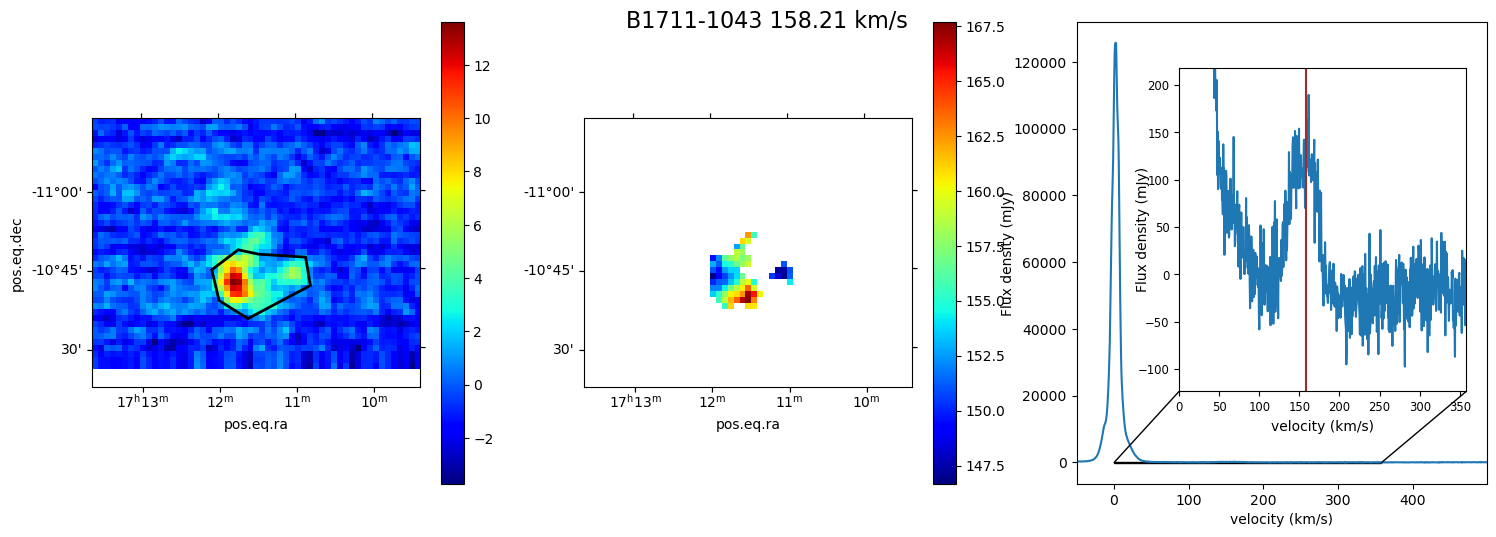

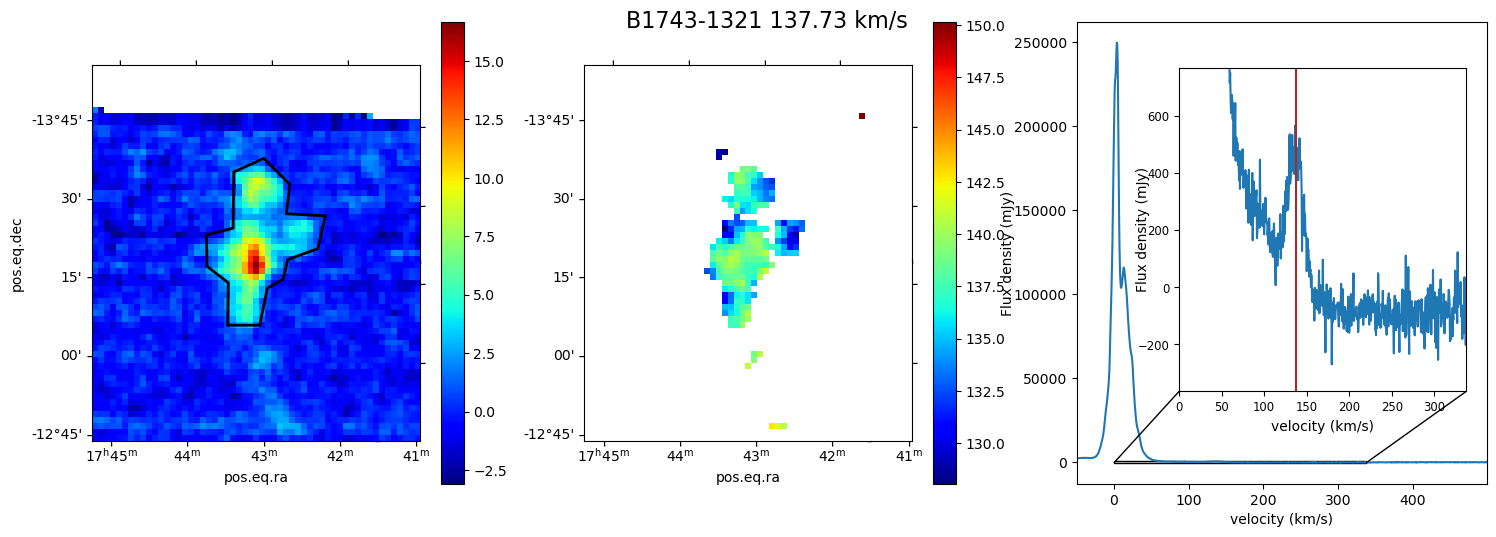

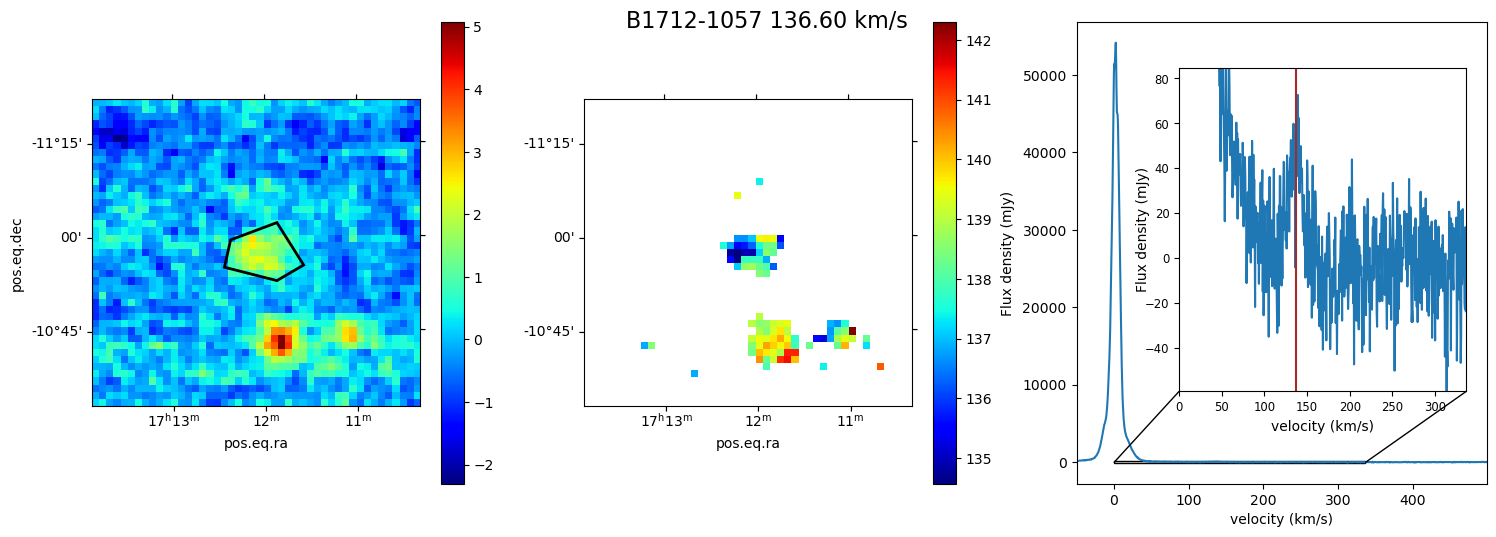

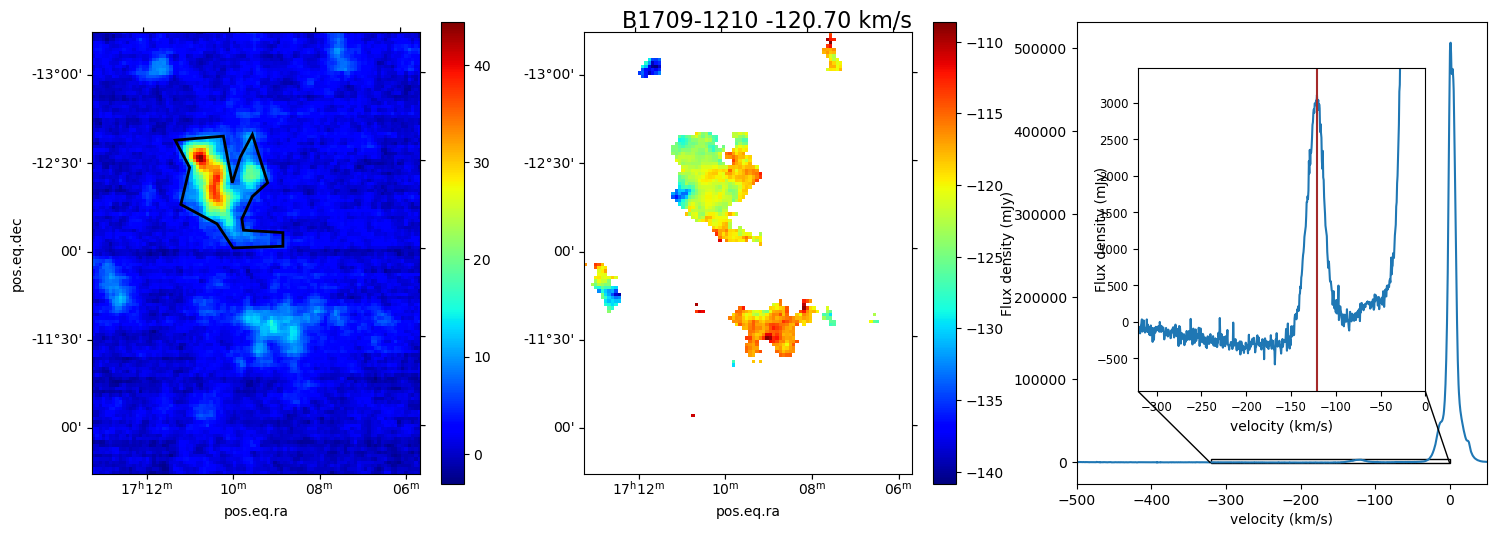

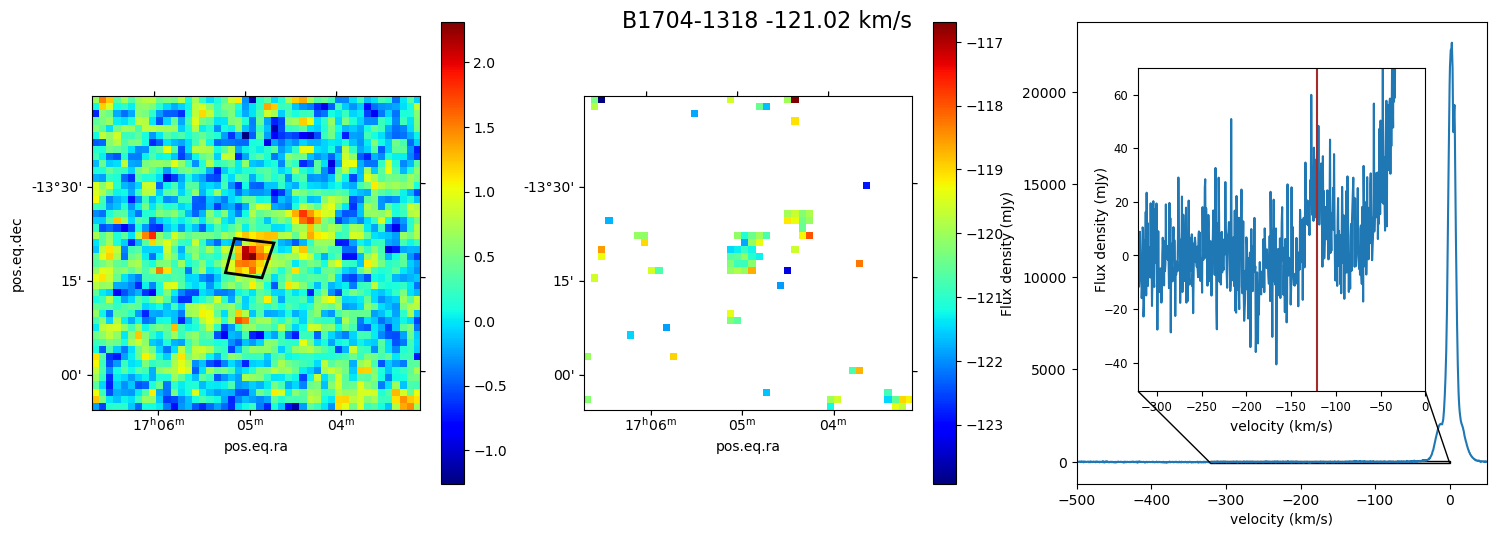

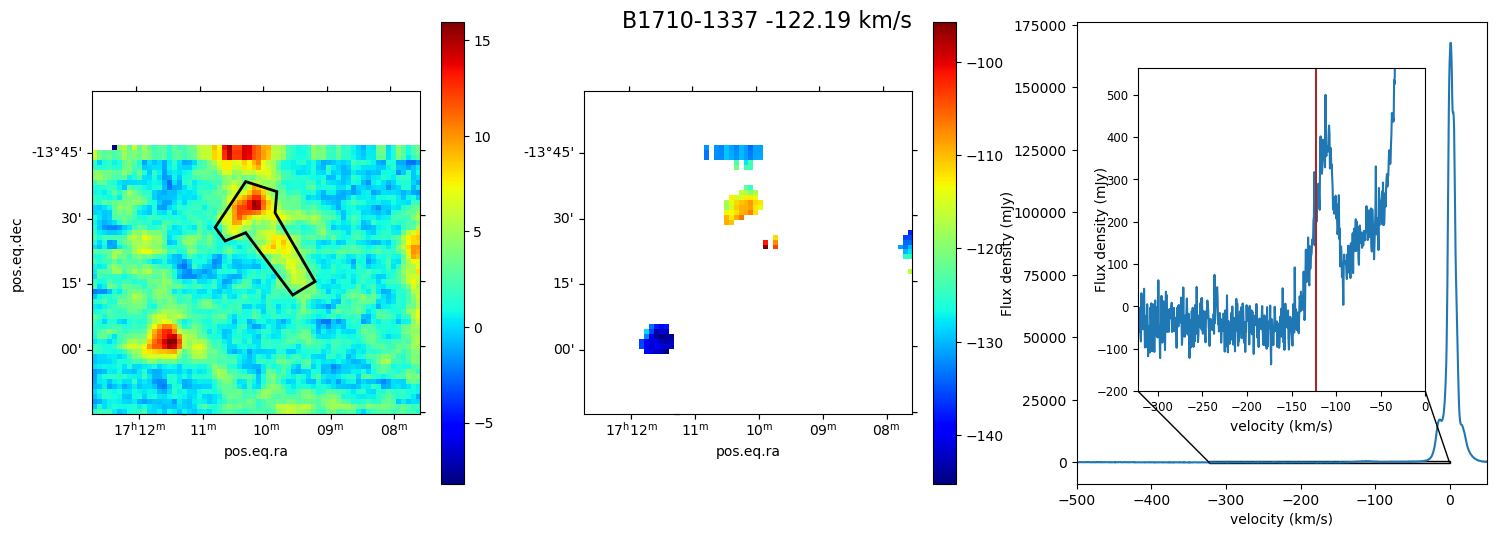

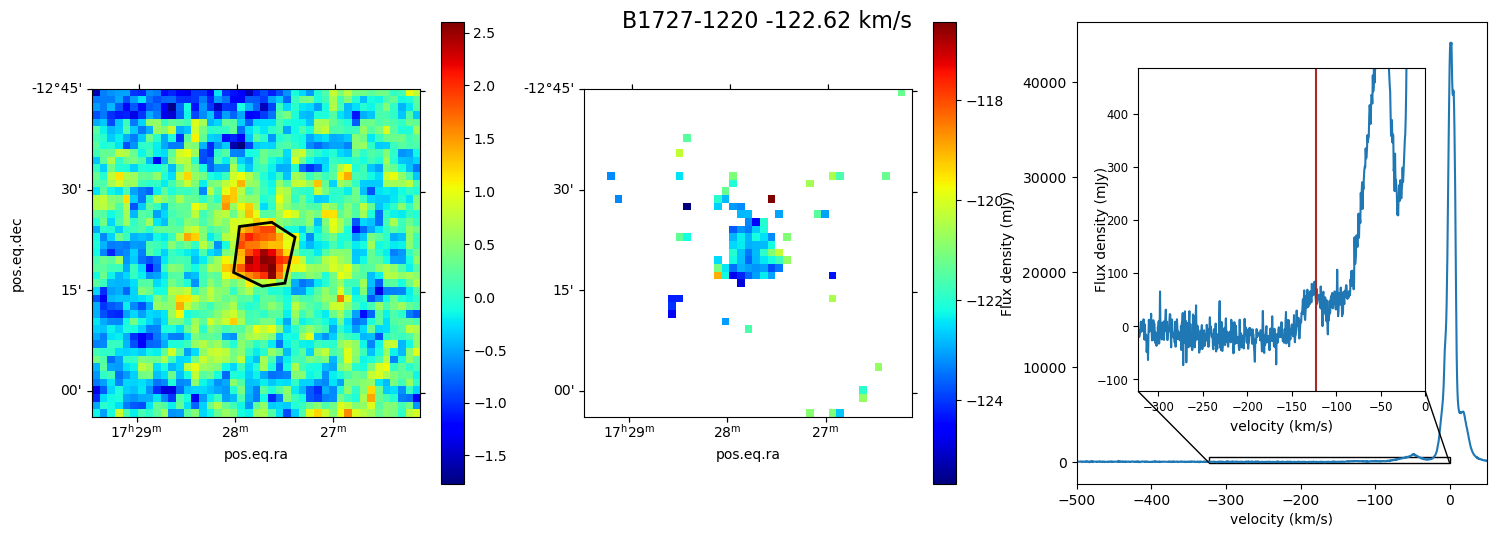

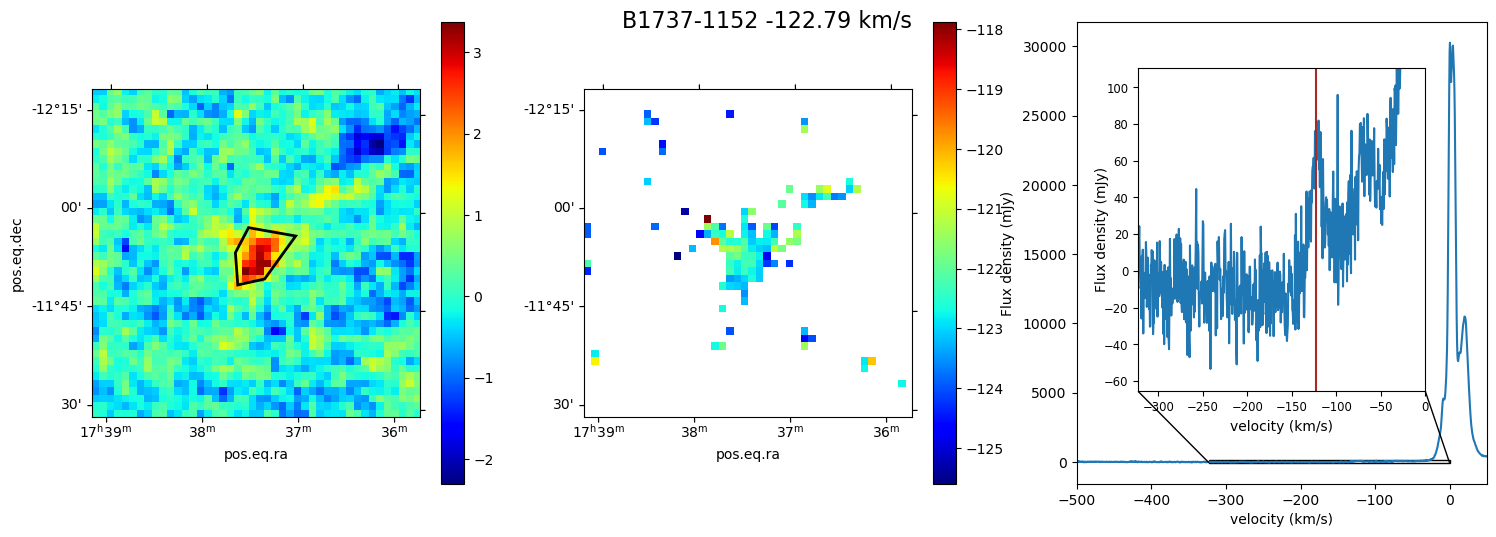

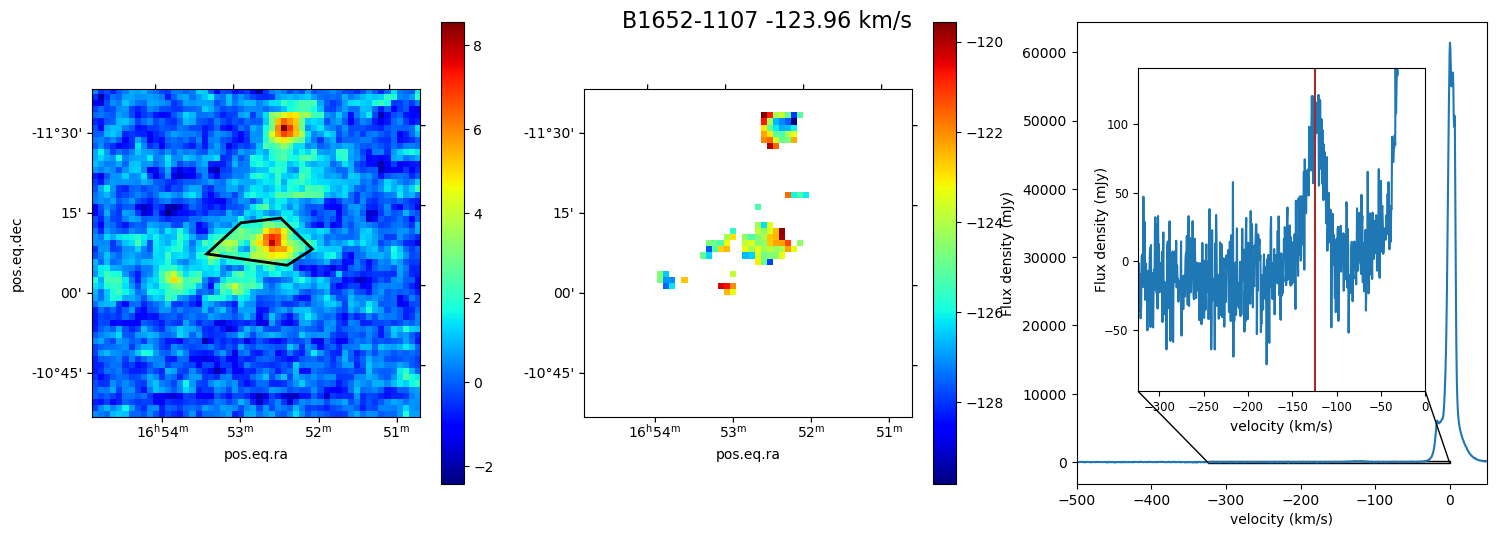

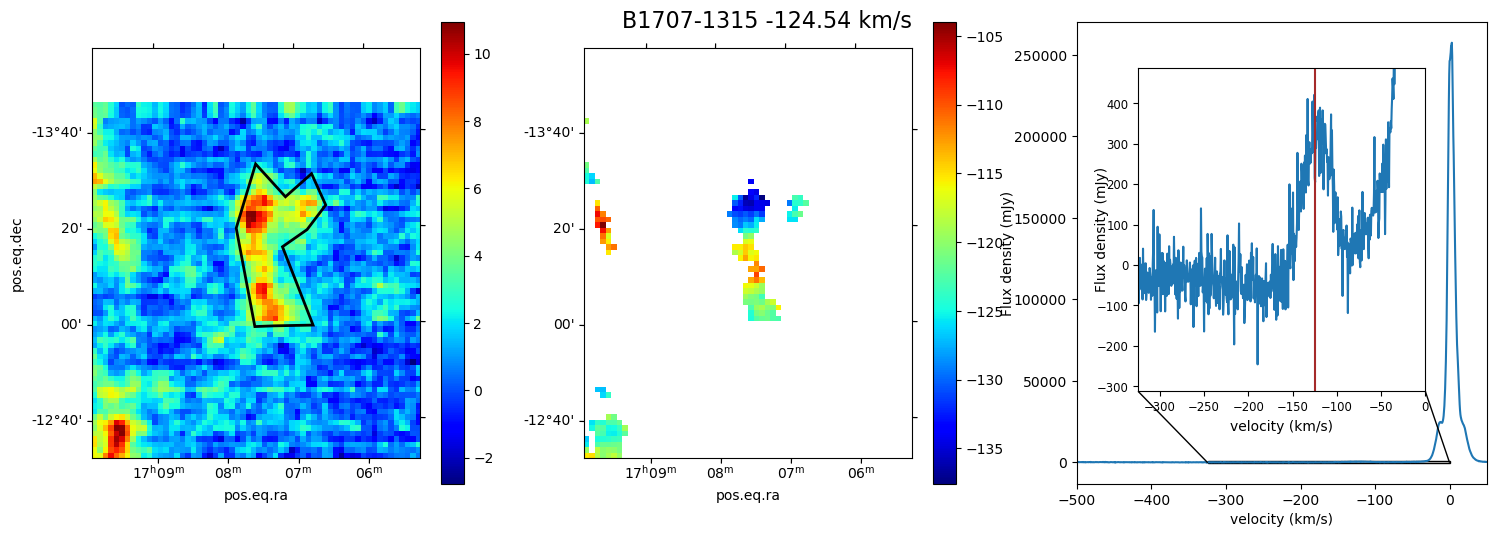

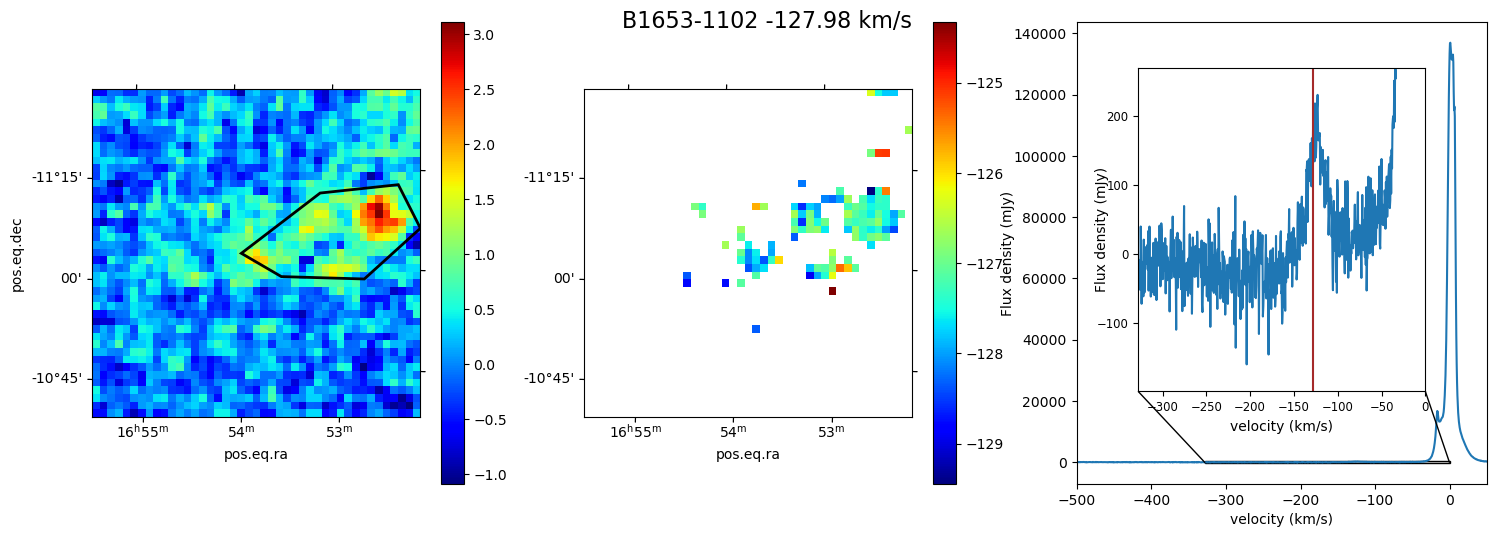

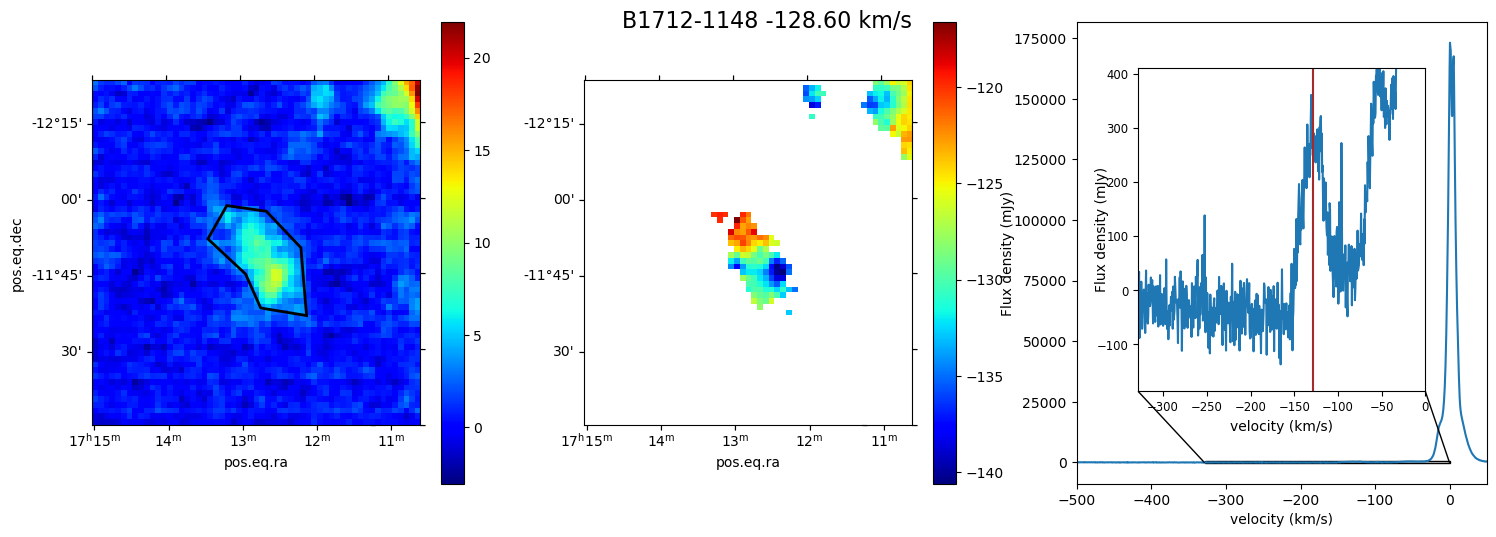

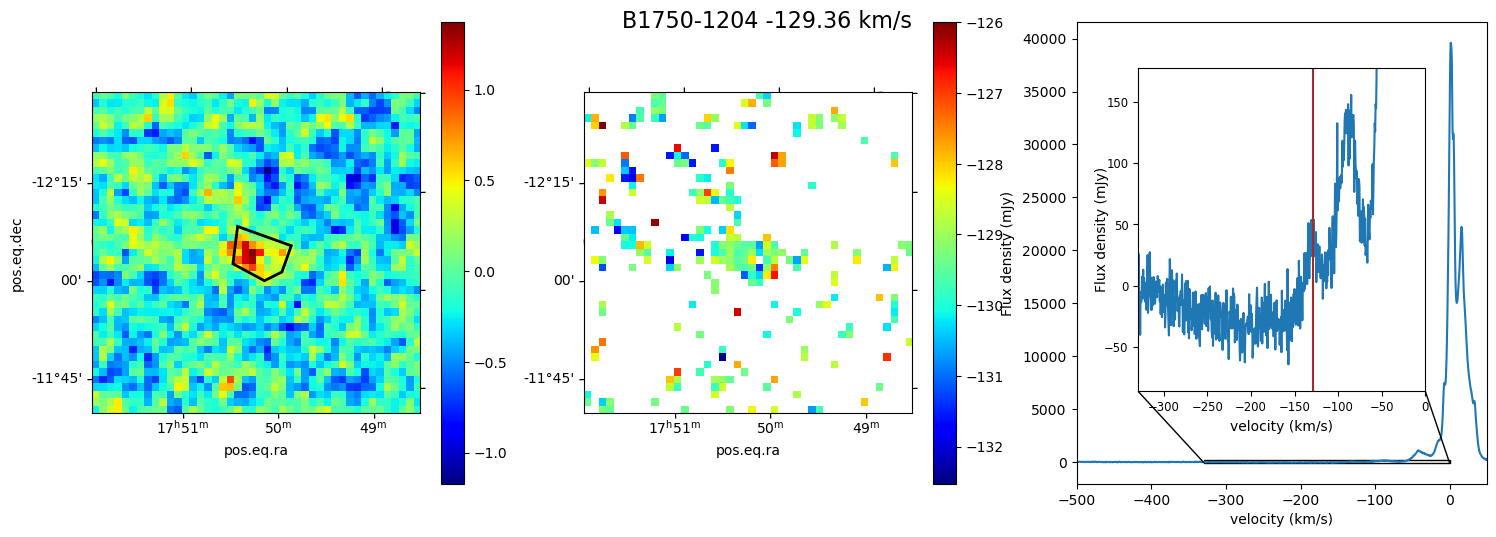

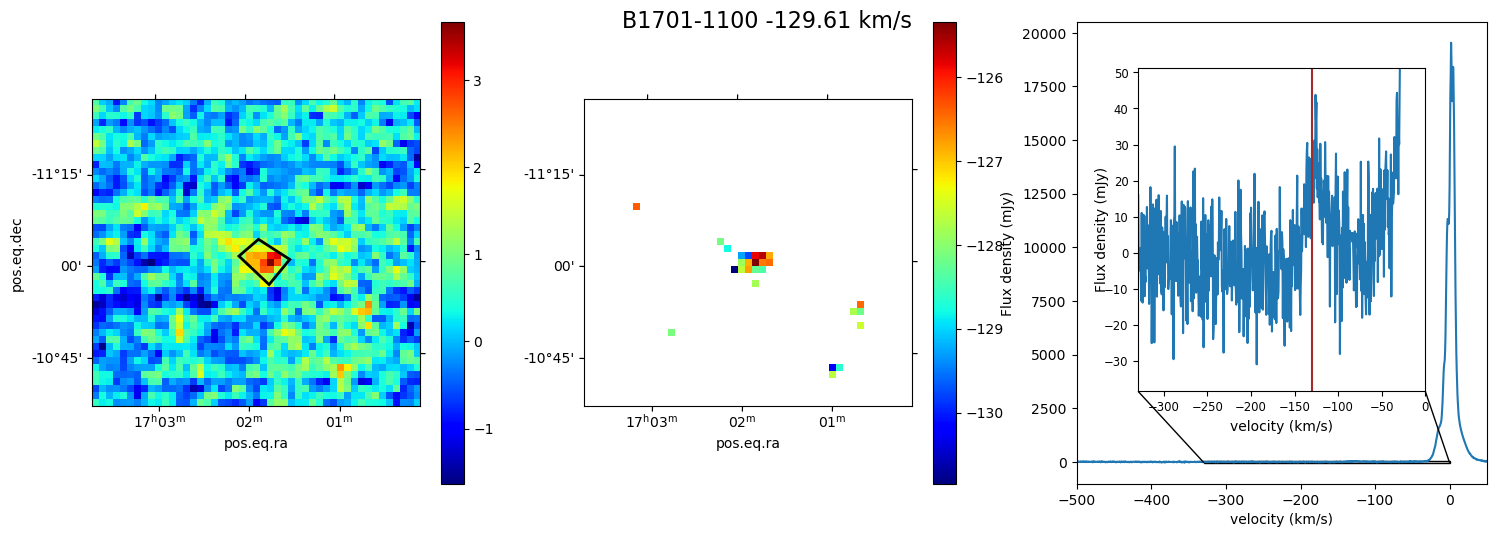

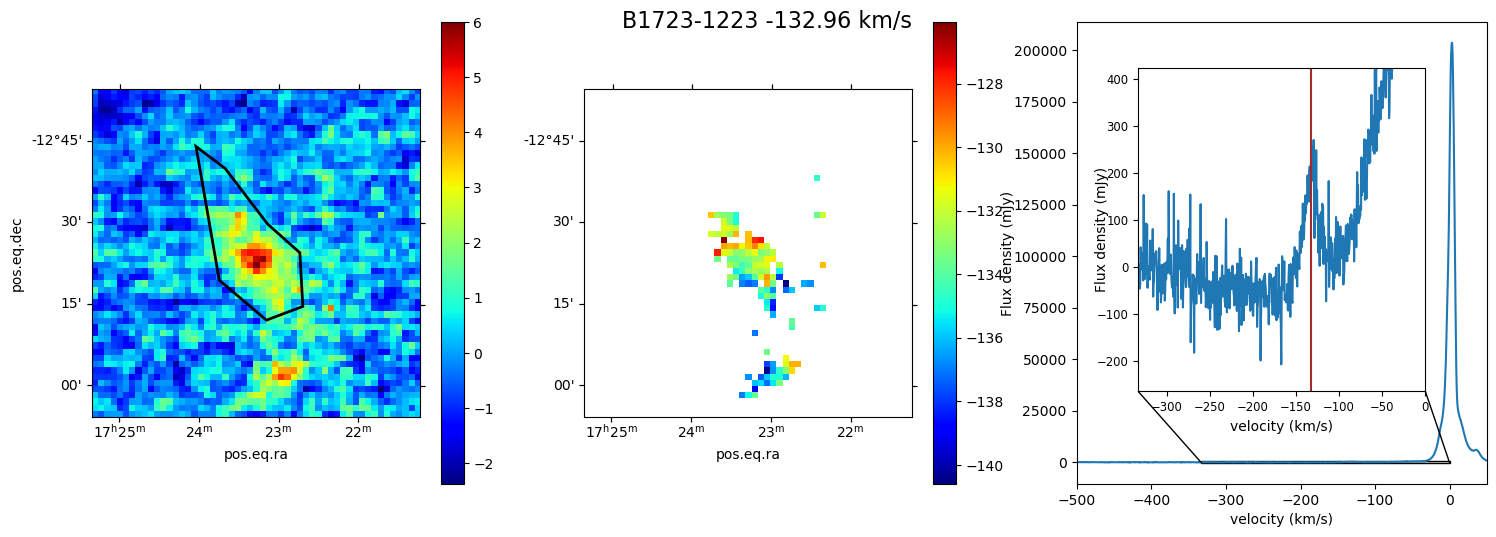

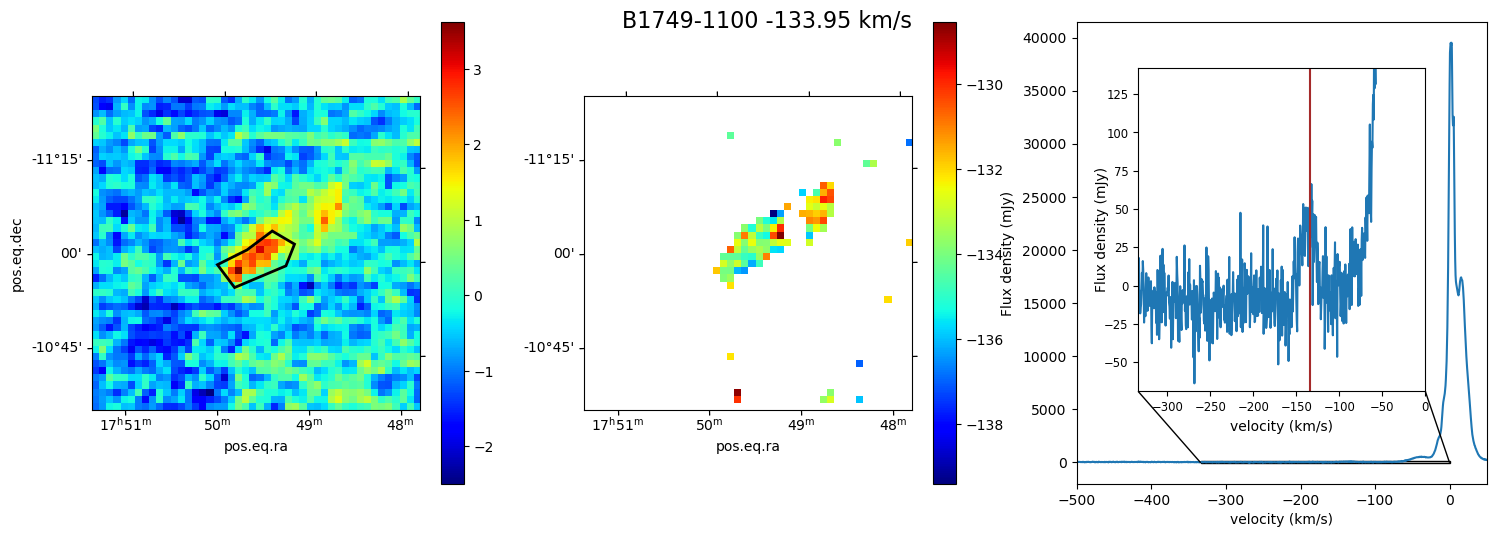

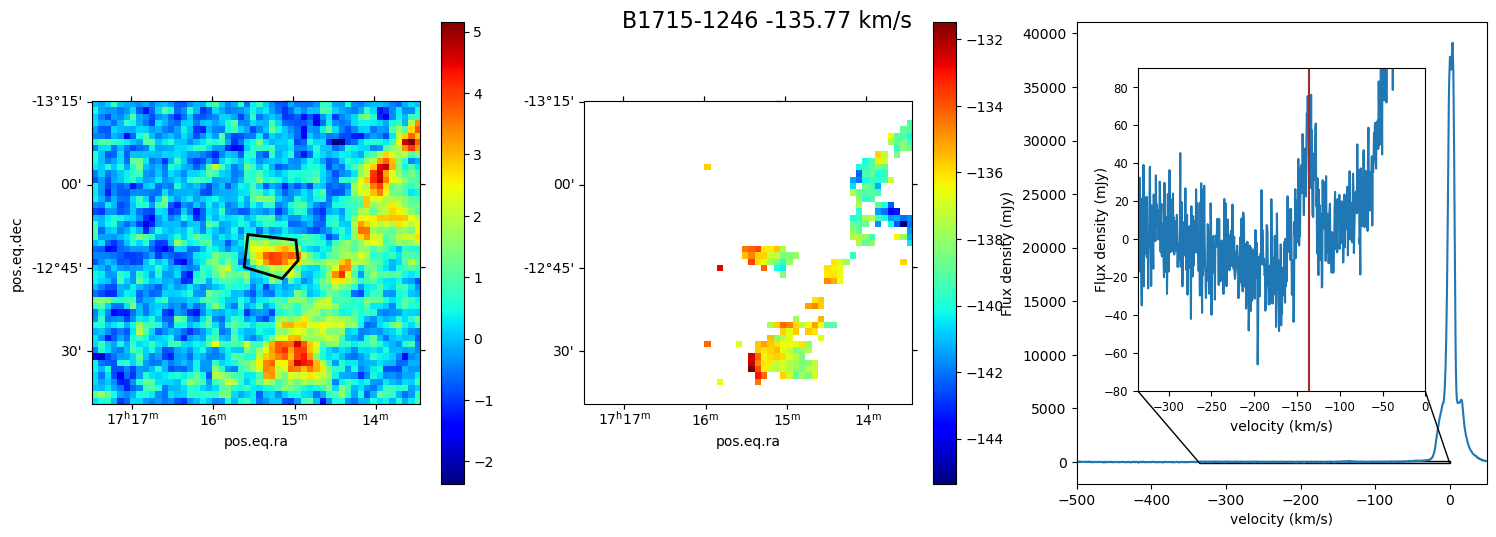

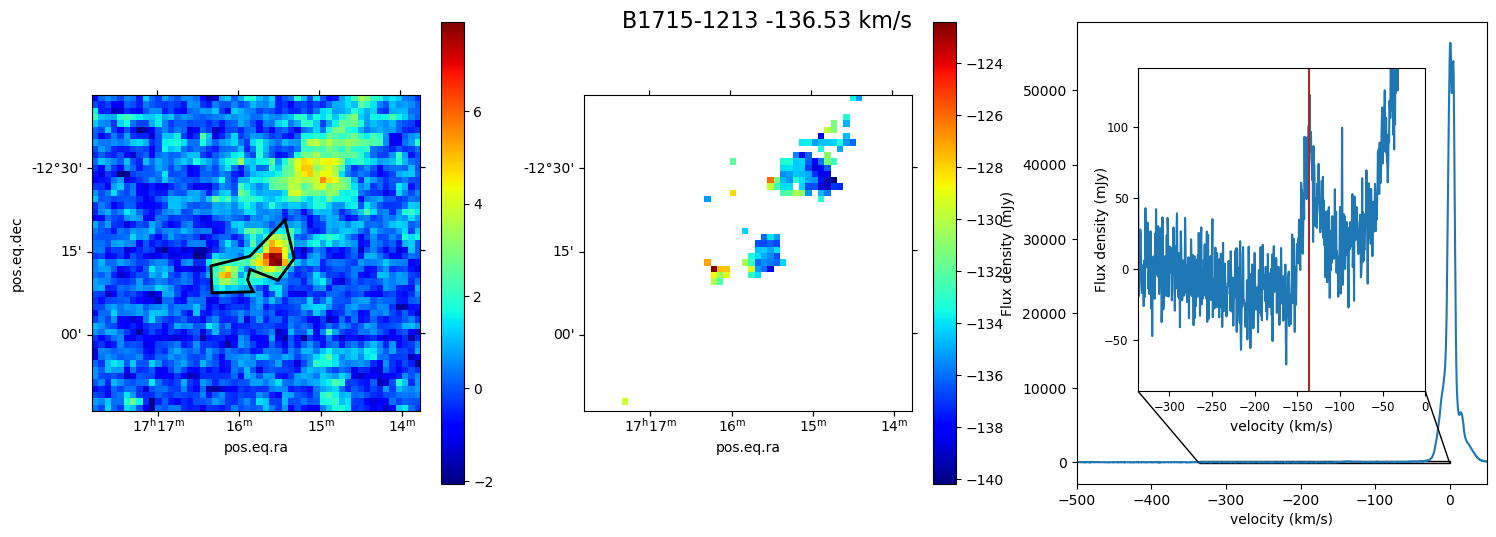

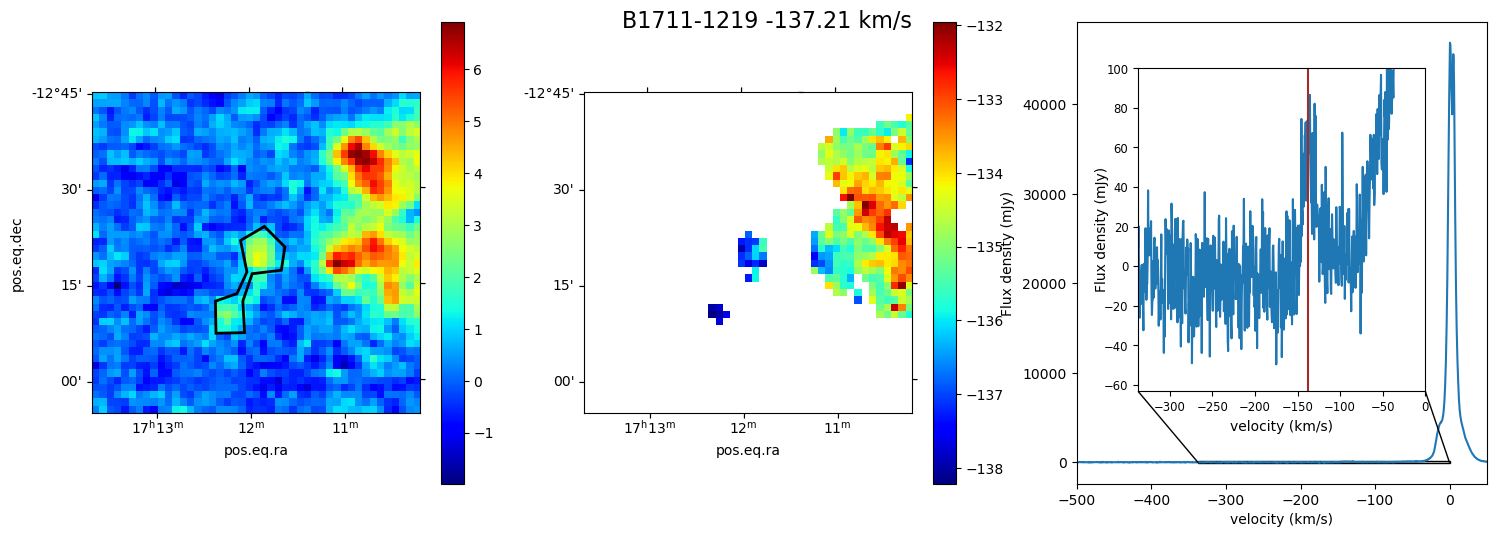

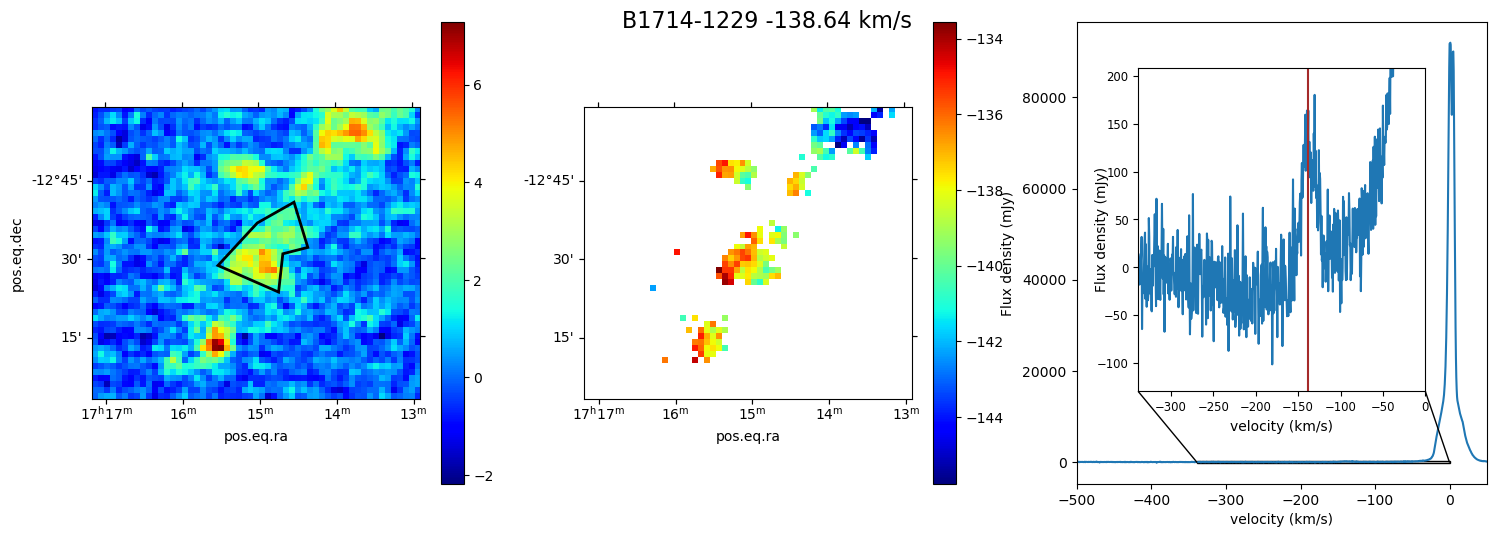

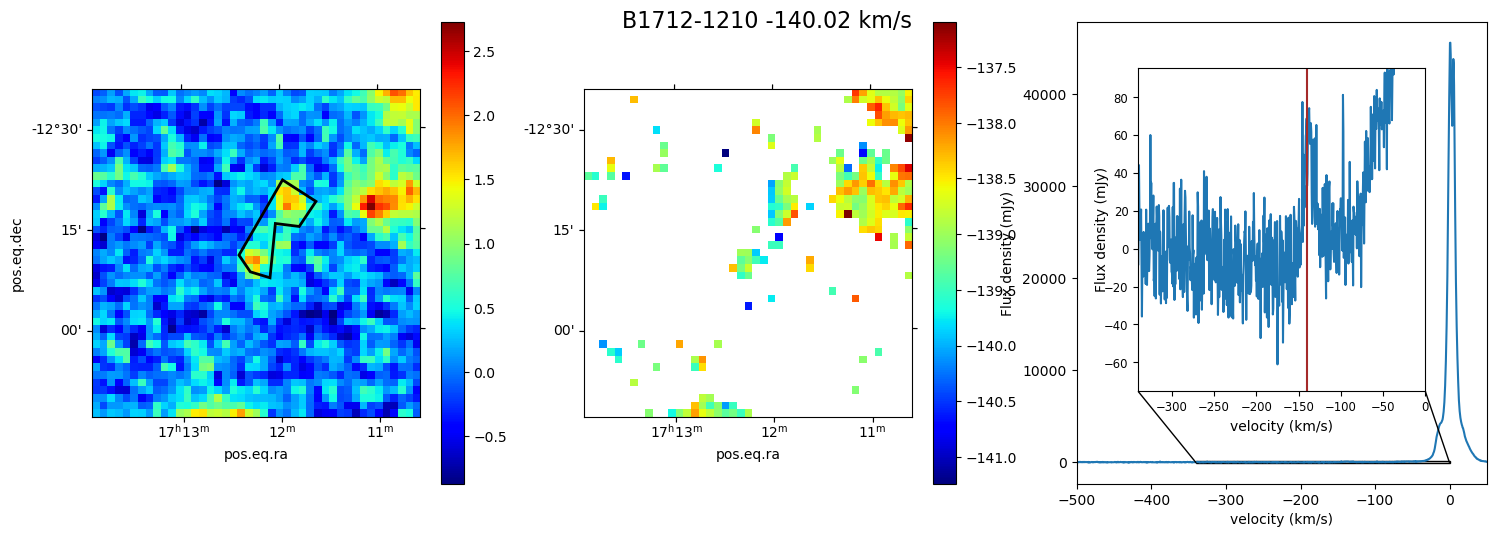

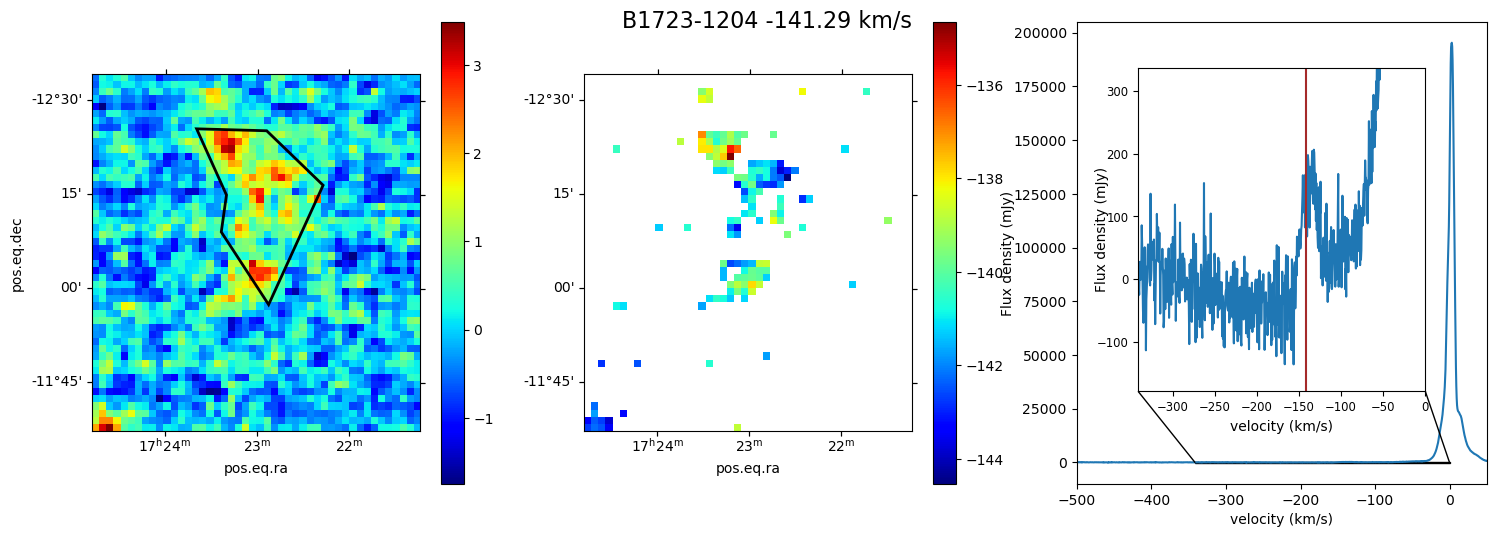

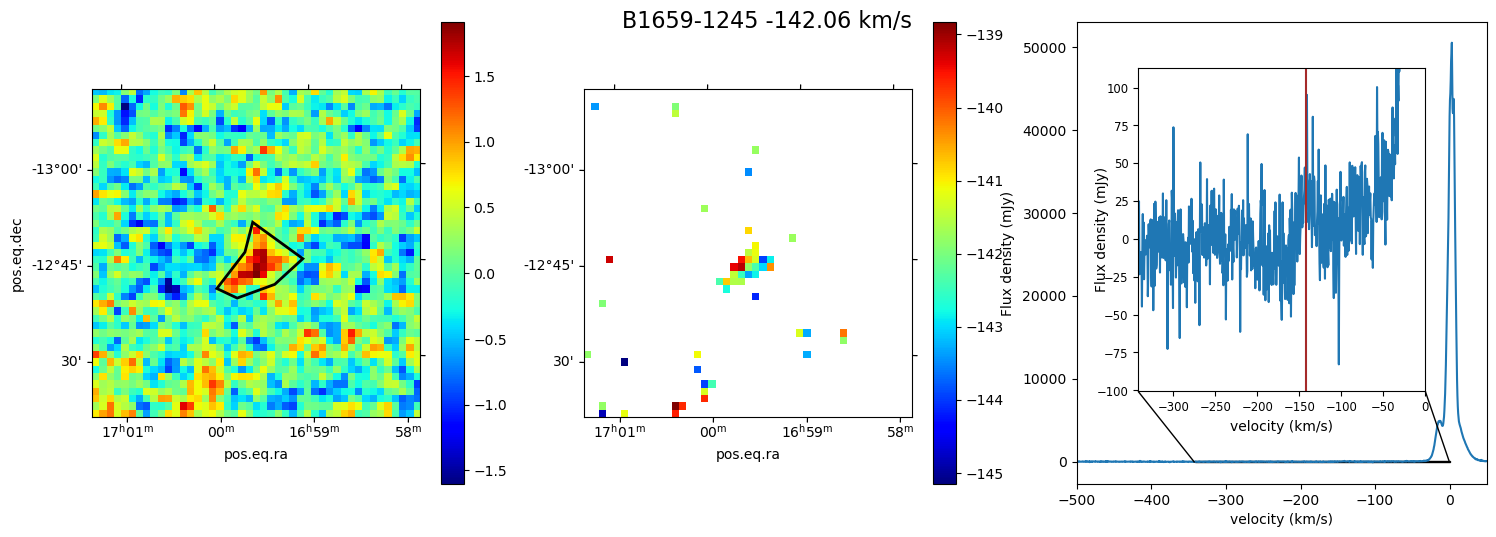

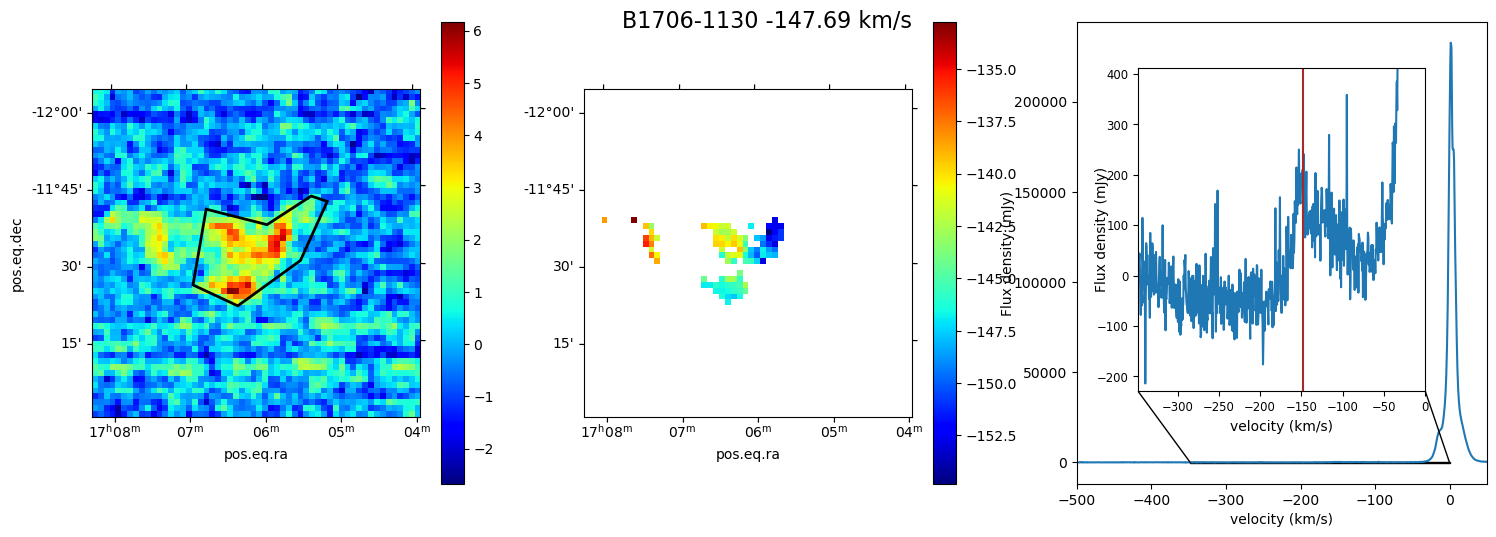

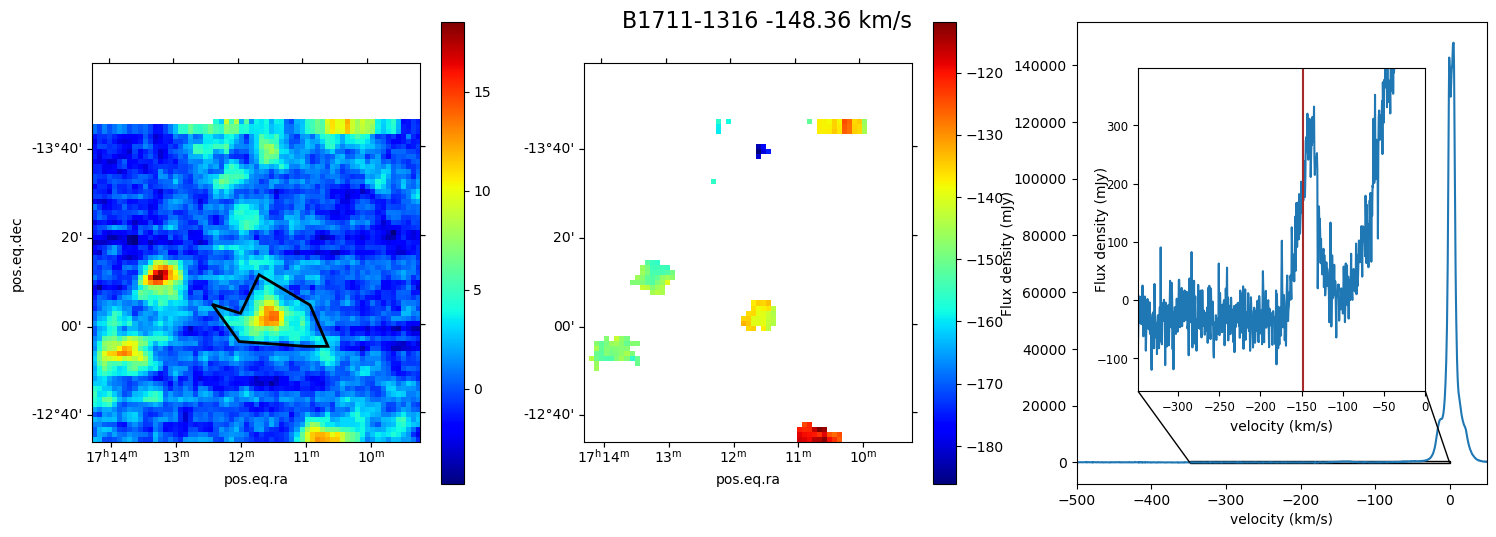

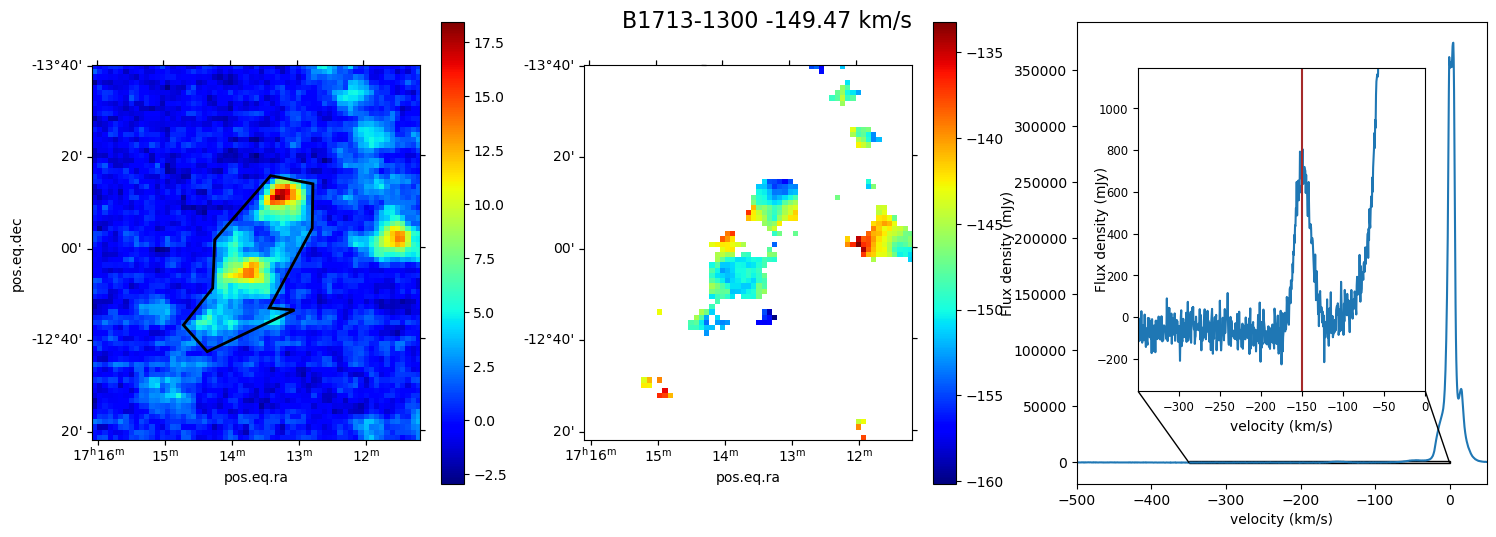

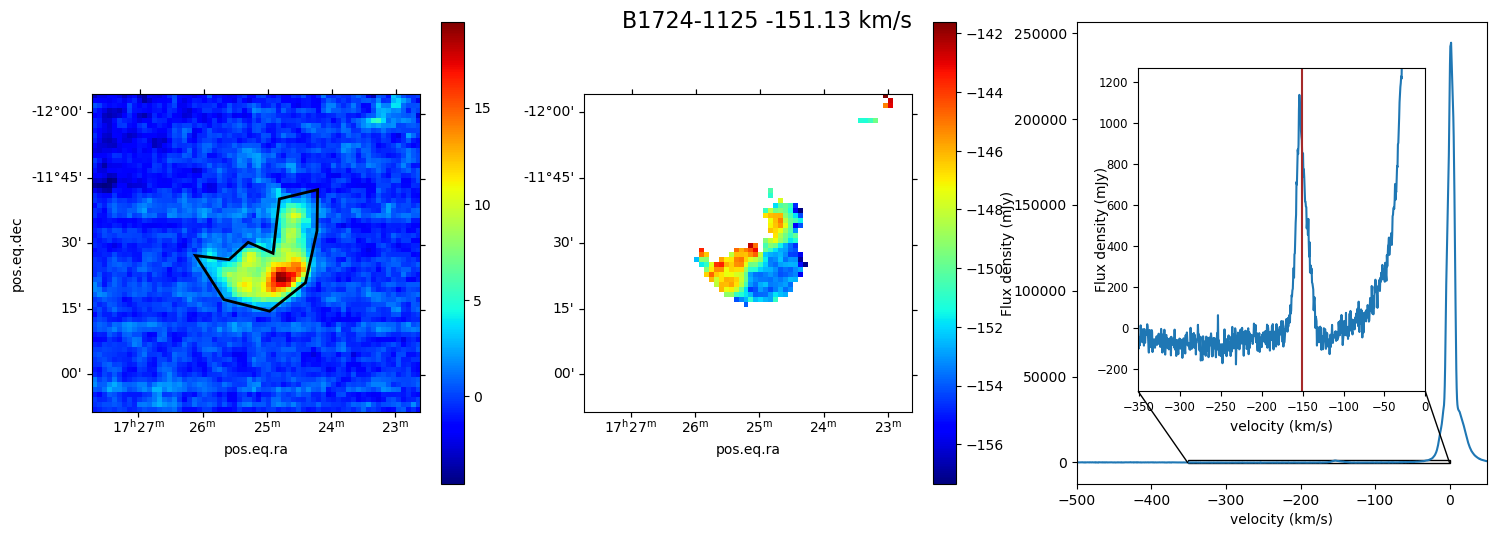

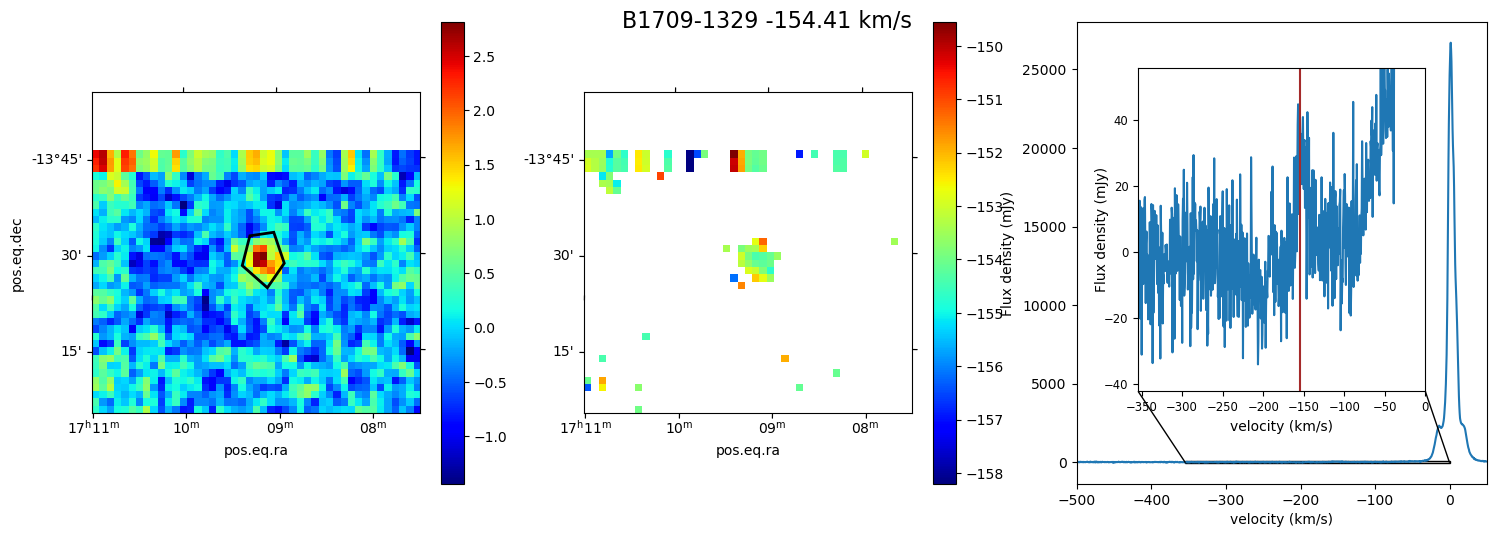

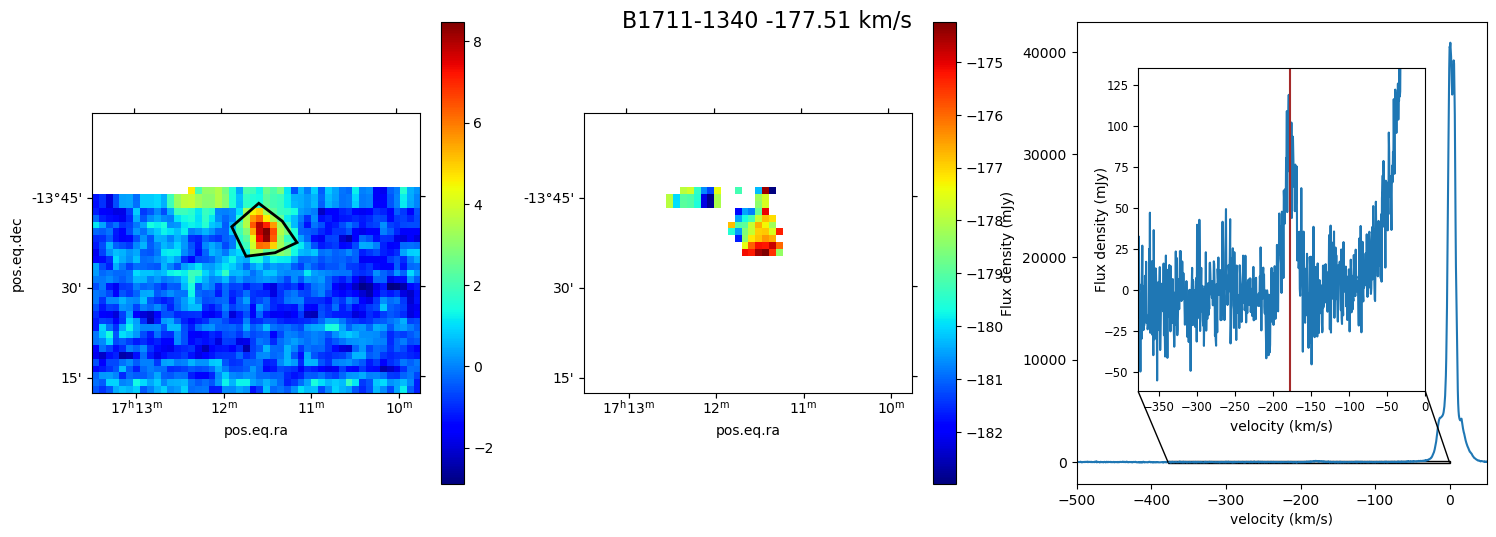

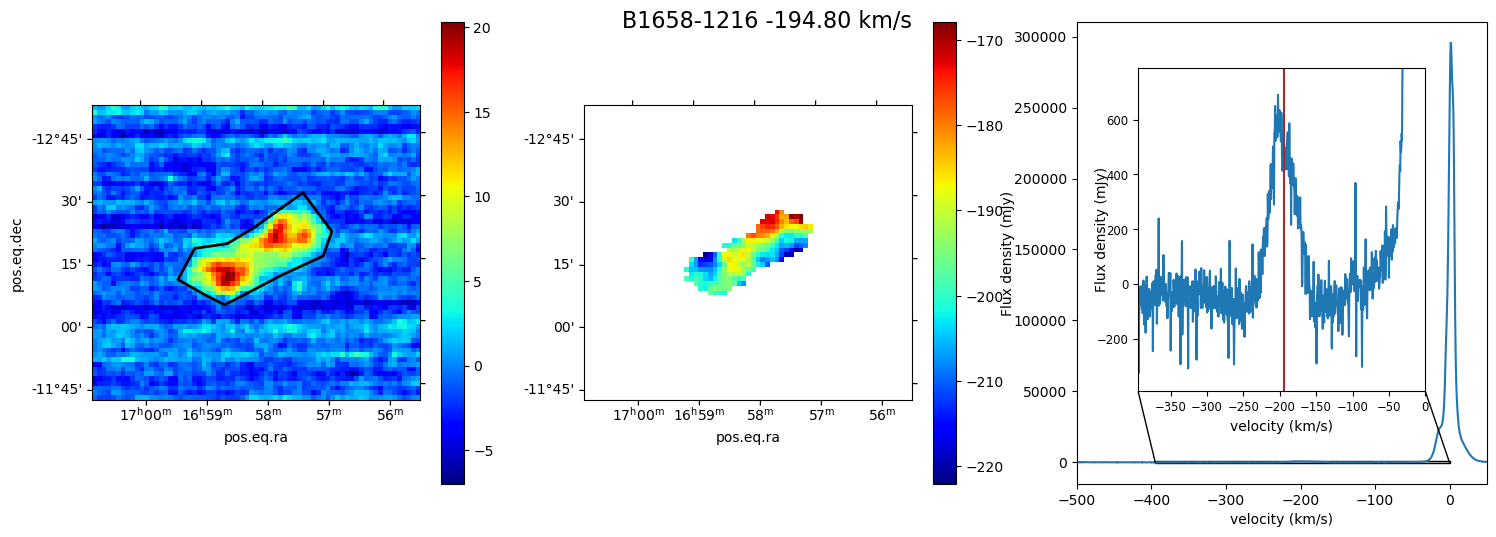

In [56]:
cube=SpectralCube.read('GCHVC_imcontsub_flaged.fits')
vels=(1420405751.768-np.array(cube.spectral_axis))/1420405751.768*299792.458
%matplotlib inline
from regions import PixCoord,PolygonPixelRegion
import warnings
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
warnings.simplefilter('ignore')
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax
for idx in result_select.index:
    X1,X2=int(result_select['X1'][idx]),int(result_select['X2'][idx])
    Y1,Y2=int(result_select['Y1'][idx]),int(result_select['Y2'][idx])
    Z1,Z2=int(result_select['Z1'][idx]),int(result_select['Z2'][idx])
    Xm,XM=max(0,X1-20),min(cube.shape[2],X2+20)
    Ym,YM=max(0,Y1-20),min(cube.shape[1],Y2+20)
    #Xm,XM=max(0,X1),min(cube.shape[2],X2)
    #Ym,YM=max(0,Y1),min(cube.shape[1],Y2)
    cube_sub=cube[Z1:Z2,Ym:YM,Xm:XM]
    vel=(1420405751.768-float(result_select['FREQ'][idx]))/1420405751.768*299792.458
    print(cube_sub.shape)
    cube_sub=cube_sub.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=1420405751.768*u.Hz)
    mmt0=cube_sub.with_spectral_unit(u.km/u.s).moment(order=0)
    mmt1=cube_sub.with_spectral_unit(u.km/u.s).moment(order=1)
    mmt2=cube_sub.with_spectral_unit(u.km/u.s).moment(order=2)
    m0cu=mmt0.hdu.data
    hispix=m0cu-np.nanmean(m0cu)>0.04*(Z2-Z1)
    mmt1.hdu.data[~hispix]=np.nan
    mmt2.hdu.data[~hispix]=np.nan
    fig=plt.figure(figsize=[18,6])
    line1='Peak:\n'
    line2='RA: %s\n'%(result_select['RA'][idx])
    line3='Dec: %s\n'%(result_select['DEC'][idx])
    line4='Velocity: %.2f km/s\n'%vel
    line5='Nchannel: %s\n'%(result_select['Nchan'][idx])
    line6='peak nsigma: %s\n'%(result_select['S/Nmax'][idx])
    #plt.text(0.7,0.2,line1+line2+line3+line4+line5+line6,fontsize=16)
    plt.axis('off')
    fig.suptitle(result_select['Name'][idx]+' %.2f km/s'%vel,x=0.5,y=0.9,fontsize=16)
    ax=fig.add_subplot(131,projection=mmt0.wcs)
    regs=regions.Regions.read('sub_fits/%s_region.crtf'%(result_select['Name'][idx]))
    im=ax.imshow(mmt0.hdu.data,cmap='jet')
    fig.colorbar(im)
    reg_plot = PolygonPixelRegion(vertices=regs[0].to_pixel(mmt0.wcs).vertices)
    patch = reg_plot.plot(ax=ax, facecolor='none', edgecolor='k', lw=2, label='Polygon')
    ax.invert_yaxis()
    ax=fig.add_subplot(132,projection=mmt1.wcs)
    im=ax.imshow(mmt1.hdu.data,cmap='jet')
    fig.colorbar(im)
    ax.invert_yaxis()
    ax.set_ylabel('_',alpha=0)
    ax=fig.add_subplot(133)
    factor=1.222e3/1420405751.768e-9**2/abs(cube.header['cdelt1']*cube.header['cdelt2'])/3600**2
    spec=cube.subcube_from_regions(regs).sum(axis=(1,2))/factor
    ax.plot(vels,spec)
    ax.set_xlabel('velocity (km/s)')
    ax.set_ylabel('Flux density (mJy)')
    ax.yaxis.set_label_coords(-0.15,0.5)
    if vel>0:
        ax.set_xlim(-50,np.max(vels))
        subax=add_subplot_axes(ax,[0.25,0.2,0.7,0.7])
    else:
        ax.set_xlim(np.min(vels),50)
        subax=add_subplot_axes(ax,[0.15,0.2,0.7,0.7])
    if vel>0:
        slices=(vels>=max(vel-100,60))*(vels<=vel+100)
    else:
        slices=(vels>=vel-100)*(vels<=min(vel+100,-60))
    #ax.plot(vels[slices],spec[slices])
    subax.plot(vels,spec)
    m=min(spec[slices]).value
    M=max(spec[slices]).value
    subax.set_ylim(1.1*m-0.1*M,1.1*M-0.1*m)
    if vel>0:
        subax.set_xlim(0,vel+200)
    else:
        subax.set_xlim(vel-200,0)
    mark_inset(ax, subax, loc1=3, loc2=4, fc="none", ec='k', lw=1)
    subax.axvline(vel,c='brown')
    subax.set_xlabel('velocity (km/s)')
    subax.set_ylabel('Flux density (mJy)')
    subax.yaxis.set_label_coords(-0.1,0.5)
    plt.savefig('figs/%s_moments_selected.pdf'%(result_select['Name'][idx]))
    mmt0[~hispix]=np.nan
    mmt0.hdu.writeto('sub_fits/%s_moment0.fits'%(result_select['Name'][idx]),overwrite=True)
    mmt1[~hispix]=np.nan
    mmt1.hdu.writeto('sub_fits/%s_moment1.fits'%(result_select['Name'][idx]),overwrite=True)
    cube_sub.hdu.writeto('sub_fits/%s_sub.fits'%(result_select['Name'][idx]),overwrite=True)

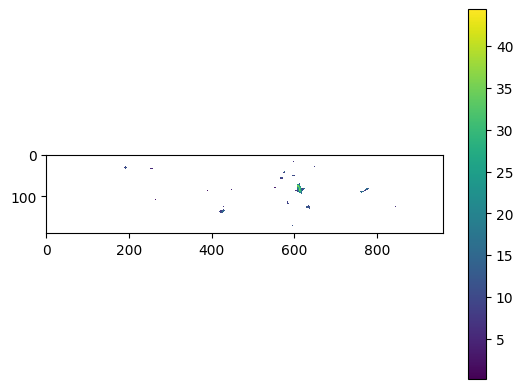

In [102]:
combimage=np.zeros([190,960])
combimage[:,:]=np.nan
imageidx=np.zeros_like(combimage)
for idx in result_select.index:
    hdulsub=fits.open('sub_fits/%s_moment0.fits'%(result_select['Name'][idx]))
    xdel=int(-hdulsub[0].header['CRPIX2']+cube.header['CRPIX2'])
    ydel=int(-hdulsub[0].header['CRPIX1']+cube.header['CRPIX1'])
    hispix=np.where(~np.isnan(hdulsub[0].data))
    for ipix in range(len(hispix[0])):
        oldvalue=combimage[hispix[0][ipix]+xdel,hispix[1][ipix]+ydel]
        newvalue=hdulsub[0].data[hispix[0][ipix],hispix[1][ipix]]
        combimage[hispix[0][ipix]+xdel,hispix[1][ipix]+ydel]=np.nanmax([newvalue,oldvalue])
        if ~np.isnan(oldvalue) and newvalue<oldvalue:
            pass
        else:
            imageidx[hispix[0][ipix]+xdel,hispix[1][ipix]+ydel]=idx
plt.imshow(combimage)
plt.colorbar()
moment0hdu=hdulsub
moment0hdu[0].data=combimage

moment0hdu[0].header['CRPIX1']=cube.header['CRPIX1']
moment0hdu[0].header['CRPIX2']=cube.header['CRPIX2']
moment0hdu.writeto('moment0_combined.fits',overwrite=True)

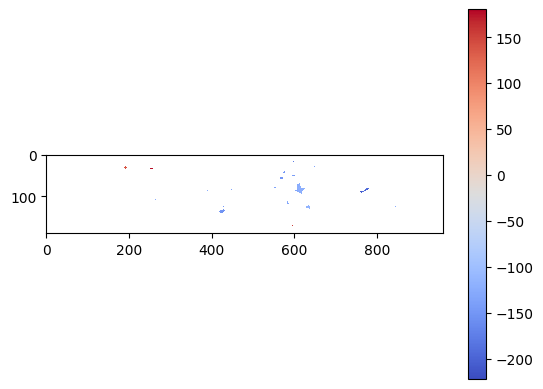

In [106]:
combimage=np.zeros([190,960])
combimage[:,:]=np.nan
for idx in result_select.index:
    hdulsub=fits.open('sub_fits/%s_moment1.fits'%(result_select['Name'][idx]))
    xdel=int(-hdulsub[0].header['CRPIX2']+cube.header['CRPIX2'])
    ydel=int(-hdulsub[0].header['CRPIX1']+cube.header['CRPIX1'])
    hispix=np.where(~np.isnan(hdulsub[0].data))
    for ipix in range(len(hispix[0])):
        if imageidx[hispix[0][ipix]+xdel,hispix[1][ipix]+ydel]==idx:
            combimage[hispix[0][ipix]+xdel,hispix[1][ipix]+ydel]=hdulsub[0].data[hispix[0][ipix],hispix[1][ipix]]
plt.imshow(combimage,cmap='coolwarm')
plt.colorbar()
moment1hdu=hdulsub
moment1hdu[0].data=combimage

moment1hdu[0].header['CRPIX1']=cube.header['CRPIX1']
moment1hdu[0].header['CRPIX2']=cube.header['CRPIX2']
moment1hdu.writeto('moment1_combined.fits',overwrite=True)

In [45]:
# 4邻域的连通域和 8邻域的连通域
# [row, col]
NEIGHBOR_HOODS_4 = True
OFFSETS_4 = [[0, -1], [-1, 0], [0, 0], [1, 0], [0, 1]]

NEIGHBOR_HOODS_8 = False
OFFSETS_8 = [[-1, -1], [0, -1], [1, -1],
             [-1,  0], [0,  0], [1,  0],
             [-1,  1], [0,  1], [1,  1]]

def neighbor_value(binary_img: np.array, offsets, reverse=False):
    rows, cols = binary_img.shape
    label_idx = 0
    rows_ = [0, rows, 1] if reverse == False else [rows-1, -1, -1]
    cols_ = [0, cols, 1] if reverse == False else [cols-1, -1, -1]
    for row in range(rows_[0], rows_[1], rows_[2]):
        for col in range(cols_[0], cols_[1], cols_[2]):
            label = 10000
            if binary_img[row][col] < 0.5:
                continue
            for offset in offsets:
                neighbor_row = min(max(0, row+offset[0]), rows-1)
                neighbor_col = min(max(0, col+offset[1]), cols-1)
                neighbor_val = binary_img[neighbor_row, neighbor_col]
                if neighbor_val < 0.5:
                    continue
                label = neighbor_val if neighbor_val < label else label
            if label == 9999:
                label_idx += 1
                label = label_idx
            binary_img[row][col] = label
    return binary_img

# binary_img: bg-0, object-255; int
def Two_Pass(binary_img: np.array, neighbor_hoods):
    if neighbor_hoods == NEIGHBOR_HOODS_4:
        offsets = OFFSETS_4
    elif neighbor_hoods == NEIGHBOR_HOODS_8:
        offsets = OFFSETS_8
    else:
        raise ValueError

    binary_img = neighbor_value(binary_img, offsets, False)
    binary_img = neighbor_value(binary_img, offsets, True)

    return binary_img


In [46]:
binimage=~np.isnan(moment0hdu[0].data)
idximage=Two_Pass(binimage.astype(int)*9999,NEIGHBOR_HOODS_4)

In [103]:
for i in range(1,np.max(idximage)):
    idx=np.where(idximage==i)
    if 12 in idx[0]:
        print(i)
    if len(idx[0])<5:
        moment0hdu[0].data[idx]=np.nan
moment0hdu[0].data[idximage==2]=np.nan
moment0hdu[0].data[idximage==5]=np.nan
moment0hdu[0].data[idximage==6]=np.nan
moment0hdu[0].data[idximage==9]=np.nan

2
4
5
6
9
11
13
14
15


(0.0, 34.0)

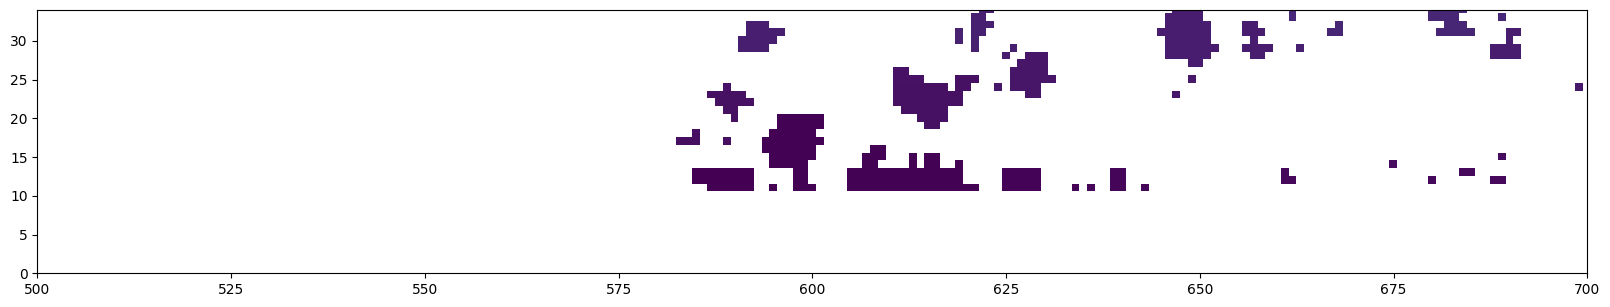

In [93]:
plt.figure(figsize=[20,10])
idximage_c=idximage*1.0
idximage_c[idximage==0]=np.nan
plt.imshow(idximage_c)
plt.xlim(500,700)
plt.ylim(0,34)

In [107]:
moment0hdu.writeto('moment0_combined.fits',overwrite=True)
moment1hdu[0].data[np.isnan(moment0hdu[0].data)]=np.nan
moment1hdu.writeto('moment1_combined.fits',overwrite=True)